In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Author: Drew Rebar<br>
The purpose of this notebook is to characterize uncertainty and noise associated with a lockin amplifier measurement.<br>
<br>
Lockin amplifier: A tired EG&G Princeton Applied Research Model 5210 Lock-in Amplifier purchased on ebay.<br>
<br>
Four probe resistance measurement: The circuit consisted of the lockin amplifier internal oscillator, a 1 kOhm current limiter, <br>
an 0.5 Ohm sample, and ground.  Resistor boxes with BNC connectors were constructed, and connections were made by <br>
coaxial cable.  Measurement of the sample resistor was performed in A-B mode of the lockin amplifier.  Measurements are<br>
displayed as voltages except for the internal oscillator voltage sweep where the voltage measurement was converted <br>
to resistance.<br>

Questions
1. What is the optimal internal oscillator voltage based on the uncertainty profile?
2. What is the optimal internal oscillator frequency based on the noise profile?
3. What is the optimal time constant based on the uncertainty profile?
4. How does uncertainty evolve in time with a repeated measurement?
5. Can uncertainty be determined by sweeping through a full cycle of the phasor offset angle?

<a id="Outline"></a>

# Outline
<ul>
<li><a href="#Import-Packages">Import Packages</a></li>
<li><a href="#Function-Definitions">Function Definitions</a></li>
<li><a href="#Lockin-amplifier-communication">Lockin Amplifier Communication</a></li>
<li><a href="#Noise-Measurement:-Internal-Oscillator-Voltage-Sweep">Noise Measurement: Internal Oscillator Voltage Sweep</a></li>
<li><a href="#Noise-Measurement:-Internal-Oscillator-Frequency-Sweep">Noise Measurement: Internal Oscillator Frequency Sweep</a></li>
<li><a href="#Noise-Measurement:-Time-Constant-Sweep">Noise Measurement: Time Constant Sweep</a></li>
<li><a href="#Noise-Measurement:-Long-Data-Collection">Noise Measurement: Long Data Collection</a></li>
<li><a href="#Noise-Measurement:-Phasor-Offset-Angle-Sweep">Noise Measurement: Phasor Offset Angle Sweep</a></li>
<li><a href="#Results-and-Analysis">Results and Analysis</a></li>
<li><a href="#Summary">Summary</a></li>
<li><a href="#Python-and-Package-Versions">Python and Package Versions</a></li>
</ul>

<a id="Import-Packages"></a>

## Import Packages

In [2]:
from IPython.display import clear_output
import pyvisa
from pyvisa.constants import StopBits, Parity
import time
from time import sleep
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy import fft
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from platform import python_version
from py_session import py_session

%matplotlib inline

<a id="Function-Definitions"></a>

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Import-Packages">Import Packages</a></li>
</ul>

## Function Definitions
<ul>
<li><a href="#Lockin-amplifier-communication">Lockin Amplifier Communication</a></li>
<li><a href="#Noise-Measurement:-Internal-Oscillator-Voltage-Sweep">Noise Measurement: Internal Oscillator Voltage Sweep</a></li>
<li><a href="#Noise-Measurement:-Internal-Oscillator-Frequency-Sweep">Noise Measurement: Internal Oscillator Frequency Sweep</a></li>
<li><a href="#Noise-Measurement:-Time-Constant-Sweep">Noise Measurement: Time Constant Sweep</a></li>
<li><a href="#Noise-Measurement:-Long-Data-Collection">Noise Measurement: Long Data Collection</a></li>
<li><a href="#Noise-Measurement:-Phasor-Offset-Angle-Sweep">Noise Measurement: Phasor Offset Angle Sweep</a></li>
<li><a href="#Results-and-Analysis">Results and Analysis</a></li>
<li><a href="#Summary">Summary</a></li>
<li><a href="#Python-and-Package-Versions">Python and Package Versions</a></li>
</ul>

In [3]:
#Function block

#Function list
#############################
#send
#query
#clear
#measure
#range2sett
#sett2range
#set_range
#read_range
#V2sett
#sett2V
#set_V
#freq2sett
#sett2freq
#set_freq
#Tc2sett
#sett2Tc
#set_Tc
#offset2sett
#sett2offset
#set_offset
#line_write
#V2R
#############################   

#this function defines send for lockin amplifier communications
def send(com):
    inst.write(com)

#this function defines query for lockin amplifier communications
def query(com):
    inst.write(com)
    sleep(1)
    return inst.read().rstrip('\r\n')

#this function clears the communications buffer
def clear():
    inst.clear()

#this function returns the lockin amplifier measurement of magnitude, phase, and noise
def measure(setting):
    
    for n in range(10):
        try:
            clear()
            sleep(1)
            t = time.time()
            
            mp = query('MP').split(',')
            sleep(1)
            nn = query('NN')

            mag = setting * float(mp[0])/10000
            pha = float(mp[1]) / 1000
            tries = n+1
            noise = setting * float(nn)/10000

            dat = {'Magnitude':mag, 
                    'Phase': pha, 
                    'Meas_attempts':tries,
                    'Noise':noise,
                    'Time':t}
            
            return dat
            break
        except:
            sleep(1)

#this function determines the lockin amplifier setting for a voltage range setting
def range2sett(Vr):
    if Vr == round(100 * 10**-9,7):
        n = 0
    elif Vr == round(300 * 10**-9,7):
        n = 1
    elif Vr == round(1 * 10**-6,6):
        n = 2
    elif Vr == round(3 * 10**-6,6):
        n = 3
    elif Vr == round(10 * 10**-6,5):
        n = 4
    elif Vr == round(30 * 10**-6,5):
        n = 5
    elif Vr == round(100 * 10**-6,4):
        n = 6
    elif Vr == round(300 * 10**-6,4): 
        n = 7
    elif Vr == round(1 * 10**-3,3):
        n = 8
    elif Vr == round(3 * 10**-3,3):
        n = 9
    elif Vr == round(10 * 10**-3,2):
        n = 10
    elif Vr == round(30 * 10**-3,2):
        n = 11
    elif Vr == round(100 * 10**-3,1):
        n = 12
    elif Vr == round(300 * 10**-3,1):
        n = 13
    elif Vr == 1:  
        n = 14
    elif Vr == 3:
        n = 15
    else:
        n = -1
        print('Incorrect voltage range entered.')
    return n
    
#this function determines the voltage range from the corresponding lockin amplifier setting
def sett2range(n):
    if n == 0:
        Vr = 100 * 10**-9
    elif n == 1:
        Vr = 300 * 10**-9
    elif n == 2:
        Vr = 1 * 10**-6
    elif n == 3:
        Vr = 3 * 10**-6
    elif n == 4:
        Vr = 10 * 10**-6
    elif n == 5:
        Vr = 30 * 10**-6
    elif n == 6:
        Vr = 100 * 10**-6
    elif n == 7: 
        Vr = 300 * 10**-6
    elif n == 8:
        Vr = 1 * 10**-3
    elif n == 9:
        Vr = 3 * 10**-3
    elif n == 10:
        Vr = 10 * 10**-3
    elif n == 11:
        Vr = 30 * 10**-3
    elif n == 12:
        Vr = 100 * 10**-3
    elif n == 13:
        Vr = 300 * 10**-3
    elif n == 14:  
        Vr = 1
    elif n == 15:
        Vr = 3
    else:
        Vr = -1
        print('Incorrect voltage range setting entered.')
    return Vr

#this function sets the lockin amplifier at the specified voltage range setting
def set_range(Vr):
    
    for k in range(10):
            try:
                send('SEN ' + str(range2sett(Vr)))
            except:
                pass
            sleep(1)
            try:
                response = int(query('SEN'))

                if response == range2sett(Vr):
                    print(f'Range setting set at {Vr} V')
                    return k+1
                    break
                elif response != range2sett(Vr) and k == 9:
                    print('Range setting set fail')
            except:
                pass
            sleep(1)

#this function reads and returns the lockin amplifier voltage range setting
def read_range():
    
    sett_dict = {
    '0':100 * 10**-9,
    '1':300 * 10**-9,
    '2':1 * 10**-6,
    '3':3 * 10**-6,
    '4':10 * 10**-6,
    '5':30 * 10**-6,
    '6':100 * 10**-6,
    '7':300 * 10**-6,
    '8':1 * 10**-3,
    '9':3 * 10**-3,
    '10':10 * 10**-3,
    '11':30 * 10**-3,
    '12':100 * 10**-3,
    '13':300 * 10**-3,
    '14':1,
    '15':3
    }

    for n in range(10):
        try:
            sett = sett_dict[query('SEN')]
            print(f'Lockin amplifier range setting: {sett} V')
            break
        except:
            pass
    return sett

#this function returns the lockin amplifier setting for the specified internal oscillator voltage amplitude
def V2sett(V):
    if 0 <= V <= 2:
        n = int(V * 1000)
    elif V == 5:
        n = int(5000)
    else:
        n = -1
        print('Incorrect internal oscillator voltage.')
    return n

#this function returns the internal oscillator voltage amplitude for the specified lockin amplifier setting
def sett2V(n):
    if 0 <= n <= 2000:
        V = n / 1000
    elif n == 5000:
        V = 5
    else:
        V = -1
        print('Incorrect internal oscillator voltage setting.')
    return V

#this function sets the internal oscillator voltage amplitude of the lockin amplifier
def set_V(V):

    for k in range(10):
        try:
            send('OA ' + str(V2sett(V)))
        except:
            pass
        sleep(1)
        try:
            response = int(query('OA'))

            if response == V2sett(V):
                print(f'Oscillator set at {V} V')
                return k+1
                break
            elif response != V2sett(V) and k == 9:
                print('Oscillator set fail')
        except:
            pass
        sleep(1)
        
#this function returns the lockin amplifier settings for a specified internal oscillator frequency
def freq2sett(freq):
    if 0.5 <= freq <= 120000:
        if 0.5 <= freq < 2:
            n1 = 5000 + (freq - 0.5) * 15000/(2 - 0.5)
            n2 = 0
        elif 2 <= freq < 20:
            n1 = 2000 + (freq - 2) * 18000/(20 - 2)
            n2 = 1
        elif 20 <= freq < 200:
            n1 = 2000 + (freq - 20) * 18000/(200 - 20)
            n2 = 2
        elif 200 <= freq < 2000:
            n1 = 2000 + (freq - 200) * 18000/(2000 - 200)
            n2 = 3
        elif 2000 <= freq < 20000:
            n1 = 2000 + (freq - 2000) * 18000/(20000 - 2000)
            n2 = 4
        elif 20000 <= freq <= 120000:
            n1 = 2000 + (freq - 20000) * 18000/(120000 - 20000)
            n2 = 5
        return int(n1),int(n2)
    else:
        print("You entered frequency value out of range.")

#this function returns the internal oscillator frequency for the specified lockin amplifier settings       
def sett2freq(n1,n2):
    n1 = int(n1)
    n2 = int(n2)
    
    if 0 <= n2 <= 5:
        if n2 == 0:
            freq = 0.5 + (n1 - 5000) * (2 - 0.5)/15000
        elif n2 == 1:
            freq = 2 + (n1 - 2000) * (20 - 2)/18000
        elif n2 == 2:
            freq = 20 + (n1 - 2000) * (200 - 20)/18000
        elif n2 == 3:
            freq = 200 + (n1 - 2000) * (2000 - 200)/18000
        elif n2 == 4:
            freq = 2000 + (n1 - 2000) * (20000 - 2000)/18000
        elif n2 == 5:
            freq = 20000 + (n1 - 2000) * (120000 - 20000)/18000
        return freq
    else:
        print('You entered lockin amplifier frequency setting incorrectly.')
        
#this function sets the internal oscillator frequency of the lockin amplifier
def set_freq(freq):

    for k in range(10):
            try:
                send('OF ' + str(freq2sett(freq)[0]) + ' ' + str(freq2sett(freq)[1]))
            except:
                pass
            sleep(1)
            try:
                response = tuple(map(int, query('OF').split(',')))

                if response[0] == freq2sett(freq)[0] and response[1] == freq2sett(freq)[1]:
                    print(f'Frequency set at {freq} Hz')
                    return k+1
                    break
                elif (response[0] != freq2sett(freq)[0] or response[1] != freq2sett(freq)[1]) and k == 9:
                    print('Frequency set fail')
            except:
                pass
            sleep(1)
            
#this function returns the lockin amplifier setting for the specified time constant
def Tc2sett(Tc): 
    if Tc == 0.001:
        n = 0
    elif Tc == 0.003:
        n = 1
    elif Tc == 0.01:
        n = 2
    elif Tc == 0.03:
        n = 3
    elif Tc == 0.1:
        n = 4
    elif Tc == 0.3:
        n = 5
    elif Tc == 1:
        n = 6
    elif Tc == 3:
        n = 7
    elif Tc == 10:
        n = 8
    elif Tc == 30:
        n = 9
    elif Tc == 100:
        n = 10
    elif Tc == 300:
        n = 11
    elif Tc == 1000:
        n = 12
    elif Tc == 3000:
        n = 13
    else:
        n = -1
        print('Incorrect time constant was entered.')
    return int(n)

#this function returns the time constant for the specified lockin amplifier settings
def sett2Tc(n):
    if n == 0:
        Tc = 0.001
    elif n == 1:
        Tc = 0.003
    elif n == 2:
        Tc = 0.01
    elif n == 3:
        Tc = 0.03
    elif n == 4:
        Tc = 0.1
    elif n == 5:
        Tc = 0.3
    elif n == 6:
        Tc = 1
    elif n == 7:
        Tc = 3
    elif n == 8:
        Tc = 10
    elif n == 9:
        Tc = 30
    elif n == 10:
        Tc = 100
    elif n == 11:
        Tc = 300
    elif n == 12:
        Tc = 1000
    elif n == 13:
        Tc = 3000
    else:
        Tc = -1
        print('Incorrect time constant setting.')
    return Tc

#this function sets the time constant of the lockin amplifier
def set_Tc(Tc):

    for k in range(10):
            try:
                send('TC ' + str(Tc2sett(Tc)))
            except:
                pass
            sleep(1)
            try:
                response = int(query('TC'))

                if response == Tc2sett(Tc):
                    print(f'Tc set at {Tc} s')
                    return k+1
                    break
                elif response != Tc2sett(Tc) and k == 9:
                    print('Tc set fail')
            except:
                pass
            sleep(1)

#this function returns the lockin amplifier settings for the specified phasor angle offset
def offset2sett(pha_deg):
    if 0 <= pha_deg <= 360:
        if pha_deg == 360:
            pha_deg = 0
        if 0 <= pha_deg < 90:
            n1 = int(0)
            n2 = int(pha_deg * 1000)
        if 90 <= pha_deg < 180:
            n1 = int(1)
            n2 = int((pha_deg - 90) * 1000)
        if 180 <= pha_deg < 270:
            n1 = int(2)
            n2 = int((pha_deg - 180) * 1000)
        if 270 <= pha_deg < 360:
            n1 = int(3)
            n2 = int((pha_deg - 270) * 1000)
        return n1,n2
    else:
        print('Phase offset out of range.')
        return -1,-1

#this function returns the phasor offset angle for the specified lockin amplifier settings
def sett2offset(n1,n2):
    if 0 <= n1 <= 3 and 0 <= n2 <= 90000:
        if n1 == 0:
            pha_deg = n2/1000
        elif n1 == 1:
            pha_deg = 90 + (n2/1000)
        elif n1 == 2:
            pha_deg = 180 + (n2/1000)
        elif n1 == 3:
            pha_deg = 270 + (n2/1000)
        return pha_deg
    else:
        print('Incorrect offset settings were entered.')
        return -1
    
#this function sets the phasor offset angle of the lockin amplifier
def set_offset(offset):

    for k in range(10):
            try:
                send('P ' + str(offset2sett(offset)[0]) + ' ' + str(offset2sett(offset)[1]))
            except:
                pass
            sleep(1)
            try:
                response = tuple(map(int, query('P').split(',')))

                if response[0] == offset2sett(offset)[0] and response[1] == offset2sett(offset)[1]:
                    print(f'Offset set at {offset} degrees')
                    return k+1
                    break
                elif (response[0] != offset2sett(offset)[0] or response[1] != offset2sett(offset)[1]) and k == 9:
                    print('Offset set fail')
            except:
                pass
            sleep(1)

#this function writes a line of data into the given file
def line_write(file, data_dict):

    for j,val in enumerate(data_dict.values()):
        if j < (len(data_dict) - 1):
            file.write(str(val) + ',')
        else:
            file.write(str(val) + '\n')
            
#this function converts voltage to resistance for the specific circuit described in the introduction
def V2R(Va,Vm):
    
    #1 kohm resistor measured with multimeter
    #current limiter in ohms
    Rc = 988
    
    return Rc*Vm / (Va - Vm)

<a id="Lockin-amplifier-communication"></a>

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Import-Packages">Import Packages</a></li>
<li><a href="#Function-Definitions">Function Definitions</a></li>
</ul>

## Lockin Amplifier Communication
<ul>
<li><a href="#Noise-Measurement:-Internal-Oscillator-Voltage-Sweep">Noise Measurement: Internal Oscillator Voltage Sweep</a></li>
<li><a href="#Noise-Measurement:-Internal-Oscillator-Frequency-Sweep">Noise Measurement: Internal Oscillator Frequency Sweep</a></li>
<li><a href="#Noise-Measurement:-Time-Constant-Sweep">Noise Measurement: Time Constant Sweep</a></li>
<li><a href="#Noise-Measurement:-Long-Data-Collection">Noise Measurement: Long Data Collection</a></li>
<li><a href="#Noise-Measurement:-Phasor-Offset-Angle-Sweep">Noise Measurement: Phasor Offset Angle Sweep</a></li>
<li><a href="#Results-and-Analysis">Results and Analysis</a></li>
<li><a href="#Summary">Summary</a></li>
<li><a href="#Python-and-Package-Versions">Python and Package Versions</a></li>
</ul>

In [4]:
#list all attached devices
rm = pyvisa.ResourceManager('C:\\WINDOWS\\system32\\visa64.dll')

rm.list_resources()

('ASRL6::INSTR',)

In [5]:
#set up communications for a particular address
inst = rm.open_resource('ASRL6::INSTR')

In [6]:
#Settings for this particular 5210

inst.baud_rate = 1200
inst.data_bits = 7
inst.stop_bits = StopBits.two
inst.parity = Parity.even
inst.timeout = 5
inst.chunk_size = 200000
inst.query_delay = 1

inst.term_chars = '\r\n'

#lockin amplifier communication check
for x in range(5):
    try:
        print(x+1)
        if query('ID') == '5210':
            print('Communication check!')
            break
        else:
            print('Bad response')
    except:
        print('Communication fail!')
    sleep(1)

1
Communication check!


<a id="Noise-Measurement:-Internal-Oscillator-Voltage-Sweep"></a>

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Import-Packages">Import Packages</a></li>
<li><a href="#Function-Definitions">Function Definitions</a></li>
<li><a href="#Lockin-amplifier-communication">Lockin Amplifier Communication</a></li>
</ul>

## Noise Measurement: Internal Oscillator Voltage Sweep
<ul>
<li><a href="#Noise-Measurement:-Internal-Oscillator-Frequency-Sweep">Noise Measurement: Internal Oscillator Frequency Sweep</a></li>
<li><a href="#Noise-Measurement:-Time-Constant-Sweep">Noise Measurement: Time Constant Sweep</a></li>
<li><a href="#Noise-Measurement:-Long-Data-Collection">Noise Measurement: Long Data Collection</a></li>
<li><a href="#Noise-Measurement:-Phasor-Offset-Angle-Sweep">Noise Measurement: Phasor Offset Angle Sweep</a></li>
<li><a href="#Results-and-Analysis">Results and Analysis</a></li>
<li><a href="#Summary">Summary</a></li>
<li><a href="#Python-and-Package-Versions">Python and Package Versions</a></li>
</ul>

V = 5 V, Measurement sequence 800/800.0, Measurement time: 1664.6060647964478 (s)
Comm attempts: Measurement = 1, Voltage = 1, Range = 1


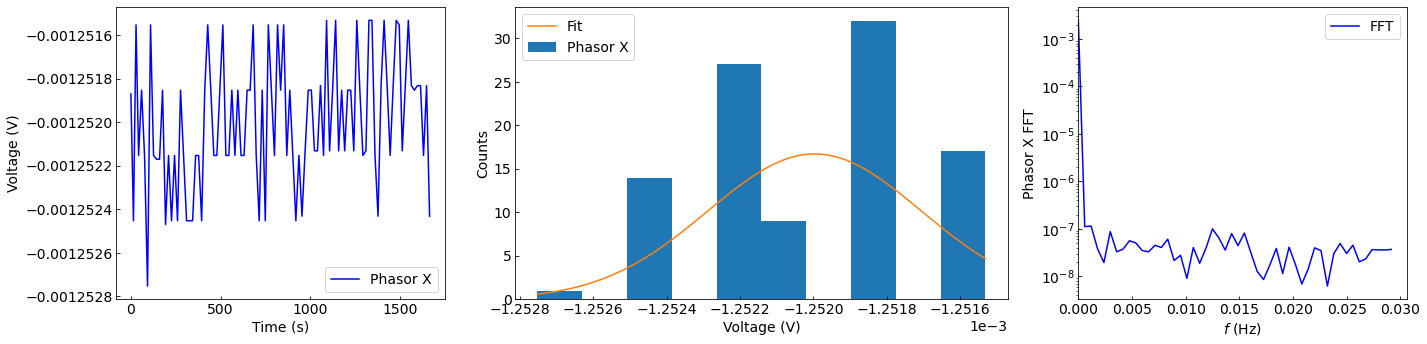


Finished!


In [7]:
#this section sweeps the internal oscillator voltage amplitude
print('Measurement: oscillator voltage sweep characterization')

#save plot pic and data
save_yes = True

#lockin amplifier phasor offset angle
offset = 0

#lockin amplifier internal oscillator frequency
freq = 19

#lockin amplifier time constant
Tc = 1

#set offset angle
offset_att = set_offset(offset)

#set frequency
freq_att = set_freq(freq)

#set time constant
Tc_att = set_Tc(Tc)

sleep(15)

clear_output(wait=True)

#display the number of communication attempts
display = f'Comm attempts: '
display += f'Offset = {offset_att}, '
display += f'Frequency = {freq_att}'
display += f'Tc = {Tc_att}'

#define how many measurements to take for one internal oscillator voltage setting
start = 0
finish = 100 #finish needs to be one further step
step = 1

#dictionary of dataframes
df_V = {}
#tuple of lockin amplifier settings for the corresponding voltage settings
sett_tuple = (0.0000003, 0.000003, 0.000003, 0.00003, 0.00003, 0.0001, 0.0003, 0.003)
#tuple of lockin amplifier internal oscillator voltage settings
V_tuple = (0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5)

#test settings
# V_tuple = (0.1, 1)
# sett_tuple = (0.00003, 0.0003)

#values for determining loop progress
tot_steps = len(V_tuple) * int(finish - start)/step
ct = 0

#outside loop, sets internal oscillator voltage
for w,volt in enumerate(V_tuple):

    #name data files and plot pics for the voltage sequence
    if save_yes == True:
        filename = 'meas_V' + str(volt).replace('.', '_') + '_1.csv'
        plot_pic = 'meas_V' + str(volt).replace('.', '_') + '_1.png'

    #define the dataframes for the voltage sequence
    df_V[str(volt).replace('.', '_')] = pd.DataFrame(columns=['Magnitude', 
                                                               'Phase', 
                                                               'X',
                                                               'Y',
                                                               'V',
                                                               'Frequency',
                                                               'Offset',
                                                               'Noise',
                                                               'Time',
                                                               'Tc',
                                                               'Range',
                                                               'Meas_attempts',
                                                               'Offset_attempts',
                                                               'V_attempts',
                                                               'Freq_attempts',
                                                               'Tc_attempts',
                                                               'Range_attempts'])

    #create the data file with the appropriate column names
    if save_yes == True:
        df_V[str(volt).replace('.', '_')].to_csv(filename, index=False)
        file = open(filename, mode='a', newline='')

    #inside loop, repeated measurement for a particular voltage setting
    for j,x in enumerate(np.arange(start,finish,step)):
        
        #set voltage range and voltage at the beginning of the loop cycle
        if x == start:
            range_att = set_range(sett_tuple[w])
            sleep(1)
            V_att = set_V(volt)
            sleep(30)
        
        sleep(10)

        #collect data
        data = measure(sett_tuple[w])
        
        #relative time start at the beginning of the loop cycle
        if x == start:
            t_o = data["Time"]

        #define a dictionary of all collected data values
        data_dict = {'Magnitude':data["Magnitude"], 
                    'Phase': data["Phase"], 
                    'X': data["Magnitude"] * np.cos(data["Phase"] * np.pi/180),
                    'Y': data["Magnitude"] * np.sin(data["Phase"] * np.pi/180),
                    'V':volt,
                    'Frequency':freq,
                    'Offset':offset,
                    'Noise':data["Noise"],
                    'Time':data["Time"]-t_o,
                    'Tc':Tc,
                    'Range':sett_tuple[w],
                    'Meas_attempts':data["Meas_attempts"],
                    'Offset_attempts':offset_att,
                    'V_attempts':V_att,
                    'Freq_attempts':freq_att,
                    'Tc_attempts':Tc_att,
                    'Range_attempts':range_att}

        #write the data dictionary as one line in a dataframe
        df_V[str(volt).replace('.', '_')] = df_V[str(volt).replace('.', '_')].append(data_dict,ignore_index=True)

        #write the data dictionary as one line in the created file
        if save_yes == True:
            line_write(file, data_dict)
        
        #advance the loop count, display current values and communication attempts
        ct += 1
        clear_output(wait=True)
        display1 = f'V = {volt} V, '
        display1 += f'Measurement sequence {ct}/{tot_steps}, '
        display1 += f'Measurement time: {data_dict["Time"]} (s)'
        display2 = 'Comm attempts: '
        display2 += f'Measurement = {data_dict["Meas_attempts"]}, '
        display2 += f'Voltage = {data_dict["V_attempts"]}, '
        display2 += f'Range = {data_dict["Range_attempts"]}'
        print(display1)
        print(display2)

        #plot the cumulative data, statistics, and frequency analysis for a particular voltage setting
        if x >= start + 3*step:
            plt.rcParams.update({'font.size': 14})
            fig= plt.figure(figsize=(20,5))
            gs = gridspec.GridSpec(1,3, width_ratios=[1,1.5,1])

            #plot phasor real component
            ax1 = plt.subplot(gs[0,0], xlabel='Time (s)', ylabel='Voltage (V)')
            ax1.plot(df_V[str(volt).replace('.', '_')].Time, df_V[str(volt).replace('.', '_')].X, 'b', label='Phasor X')  
            ax1.tick_params(direction='in')
            ax1.legend()
            
            #plot histogram of the phasor real component
            ax2 = plt.subplot(gs[0,1], xlabel='Voltage (V)', ylabel='Counts')
            hist_dat = ax2.hist(df_V[str(volt).replace('.', '_')].X, label='Phasor X')  
            ax2.tick_params(direction='in')

            #calculate and plot a fit of the histogram of the phasor real component
            mean = np.mean(df_V[str(volt).replace('.', '_')].X)
            sigma = np.std(df_V[str(volt).replace('.', '_')].X)
            x = np.linspace(min(df_V[str(volt).replace('.', '_')].X), max(df_V[str(volt).replace('.', '_')].X), 100)
            dx = hist_dat[1][1] - hist_dat[1][0]
            amplitude = (len(df_V[str(volt).replace('.', '_')].X))*dx
            ax2.ticklabel_format(axis='x', style='sci', scilimits=(-1,1000000))
            ax2.plot(x, norm.pdf(x, mean, sigma)*amplitude, label='Fit')
            ax2.legend()
            
            #calculate and plot the fft of the phasor real component
            df_V[str(volt).replace('.', '_')]['Time_rs'] = np.linspace(df_V[str(volt).replace('.', '_')].Time.iloc[0], 
                                                                        df_V[str(volt).replace('.', '_')].Time.iloc[-1], 
                                                                        num=len(df_V[str(volt).replace('.', '_')].Time), endpoint=True)
            lin_model = interp1d(df_V[str(volt).replace('.', '_')].Time, df_V[str(volt).replace('.', '_')].X, kind='linear')
            df_V[str(volt).replace('.', '_')]['X_rs'] = lin_model(df_V[str(volt).replace('.', '_')].Time_rs)

            df_V[str(volt).replace('.', '_')]['fft'] = fft.fft(list(df_V[str(volt).replace('.', '_')].X_rs))

            t_step = np.mean([df_V[str(volt).replace('.', '_')].Time_rs[n] - df_V[str(volt).replace('.', '_')].Time_rs[n-1] 
                              for n,x in enumerate(df_V[str(volt).replace('.', '_')].Time_rs) if n != 0])
            fft_freq_all = fft.fftfreq(len(df_V[str(volt).replace('.', '_')].X), d=t_step)
            fft_freq = [x for n,x in enumerate(fft_freq_all) if x >= 0]

            L = len(df_V[str(volt).replace('.', '_')].fft)
            fft_yaxis = 2.0/(L + 1) * abs(df_V[str(volt).replace('.', '_')].fft[0:(L + 1)//2])
            ax3 = plt.subplot(gs[0,2])
            ax3.plot(fft_freq, fft_yaxis, '-b', label='FFT')
            ax3.set(xlabel='$f$ (Hz)', ylabel='Phasor X FFT')
            ax3.set_yscale("log")
            ax3.tick_params(direction='in')
            ax3.set_xlim(xmin=0)
            ax3.legend()
            
            plt.tight_layout()
            if save_yes == True:
                plt.savefig(plot_pic, dpi=300, bbox_inches = "tight")
            plt.show()
    
    #close the file for each voltage setting
    if save_yes == True:
        file.close()
print()    
print('Finished!')

<a id="Noise-Measurement:-Internal-Oscillator-Frequency-Sweep"></a>

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Import-Packages">Import Packages</a></li>
<li><a href="#Function-Definitions">Function Definitions</a></li>
<li><a href="#Lockin-amplifier-communication">Lockin Amplifier Communication</a></li>
<li><a href="#Noise-Measurement:-Internal-Oscillator-Voltage-Sweep">Noise Measurement: Internal Oscillator Voltage Sweep</a></li>
</ul>
    
## Noise Measurement: Internal Oscillator Frequency Sweep
<ul>
<li><a href="#Noise-Measurement:-Time-Constant-Sweep">Noise Measurement: Time Constant Sweep</a></li>
<li><a href="#Noise-Measurement:-Long-Data-Collection">Noise Measurement: Long Data Collection</a></li>
<li><a href="#Noise-Measurement:-Phasor-Offset-Angle-Sweep">Noise Measurement: Phasor Offset Angle Sweep</a></li>
<li><a href="#Results-and-Analysis">Results and Analysis</a></li>
<li><a href="#Summary">Summary</a></li>
<li><a href="#Python-and-Package-Versions">Python and Package Versions</a></li>
</ul>

Freq = 100 Hz, Measurement sequence 100/100.0, Elapsed time: 4146.461839914322 (s)
Comm attempts: Measurement = 1, Frequency = 2


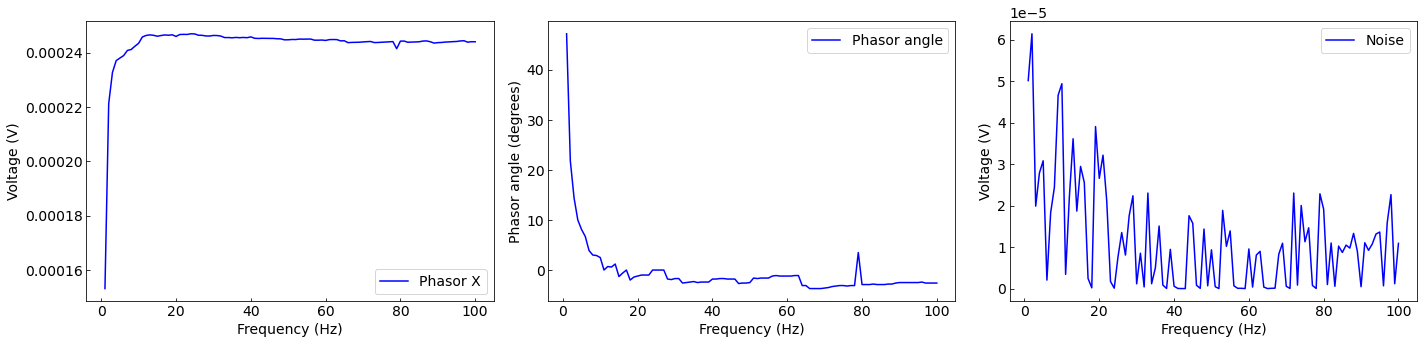


Finished!


In [8]:
#this section sweeps the internal oscillator frequency
print('Measurement: oscillator frequency sweep characterization')

#save plot pic and data
save_yes = True

#name the data file and plot pic
if save_yes == True:
    filename = 'meas_F_1.csv'
    plot_pic = 'meas_F_1.png'

#define the dataframe for the frequency sweep
df_F = pd.DataFrame(columns=['Magnitude', 
                             'Phase', 
                             'X',
                             'Y',
                             'V',
                             'Frequency',
                             'Offset',
                             'Noise',
                             'Time',
                             'Tc',
                             'Range',
                             'Meas_attempts',
                             'Offset_attempts',
                             'V_attempts',
                             'Freq_attempts',
                             'Tc_attempts',
                             'Range_attempts'])

#create the data file with the appropriate column names
if save_yes == True:
    df_F.to_csv(filename, index=False)
    file = open(filename, mode='a', newline='')

#lockin amplifier phasor angle offset
offset = 0

#lockin amplifier internal oscillator voltage
volt = 1

#lockin amplifier time constant
Tc = 1

#lockin amplifier range setting
setting = 0.0003

#set offset angle
offset_att = set_offset(offset)

#set voltage
V_att = set_V(volt)

#set Tc
Tc_att = set_Tc(Tc)

#set range
range_att = set_range(setting)

sleep(15)

clear_output(wait=True)

#display the number of communication attempts
display = f'Comm attempts: '
display += f'Offset = {offset_att}, '
display += f'Voltage = {V_att}, '
display += f'Range = {range_att}, '
display += f'Tc = {Tc_att}'

#define frequency range and step
start = 1
finish = 101 #finish needs to be one further step
step = 1

#values for determining loop progress
tot_steps = int(finish - start)/step
ct = 0

#loop, sets internal oscillator frequency
for f in np.arange(start,finish,step):

    #sets a new frequency at the beginning of every loop
    freq_att = set_freq(f)
    sleep(30)

    #collect data
    data = measure(setting)
    
    #relative time start at the beginning of the loop
    if f == start:
        t_o = data["Time"]

    #define a dictionary of all collected data values
    data_dict = {'Magnitude':data["Magnitude"], 
                'Phase': data["Phase"], 
                'X': data["Magnitude"] * np.cos(data["Phase"] * np.pi/180),
                'Y': data["Magnitude"] * np.sin(data["Phase"] * np.pi/180),
                'V':volt,
                'Frequency':f,
                'Offset':offset,
                'Noise':data["Noise"],
                'Time':data["Time"]-t_o,
                'Tc':Tc,
                'Range':setting,
                'Meas_attempts':data["Meas_attempts"],
                'Offset_attempts':offset_att,
                'V_attempts':V_att,
                'Freq_attempts':freq_att,
                'Tc_attempts':Tc_att,
                'Range_attempts':range_att}

    #write the data dictionary as one line in a dataframe
    df_F = df_F.append(data_dict,ignore_index=True)

    #write the data dictionary as one line in the created file
    if save_yes == True:
        line_write(file, data_dict)

    #advance the loop count, display current values and communication attempts
    ct += 1
    clear_output(wait=True)
    display1 = f'Freq = {f} Hz, '
    display1 += f'Measurement sequence {ct}/{tot_steps}, '
    display1 += f'Elapsed time: {data_dict["Time"]} (s)'
    display2 = 'Comm attempts: '
    display2 += f'Measurement = {data_dict["Meas_attempts"]}, '
    display2 += f'Frequency = {data_dict["Freq_attempts"]}'
    print(display1)
    print(display2)

    #plot the cumulative data and lockin amplifier noise report
    plt.rcParams.update({'font.size': 14})
    fig= plt.figure(figsize=(20,5))
    gs = gridspec.GridSpec(1,3)

    #plot phasor real component
    ax1 = plt.subplot(gs[0,0], xlabel='Frequency (Hz)', ylabel='Voltage (V)')
    ax1.plot(df_F.Frequency, df_F.X, 'b', label='Phasor X')  
    ax1.tick_params(direction='in')
    ax1.legend()
    
    #plot phasor angle
    ax2 = plt.subplot(gs[0,1], xlabel='Frequency (Hz)', ylabel='Phasor angle (degrees)')
    ax2.plot(df_F.Frequency, df_F.Phase, 'b', label='Phasor angle')  
    ax2.tick_params(direction='in')
    ax2.legend()

    #plot lockin amplifier noise report
    ax3 = plt.subplot(gs[0,2], xlabel='Frequency (Hz)', ylabel='Voltage (V)')
    ax3.plot(df_F.Frequency, df_F.Noise, 'b', label='Noise')  
    ax3.tick_params(direction='in')
    ax3.legend()

    plt.tight_layout()
    if save_yes == True:
        plt.savefig(plot_pic, dpi=300, bbox_inches = "tight")
    plt.show()
     
#close the file at the end of the loop
if save_yes == True:
    file.close()
        
print()
print('Finished!')

Freq = 100 Hz, Measurement sequence 100/100.0, Elapsed time: 4191.137558937073 (s)
Comm attempts: Measurement = 1, Frequency = 2


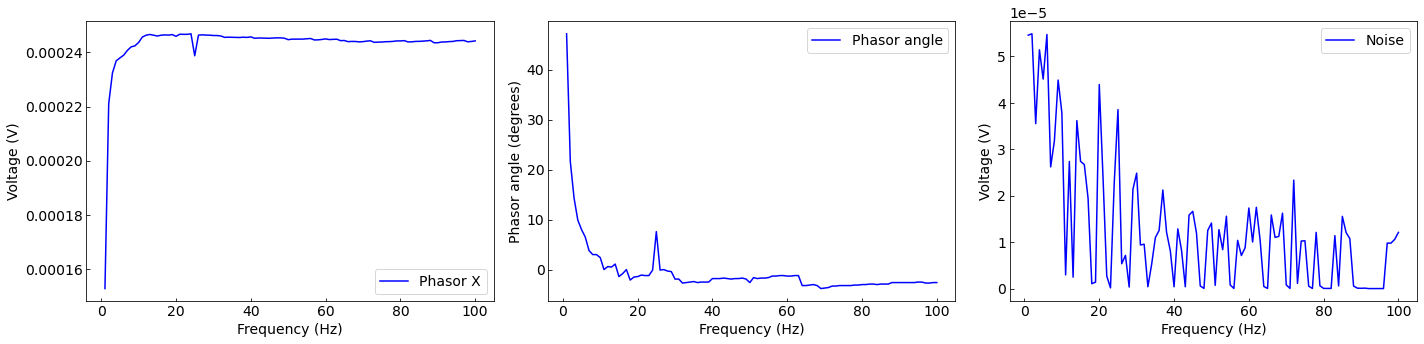


Finished!


In [9]:
#this section sweeps the internal oscillator frequency (second trial)
print('Measurement: oscillator frequency sweep characterization')

#save plot pic and data
save_yes = True

#name the data file and plot pic
if save_yes == True:
        filename = 'meas_F2_1.csv'
        plot_pic = 'meas_F2_1.png'
        
#define the dataframe for the frequency sweep
df_F2 = pd.DataFrame(columns=['Magnitude', 
                              'Phase', 
                              'X',
                              'Y',
                              'V',
                              'Frequency',
                              'Offset',
                              'Noise',
                              'Time',
                              'Tc',
                              'Range',
                              'Meas_attempts',
                              'Offset_attempts',
                              'V_attempts',
                              'Freq_attempts',
                              'Tc_attempts',
                              'Range_attempts'])

#create the data file with the appropriate column names
if save_yes == True:
        df_F2.to_csv(filename, index=False)
        file = open(filename, mode='a', newline='')

#lockin amplifier phasor angle offset
offset = 0

#lockin amplifier internal oscillator voltage
volt = 1

#lockin amplifier time constant
Tc = 1

#lockin amplifier range setting
setting = 0.0003

#set offset angle
offset_att = set_offset(offset)

#set voltage
V_att = set_V(volt)

#set Tc
Tc_att = set_Tc(Tc)

#set range
range_att = set_range(setting)

sleep(15)

clear_output(wait=True)

#display the number of communication attempts
display = f'Comm attempts: '
display += f'Offset = {offset_att}, '
display += f'Voltage = {V_att}, '
display += f'Range = {range_att}, '
display += f'Tc = {Tc_att}'

#define frequency range and step
start = 1
finish = 101 #finish needs to be one further step
step = 1

#values for determining loop progress
tot_steps = int(finish - start)/step
ct = 0

#loop, sets internal oscillator frequency
for f in np.arange(start,finish,step):

    #sets a new frequency at the beginning of every loop
    freq_att = set_freq(f)
    sleep(30)

    #collect data
    data = measure(setting)
    
    #relative time start at the beginning of the loop
    if f == start:
        t_o = data["Time"]

    #define a dictionary of all collected data values
    data_dict = {'Magnitude':data["Magnitude"], 
                'Phase': data["Phase"], 
                'X': data["Magnitude"] * np.cos(data["Phase"] * np.pi/180),
                'Y': data["Magnitude"] * np.sin(data["Phase"] * np.pi/180),
                'V':volt,
                'Frequency':f,
                'Offset':offset,
                'Noise':data["Noise"],
                'Time':data["Time"]-t_o,
                'Tc':Tc,
                'Range':setting,
                'Meas_attempts':data["Meas_attempts"],
                'Offset_attempts':offset_att,
                'V_attempts':V_att,
                'Freq_attempts':freq_att,
                'Tc_attempts':Tc_att,
                'Range_attempts':range_att}

    #write the data dictionary as one line in a dataframe
    df_F2 = df_F2.append(data_dict,ignore_index=True)

    #write the data dictionary as one line in the created file
    if save_yes == True:
        line_write(file, data_dict)

    #advance the loop count, display current values and communication attempts
    ct += 1
    clear_output(wait=True)
    display1 = f'Freq = {f} Hz, '
    display1 += f'Measurement sequence {ct}/{tot_steps}, '
    display1 += f'Elapsed time: {data_dict["Time"]} (s)'
    display2 = 'Comm attempts: '
    display2 += f'Measurement = {data_dict["Meas_attempts"]}, '
    display2 += f'Frequency = {data_dict["Freq_attempts"]}'
    print(display1)
    print(display2)

    #plot the cumulative data and lockin amplifier noise report
    plt.rcParams.update({'font.size': 14})
    fig= plt.figure(figsize=(20,5))
    gs = gridspec.GridSpec(1,3)

    #plot phasor real component
    ax1 = plt.subplot(gs[0,0], xlabel='Frequency (Hz)', ylabel='Voltage (V)')
    ax1.plot(df_F2.Frequency, df_F2.X, 'b', label='Phasor X')  
    ax1.tick_params(direction='in')
    ax1.legend()
    
    #plot phasor angle
    ax2 = plt.subplot(gs[0,1], xlabel='Frequency (Hz)', ylabel='Phasor angle (degrees)')
    ax2.plot(df_F2.Frequency, df_F2.Phase, 'b', label='Phasor angle')  
    ax2.tick_params(direction='in')
    ax2.legend()

    #plot lockin amplifier noise report
    ax3 = plt.subplot(gs[0,2], xlabel='Frequency (Hz)', ylabel='Voltage (V)')
    ax3.plot(df_F2.Frequency, df_F2.Noise, 'b', label='Noise')  
    ax3.tick_params(direction='in')
    ax3.legend()

    plt.tight_layout()
    if save_yes == True:
        plt.savefig(plot_pic, dpi=300, bbox_inches = "tight")
    plt.show()
       
#close the file at the end of the loop
if save_yes == True:
    file.close()
        
print()
print('Finished!')

<a id="Noise-Measurement:-Time-Constant-Sweep"></a><!--Notebook author: Drew Rebar-->

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Import-Packages">Import Packages</a></li>
<li><a href="#Function-Definitions">Function Definitions</a></li>
<li><a href="#Lockin-amplifier-communication">Lockin Amplifier Communication</a></li>
<li><a href="#Noise-Measurement:-Internal-Oscillator-Voltage-Sweep">Noise Measurement: Internal Oscillator Voltage Sweep</a></li>
<li><a href="#Noise-Measurement:-Internal-Oscillator-Frequency-Sweep">Noise Measurement: Internal Oscillator Frequency Sweep</a></li>
</ul>
    
## Noise Measurement: Time Constant Sweep
<ul>
<li><a href="#Noise-Measurement:-Long-Data-Collection">Noise Measurement: Long Data Collection</a></li>
<li><a href="#Noise-Measurement:-Phasor-Offset-Angle-Sweep">Noise Measurement: Phasor Offset Angle Sweep</a></li>
<li><a href="#Results-and-Analysis">Results and Analysis</a></li>
<li><a href="#Summary">Summary</a></li>
<li><a href="#Python-and-Package-Versions">Python and Package Versions</a></li>
</ul>

Tc = 30 seconds, Measurement sequence 1000/1000.0, Elapsed time: 15537.515293836594 (s)
Comm attempts: Measurement = 1, Tc = 1


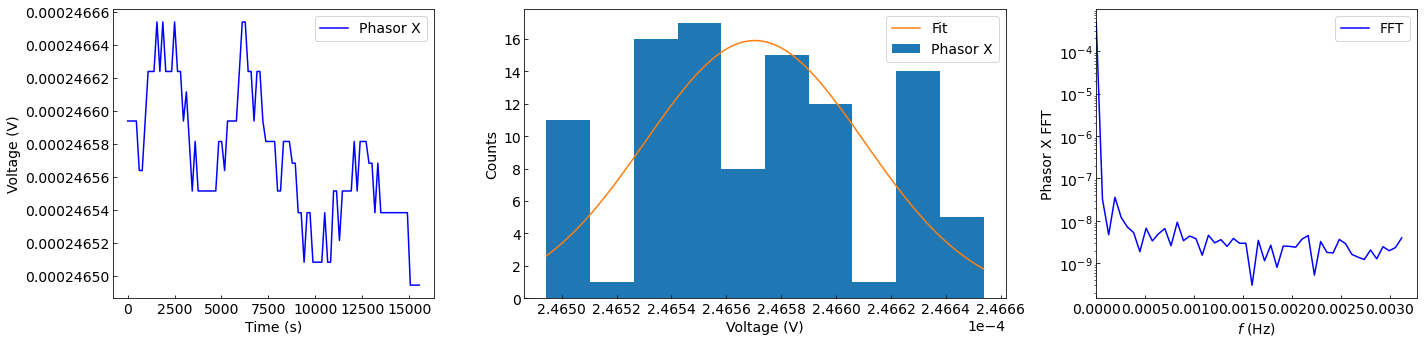


Finished!


In [10]:
#this section sweeps the time constant
print('Measurement: time constant characterization')

#save plot pic and data
save_yes = True

#lockin amplifier phasor angle offset
offset = 0

#lockin amplifier internal oscillator voltage
volt = 1

#lockin amplifier internal oscillator frequency
freq = 19

#lockin amplifier range setting
setting = 0.0003

#set offset angle
offset_att = set_offset(offset)

#set internal oscillator voltage
V_att = set_V(volt)

#set internal oscillator frequency
freq_att = set_freq(freq)

#set range
range_att = set_range(setting)

sleep(15)

clear_output(wait=True)

#display the number of communication attempts
display = f'Comm attempts: '
display += f'Offset = {offset_att}, '
display += f'Voltage = {V_att}, '
display += f'Frequency = {freq_att}, '
display += f'Range = {range_att}'

#define how many measurements to take for one time constant setting
start = 0
finish = 100 #finish needs to be one further step
step = 1

#dictionary of dataframes
df_Tc = {}
#tuple of time constant settings
Tc_tuple = (0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30)

#test settings
# Tc_tuple = (1, 3)

#values for determining loop progress
tot_steps = len(Tc_tuple) * int(finish - start)/step
ct = 0

#outside loop, sets time constant
for Tc in Tc_tuple:

    #name data files and plot pics for the time constant sequence
    if save_yes == True:
        filename = 'meas_Tc' + str(Tc).replace('.', '_') + '_1.csv'
        plot_pic = 'meas_Tc' + str(Tc).replace('.', '_') + '_1.png'

    #define the dataframes for the time constant sequence
    df_Tc[str(Tc).replace('.', '_')] = pd.DataFrame(columns=['Magnitude', 
                                                             'Phase', 
                                                             'X',
                                                             'Y',
                                                             'V',
                                                             'Frequency',
                                                             'Offset',
                                                             'Noise',
                                                             'Time',
                                                             'Tc',
                                                             'Range',
                                                             'Meas_attempts',
                                                             'Offset_attempts',
                                                             'V_attempts',
                                                             'Freq_attempts',
                                                             'Tc_attempts',
                                                             'Range_attempts'])

    #create the data file with the appropriate column names
    if save_yes == True:
        df_Tc[str(Tc).replace('.', '_')].to_csv(filename, index=False)
        file = open(filename, mode='a', newline='')

    #inside loop, repeated measurement for a particular time constant setting
    for x in np.arange(start,finish,step):
        
        #set the time constant at the beginning of the loop cycle
        if x == start:
            Tc_att = set_Tc(Tc)
            if Tc < 5:
                sleep(30)
            else:
                sleep(180)
        
        #adjust wait time for the larger time constants
        if Tc < 1 and x != start:
            sleep(5)
        elif Tc >= 1 and x != start:
            sleep(5*Tc)

        #collect data
        data = measure(setting)
        
        #relative time start at the beginning of the loop cycle
        if x == start:
            t_o = data["Time"]
 
        #define a dictionary of all collected data values
        data_dict = {'Magnitude':data["Magnitude"], 
                    'Phase': data["Phase"], 
                    'X': data["Magnitude"] * np.cos(data["Phase"] * np.pi/180),
                    'Y': data["Magnitude"] * np.sin(data["Phase"] * np.pi/180),
                    'V':volt,
                    'Frequency':freq,
                    'Offset':offset,
                    'Noise':data["Noise"],
                    'Time':data["Time"]-t_o,
                    'Tc':Tc,
                    'Range':setting,
                    'Meas_attempts':data["Meas_attempts"],
                    'Offset_attempts':offset_att,
                    'V_attempts':V_att,
                    'Freq_attempts':freq_att,
                    'Tc_attempts':Tc_att,
                    'Range_attempts':range_att}

        #write the data dictionary as one line in a dataframe
        df_Tc[str(Tc).replace('.', '_')] = df_Tc[str(Tc).replace('.', '_')].append(data_dict,ignore_index=True)

        #write the data dictionary as one line in the created file
        if save_yes == True:
            line_write(file, data_dict)
        
        #advance the loop count, display current values and communication attempts
        ct += 1
        clear_output(wait=True)
        display1 = f'Tc = {Tc} seconds, '
        display1 += f'Measurement sequence {ct}/{tot_steps}, '
        display1 += f'Elapsed time: {data_dict["Time"]} (s)'
        display2 = 'Comm attempts: '
        display2 += f'Measurement = {data_dict["Meas_attempts"]}, '
        display2 += f'Tc = {data_dict["Tc_attempts"]}'
        print(display1)
        print(display2)

        #plot the cumulative data, statistics, and frequency analysis for a particular time constant setting
        if x >= start + 3*step:
            plt.rcParams.update({'font.size': 14})
            fig= plt.figure(figsize=(20,5))
            gs = gridspec.GridSpec(1,3, width_ratios=[1,1.5,1])

            #plot phasor real component
            ax1 = plt.subplot(gs[0,0], xlabel='Time (s)', ylabel='Voltage (V)')
            ax1.plot(df_Tc[str(Tc).replace('.', '_')].Time, df_Tc[str(Tc).replace('.', '_')].X, 'b', label='Phasor X')  
            ax1.tick_params(direction='in')
            ax1.legend()

            #plot histogram of the phasor real component
            ax2 = plt.subplot(gs[0,1], xlabel='Voltage (V)', ylabel='Counts')
            hist_dat = ax2.hist(df_Tc[str(Tc).replace('.', '_')].X, label='Phasor X')  
            ax2.tick_params(direction='in')

            #calculate and plot a fit of the histogram of the phasor real component
            mean = np.mean(df_Tc[str(Tc).replace('.', '_')].X)
            sigma = np.std(df_Tc[str(Tc).replace('.', '_')].X)
            x = np.linspace(min(df_Tc[str(Tc).replace('.', '_')].X), max(df_Tc[str(Tc).replace('.', '_')].X), 100)
            dx = hist_dat[1][1] - hist_dat[1][0]
            amplitude = (len(df_Tc[str(Tc).replace('.', '_')].X))*dx
            ax2.ticklabel_format(axis='x', style='sci', scilimits=(-1,1000000))
            ax2.plot(x, norm.pdf(x, mean, sigma)*amplitude, label='Fit')
            ax2.legend()

            #calculate and plot the fft of the phasor real component
            df_Tc[str(Tc).replace('.', '_')]['Time_rs'] = np.linspace(df_Tc[str(Tc).replace('.', '_')].Time.iloc[0], 
                                                                        df_Tc[str(Tc).replace('.', '_')].Time.iloc[-1], 
                                                                        num=len(df_Tc[str(Tc).replace('.', '_')].Time), endpoint=True)
            lin_model = interp1d(df_Tc[str(Tc).replace('.', '_')].Time, df_Tc[str(Tc).replace('.', '_')].X, kind='linear')
            df_Tc[str(Tc).replace('.', '_')]['X_rs'] = lin_model(df_Tc[str(Tc).replace('.', '_')].Time_rs)

            df_Tc[str(Tc).replace('.', '_')]['fft'] = fft.fft(list(df_Tc[str(Tc).replace('.', '_')].X_rs))

            t_step = np.mean([df_Tc[str(Tc).replace('.', '_')].Time_rs[n] - df_Tc[str(Tc).replace('.', '_')].Time_rs[n-1] 
                              for n,x in enumerate(df_Tc[str(Tc).replace('.', '_')].Time_rs) if n != 0])
            fft_freq_all = fft.fftfreq(len(df_Tc[str(Tc).replace('.', '_')].X), d=t_step)
            fft_freq = [x for n,x in enumerate(fft_freq_all) if x >= 0]

            L = len(df_Tc[str(Tc).replace('.', '_')].fft)
            fft_yaxis = 2.0/(L + 1) * abs(df_Tc[str(Tc).replace('.', '_')].fft[0:(L + 1)//2])
            ax3 = plt.subplot(gs[0,2])
            ax3.plot(fft_freq, fft_yaxis, '-b', label='FFT')
            ax3.set(xlabel='$f$ (Hz)', ylabel='Phasor X FFT')
            ax3.set_yscale("log")
            ax3.tick_params(direction='in')
            ax3.set_xlim(xmin=0)
            ax3.legend()

            plt.tight_layout()
            if save_yes == True:
                plt.savefig(plot_pic, dpi=300, bbox_inches = "tight")
            plt.show()
            
    #close the file for each time constant setting
    if save_yes == True:
        file.close()
print()    
print('Finished!')

<a id="Noise-Measurement:-Long-Data-Collection"></a>

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Import-Packages">Import Packages</a></li>
<li><a href="#Function-Definitions">Function Definitions</a></li>
<li><a href="#Lockin-amplifier-communication">Lockin Amplifier Communication</a></li>
<li><a href="#Noise-Measurement:-Internal-Oscillator-Voltage-Sweep">Noise Measurement: Internal Oscillator Voltage Sweep</a></li>
<li><a href="#Noise-Measurement:-Internal-Oscillator-Frequency-Sweep">Noise Measurement: Internal Oscillator Frequency Sweep</a></li>
<li><a href="#Noise-Measurement:-Time-Constant-Sweep">Noise Measurement: Time Constant Sweep</a></li>
</ul>
    
## Noise Measurement: Long Data Collection
<ul>
<li><a href="#Noise-Measurement:-Phasor-Offset-Angle-Sweep">Noise Measurement: Phasor Offset Angle Sweep</a></li>
<li><a href="#Results-and-Analysis">Results and Analysis</a></li>
<li><a href="#Summary">Summary</a></li>
<li><a href="#Python-and-Package-Versions">Python and Package Versions</a></li>
</ul>

Phasor X = 0.0002466238075827562 V, Measurement sequence 1000/1000.0, Elapsed time: 12184.890089511871 (s)
Comm attempts: Measurement = 1


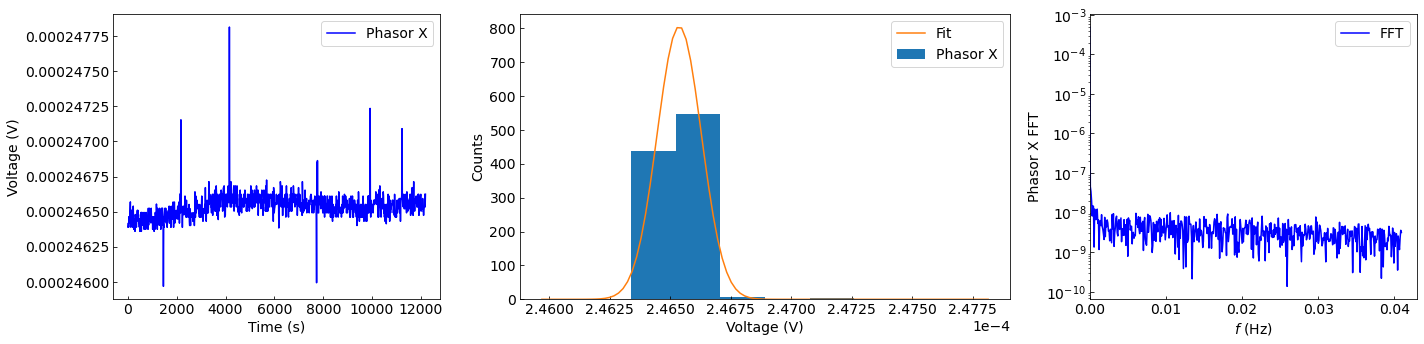


Finished!


In [11]:
#this section collects data for a long period of time with the same settings
print('Measurement: long data characterization')

#save plot pic and data
save_yes = True

#name the data file and plot pic
if save_yes == True:
    filename = 'LongTime_1.csv'
    plot_pic = 'LongTime_1.png'

#define the dataframe for the long data collection
df_LT = pd.DataFrame(columns=['Magnitude', 
                              'Phase', 
                              'X',
                              'Y',
                              'V',
                              'Frequency',
                              'Offset',
                              'Noise',
                              'Time',
                              'Tc',
                              'Range',
                              'Meas_attempts',
                              'Offset_attempts',
                              'V_attempts',
                              'Freq_attempts',
                              'Tc_attempts',
                              'Range_attempts'])

#create the data file with the appropriate column names
if save_yes == True:
    df_LT.to_csv(filename, index=False)
    file = open(filename, mode='a', newline='')

#lockin amplifier phasor angle offset
offset = 0

#lockin amplifier internal oscillator voltage
volt = 1

#lockin amplifier range setting
setting = 0.0003

#lockin amplifier internal oscillator frequency
freq = 19

#lockin amplifier time constant
Tc = 1

#set offset angle
offset_att = set_offset(offset)

#set frequency
freq_att = set_freq(freq)

#set Tc
Tc_att = set_Tc(Tc)

#set range
range_att = set_range(setting)

#set voltage
V_att = set_V(volt)

sleep(15)

clear_output(wait=True)

#display the number of communication attempts
display = f'Comm attempts: '
display += f'Voltage = {V_att}, '
display += f'Frequency = {freq_att}, '
display += f'Tc = {Tc_att}, '
display += f'Offset = {offset_att}, '
display += f'Range = {range_att}'
print(display)

#define how many measurements to take
start = 0
finish = 1000 #finish needs to be one further step
step = 1

#values for determining loop progress
tot_steps = int(finish - start)/step
ct = 0

#loop, simple repetitive measurement
for w in np.arange(start, finish, step):

    #extra wait time on the first loop
    if w == start:
        sleep(40)
    sleep(5)

    #collect data
    data = measure(setting)
    
    #relative time start at the beginning of the loop
    if w == start:
        t_o = data["Time"]

    #define a dictionary of all collected data values
    data_dict = {'Magnitude':data["Magnitude"], 
                'Phase': data["Phase"], 
                'X': data["Magnitude"] * np.cos(data["Phase"] * np.pi/180),
                'Y': data["Magnitude"] * np.sin(data["Phase"] * np.pi/180),
                'V':volt,
                'Frequency':freq,
                'Offset':offset,
                'Noise':data["Noise"],
                'Time':data["Time"]-t_o,
                'Tc':Tc,
                'Range':setting,
                'Meas_attempts':data["Meas_attempts"],
                'Offset_attempts':offset_att,
                'V_attempts':V_att,
                'Freq_attempts':freq_att,
                'Tc_attempts':Tc_att,
                'Range_attempts':range_att}

    #write the data dictionary as one line in a dataframe
    df_LT = df_LT.append(data_dict,ignore_index=True)

    #write the data dictionary as one line in the created file
    if save_yes == True:
        line_write(file, data_dict)

    #advance the loop count, display current values and communication attempts
    ct += 1
    clear_output(wait=True)
    display1 = f'Phasor X = {data_dict["X"]} V, '
    display1 += f'Measurement sequence {ct}/{tot_steps}, '
    display1 += f'Elapsed time: {data_dict["Time"]} (s)'
    display2 = 'Comm attempts: '
    display2 += f'Measurement = {data_dict["Meas_attempts"]}'
    print(display1)
    print(display2)

    #plot the cumulative data, statistics, and frequency analysis for the long data collection
    if w >= start + 3*step:
        plt.rcParams.update({'font.size': 14})
        fig= plt.figure(figsize=(20,5))
        gs = gridspec.GridSpec(1,3, width_ratios=[1,1.5,1])

        #plot phasor real component
        ax1 = plt.subplot(gs[0,0], xlabel='Time (s)', ylabel='Voltage (V)')
        ax1.plot(df_LT.Time, df_LT.X, 'b', label='Phasor X')  
        ax1.tick_params(direction='in')
        ax1.legend()

        #plot histogram of the phasor real component
        ax2 = plt.subplot(gs[0,1], xlabel='Voltage (V)', ylabel='Counts')
        hist_dat = ax2.hist(df_LT.X, label='Phasor X')  
        ax2.tick_params(direction='in')

        #calculate and plot a fit of the histogram of the phasor real component
        mean = np.mean(df_LT.X)
        sigma = np.std(df_LT.X)
        x_ax = np.linspace(min(df_LT.X), max(df_LT.X), 100)
        dx = hist_dat[1][1] - hist_dat[1][0]
        amplitude = (len(df_LT.X))*dx
        ax2.ticklabel_format(axis='x', style='sci', scilimits=(-1,1000000))
        ax2.plot(x_ax, norm.pdf(x_ax, mean, sigma)*amplitude, label='Fit')
        ax2.legend()

        #calculate and plot the fft of the phasor real component
        df_LT['Time_rs'] = np.linspace(df_LT.Time.iloc[0], 
                                       df_LT.Time.iloc[-1], 
                                       num=len(df_LT.Time), endpoint=True)
        lin_model = interp1d(df_LT.Time, df_LT.X, kind='linear')
        df_LT['X_rs'] = lin_model(df_LT.Time_rs)

        df_LT['fft'] = fft.fft(list(df_LT.X_rs))

        t_step = np.mean([df_LT.Time_rs[n] - df_LT.Time_rs[n-1] 
                          for n,x in enumerate(df_LT.Time_rs) if n != 0])
        fft_freq_all = fft.fftfreq(len(df_LT.X), d=t_step)
        fft_freq = [x for n,x in enumerate(fft_freq_all) if x >= 0]

        L = len(df_LT.fft)
        fft_yaxis = 2.0/(L + 1) * abs(df_LT.fft[0:(L + 1)//2])
        ax3 = plt.subplot(gs[0,2])
        ax3.plot(fft_freq, fft_yaxis, '-b', label='FFT')
        ax3.set(xlabel='$f$ (Hz)', ylabel='Phasor X FFT')
        ax3.set_yscale("log")
        ax3.tick_params(direction='in')
        ax3.set_xlim(xmin=0)
        ax3.legend()

        plt.tight_layout()
        if save_yes == True:
            plt.savefig(plot_pic, dpi=300, bbox_inches = "tight")
        plt.show()
            
#close the file for the long data collection
if save_yes == True:
    file.close()
print()    
print('Finished!')

<a id="Noise-Measurement:-Phasor-Offset-Angle-Sweep"></a>

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Import-Packages">Import Packages</a></li>
<li><a href="#Function-Definitions">Function Definitions</a></li>
<li><a href="#Lockin-amplifier-communication">Lockin Amplifier Communication</a></li>
<li><a href="#Noise-Measurement:-Internal-Oscillator-Voltage-Sweep">Noise Measurement: Internal Oscillator Voltage Sweep</a></li>
<li><a href="#Noise-Measurement:-Internal-Oscillator-Frequency-Sweep">Noise Measurement: Internal Oscillator Frequency Sweep</a></li>
<li><a href="#Noise-Measurement:-Time-Constant-Sweep">Noise Measurement: Time Constant Sweep</a></li>
<li><a href="#Noise-Measurement:-Long-Data-Collection">Noise Measurement: Long Data Collection</a></li>
</ul>
    
## Noise Measurement: Phasor Offset Angle Sweep
<ul>
<li><a href="#Results-and-Analysis">Results and Analysis</a></li>
<li><a href="#Summary">Summary</a></li>
<li><a href="#Python-and-Package-Versions">Python and Package Versions</a></li>
</ul>

Offset angle = 91 degrees, Phasor X = -1.2040491259222758e-05 V, Measurement sequence 360/360, Elapsed time: 15218.841291427612 (s)
Comm attempts: Measurement = 1, Offset = 1


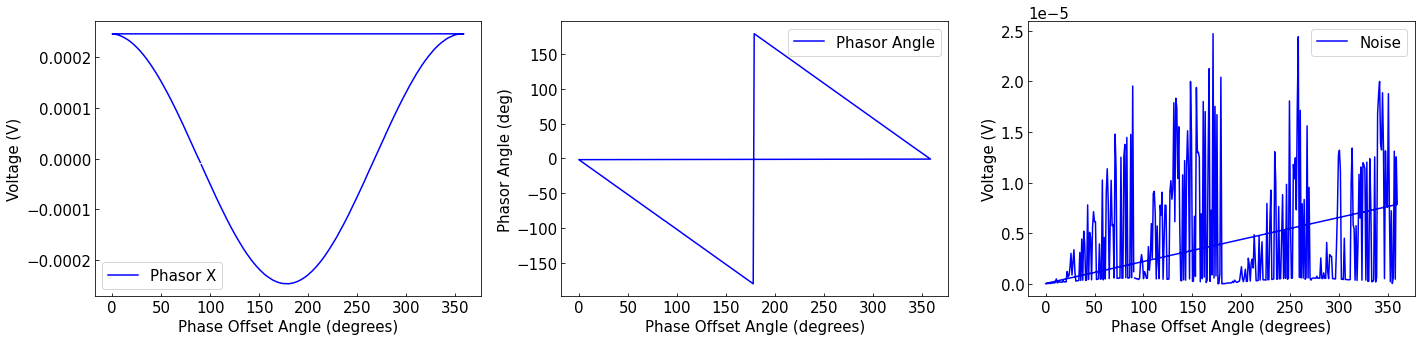


Finished!


In [33]:
#this section sweeps the phasor offset angle of the lockin amplifier
print('Measurement: phasor offset angle sweep')

#save plot pic and data
save_yes = True

#name the data file and plot pic
if save_yes == True:
    filename = 'Offset_sweep_1.csv'
    plot_pic = 'Offset_sweep_1.png'

#define the dataframe for the offset angle sweep
df_Off = pd.DataFrame(columns=['Magnitude', 
                              'Phase', 
                              'X',
                              'Y',
                              'V',
                              'Frequency',
                              'Offset',
                              'Noise',
                              'Time',
                              'Tc',
                              'Range',
                              'Meas_attempts',
                              'Offset_attempts',
                              'V_attempts',
                              'Freq_attempts',
                              'Tc_attempts',
                              'Range_attempts'])

#create the data file with the appropriate column names
if save_yes == True:
    df_Off.to_csv(filename, index=False)
    file = open(filename, mode='a', newline='')

#lockin amplifier internal oscillator voltage
volt = 1

#lockin amplifier range setting
setting = 0.0003

#lockin amplifier internal oscillator frequency
freq = 19

#lockin amplifier time constant
Tc = 1

#set frequency
freq_att = set_freq(freq)

#set Tc
Tc_att = set_Tc(Tc)

#set range
range_att = set_range(setting)

#set voltage
V_att = set_V(volt)

sleep(15)

clear_output(wait=True)

#display the number of communication attempts
display = f'Comm attempts: '
display += f'Voltage = {V_att}, '
display += f'Frequency = {freq_att}, '
display += f'Tc = {Tc_att}, '
display += f'Range = {range_att}'
print(display)

#custom phasor offset angle sweep
off_seq = []

# start at 90 degrees and sweep clockwise
for p in range(90,-1, -1):
    off_seq.append(p)
for p in range(359,90, -1):
    off_seq.append(p)

#test data
# off_seq = [18,19,20]
# start = 18

#values for determining loop progress
tot_steps = len(off_seq)
ct = 0

#loop, sets phasor angle offset
for angle in off_seq:

    #set offset angle
    offset_att = set_offset(angle)

    sleep(30)

    #collect data
    data = measure(setting)
    
    #relative time start at the beginning of the loop
    if ct == 0:
        t_o = data["Time"]

    #define a dictionary of all collected data values
    data_dict = {'Magnitude':data["Magnitude"], 
                'Phase': data["Phase"], 
                'X': data["Magnitude"] * np.cos(data["Phase"] * np.pi/180),
                'Y': data["Magnitude"] * np.sin(data["Phase"] * np.pi/180),
                'V':volt,
                'Frequency':freq,
                'Offset':angle,
                'Noise':data["Noise"],
                'Time':data["Time"]-t_o,
                'Tc':Tc,
                'Range':setting,
                'Meas_attempts':data["Meas_attempts"],
                'Offset_attempts':offset_att,
                'V_attempts':V_att,
                'Freq_attempts':freq_att,
                'Tc_attempts':Tc_att,
                'Range_attempts':range_att}
    
    #write the data dictionary as one line in a dataframe
    df_Off = df_Off.append(data_dict,ignore_index=True)

    #write the data dictionary as one line in the created file
    if save_yes == True:
        line_write(file, data_dict)
        
    #advance the loop count, display current values and communication attempts
    ct += 1
    clear_output(wait=True)
    display1 = f'Offset angle = {angle} degrees, '
    display1 += f'Phasor X = {data_dict["X"]} V, '
    display1 += f'Measurement sequence {ct}/{tot_steps}, '
    display1 += f'Elapsed time: {data_dict["Time"]} (s)'
    display2 = 'Comm attempts: '
    display2 += f'Measurement = {data_dict["Meas_attempts"]}, '
    display2 += f'Offset = {data_dict["Offset_attempts"]}'
    print(display1)
    print(display2)
        
    #plot the cumulative data and lockin amplifier noise report
    plt.rcParams.update({'font.size': 15})
    fig= plt.figure(figsize=(20,5))
    gs = gridspec.GridSpec(1,3)

    #plot phasor real component
    ax1 = plt.subplot(gs[0,0], xlabel='Phase Offset Angle (degrees)', ylabel='Voltage (V)')
    ax1.plot(df_Off.Offset, df_Off.X, 'b', label='Phasor X')  
    ax1.tick_params(direction='in')
    ax1.legend()
    
    #plot phasor angle
    ax2 = plt.subplot(gs[0,1], xlabel='Phase Offset Angle (degrees)', ylabel='Phasor Angle (deg)')
    ax2.plot(df_Off.Offset, df_Off.Phase, 'b', label='Phasor Angle') 
    ax2.tick_params(direction='in')
    ax2.legend()

    #plot lockin amplifier noise report
    ax3 = plt.subplot(gs[0,2], xlabel='Phase Offset Angle (degrees)', ylabel='Voltage (V)')
    ax3.plot(df_Off.Offset, df_Off.Noise, 'b', label='Noise') 
    ax3.tick_params(direction='in')
    ax3.legend()

    plt.tight_layout()
    if save_yes == True:
        plt.savefig(plot_pic, dpi=300, bbox_inches = "tight")
    plt.show()
     
#close the file at the end of the loop
if save_yes == True:
    file.close()
print()    
print('Finished!')

<a id="Results-and-Analysis"></a><a id="Results-and-Analysis:-Internal-Oscillator-Voltage-Sweep"></a>

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Import-Packages">Import Packages</a></li>
<li><a href="#Function-Definitions">Function Definitions</a></li>
<li><a href="#Lockin-amplifier-communication">Lockin Amplifier Communication</a></li>
<li><a href="#Noise-Measurement:-Internal-Oscillator-Voltage-Sweep">Noise Measurement: Internal Oscillator Voltage Sweep</a></li>
<li><a href="#Noise-Measurement:-Internal-Oscillator-Frequency-Sweep">Noise Measurement: Internal Oscillator Frequency Sweep</a></li>
<li><a href="#Noise-Measurement:-Time-Constant-Sweep">Noise Measurement: Time Constant Sweep</a></li>
<li><a href="#Noise-Measurement:-Long-Data-Collection">Noise Measurement: Long Data Collection</a></li>
<li><a href="#Noise-Measurement:-Phasor-Offset-Angle-Sweep">Noise Measurement: Phasor Offset Angle Sweep</a></li>
</ul>

## Results and Analysis

>### Results and Analysis: Internal Oscillator Voltage Sweep
<ul><ul>
<li><a href="#Results-and-Analysis:-Internal-Oscillator-Frequency-Sweep">Results and Analysis: Internal Oscillator Frequency Sweep</a></li>
<li><a href="#Results-and-Analysis:-Time-Constant-Sweep">Results and Analysis: Time Constant Sweep</a></li>
<li><a href="#Results-and-Analysis:-Long-Data-Collection">Results and Analysis: Long Data Collection</a></li>
<li><a href="#Results-and-Analysis:-Phasor-Offset-Angle-Sweep">Results and Analysis: Phasor Offset Angle Sweep</a></li>
</ul></ul>

<ul>
<li><a href="#Summary">Summary</a></li>
<li><a href="#Python-and-Package-Versions">Python and Package Versions</a></li>
</ul>

In [ ]:
# #read data files (csv) if needed
# pd.read_csv('meas_F_test.csv')

# df_V = {}
# V_tuple = (0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5)

# for w,volt in enumerate(V_tuple):

#     df_V[str(volt).replace('.', '_')] = pd.read_csv('meas_V' + str(volt).replace('.', '_') + '_test.csv')


In [13]:
#reminder of the key names
df_V.keys()

dict_keys(['0_001', '0_005', '0_01', '0_05', '0_1', '0_5', '1', '5'])

In [14]:
#for the 5 V setting, the real component swung negative (~180 degree phase angle)
#for comparison with the other voltages, the real component is plotted as positive
df_V['5'].X = -1 * df_V['5'].X

In [15]:
#calculation of resistance is needed for comparison since the internal oscillator voltage value is changed per sweep
for key in df_V.keys():
    df_V[key]['R'] = V2R(df_V[key]['V'],df_V[key]['X'])

Results: Internal Oscillator Voltage Sweep


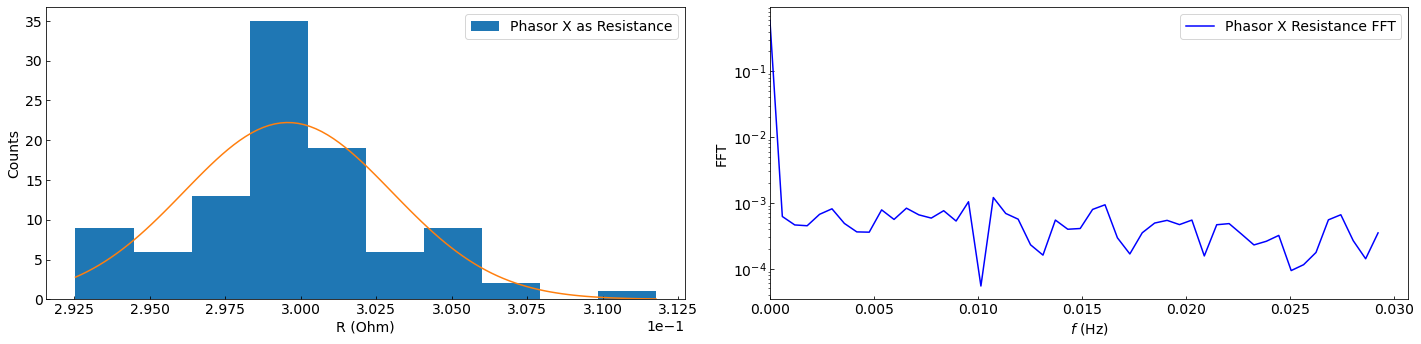

Internal oscillator voltage = 0.001
Total measurement time = 1659.338392496109 seconds
Average time step = 16.76099386359706 seconds
Total data points = 100
Lockin amplifier range setting = 3e-07
Mean resistance = 0.2995790059479051 Ohm
Mean phasor angle = -1.925 degrees
Maximum histogram bin =  0.29831188680722703 Ohm
Max histogram bin - mean resistance =  -0.0012671191406780635 Ohm
Resistance standard deviation =  0.0034505352359114542 Ohm
Phasor X mean =  3.031256921162956e-07 V
Phasor X standard deviation =  3.4903232499468787e-09 V
Noise mean =  4.6475999999999995e-09 V
Noise (mean) / phasor X standard deviation =  1.3315672123121358
Signal (X mean) to noise ratio =  36.28788009046342 dB
Signal (X mean) to standard deviation ratio =  38.7751419468123 dB


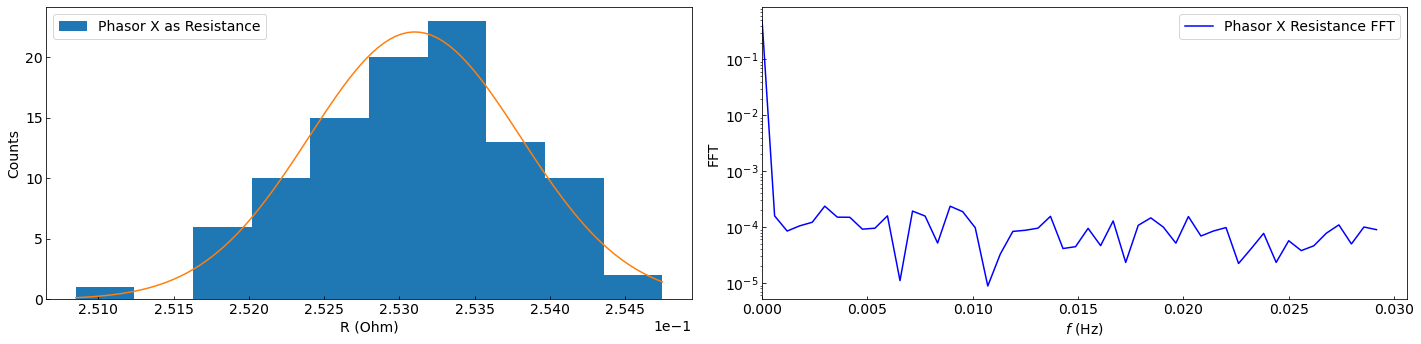

Internal oscillator voltage = 0.005
Total measurement time = 1663.5400054454803 seconds
Average time step = 16.803434398439194 seconds
Total data points = 100
Lockin amplifier range setting = 3e-06
Mean resistance = 0.2531018181763391 Ohm
Mean phasor angle = -1.2599999999999993 degrees
Maximum histogram bin =  0.2531871964776805 Ohm
Max histogram bin - mean resistance =  8.53783013414211e-05 Ohm
Resistance standard deviation =  0.0007032145120150555 Ohm
Phasor X mean =  1.2805515976141378e-06 V
Phasor X standard deviation =  3.5569560654813565e-09 V
Noise mean =  4.8869999999999985e-09 V
Noise (mean) / phasor X standard deviation =  1.3739275689756516
Signal (X mean) to noise ratio =  48.367094865492525 dB
Signal (X mean) to standard deviation ratio =  51.1263716273381 dB


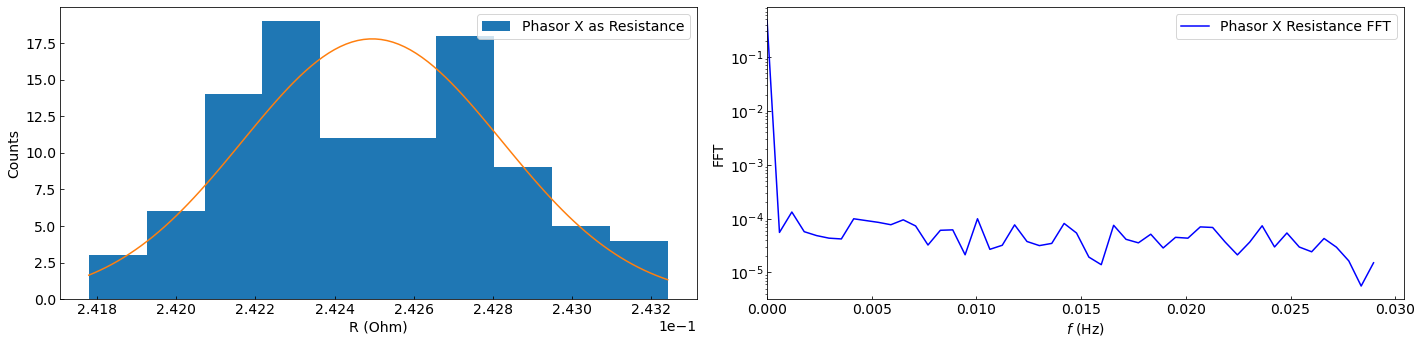

Internal oscillator voltage = 0.01
Total measurement time = 1674.7228944301605 seconds
Average time step = 16.916392873031924 seconds
Total data points = 100
Lockin amplifier range setting = 3e-06
Mean resistance = 0.24249497099586115 Ohm
Mean phasor angle = -1.2439999999999998 degrees
Maximum histogram bin =  0.24221799152423176 Ohm
Max histogram bin - mean resistance =  -0.00027697947162938497 Ohm
Resistance standard deviation =  0.00032794017130398633 Ohm
Phasor X mean =  2.453800277979147e-06 V
Phasor X standard deviation =  3.3176035303352526e-09 V
Noise mean =  5.847e-09 V
Noise (mean) / phasor X standard deviation =  1.7624167404382842
Signal (X mean) to noise ratio =  52.458122349742226 dB
Signal (X mean) to standard deviation ratio =  57.38029453651659 dB


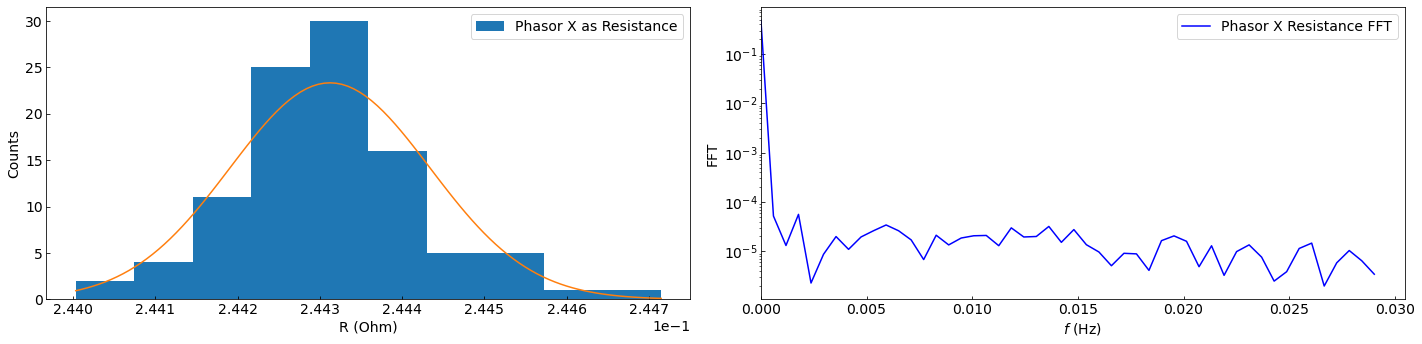

Internal oscillator voltage = 0.05
Total measurement time = 1671.116997718811 seconds
Average time step = 16.879969673927384 seconds
Total data points = 100
Lockin amplifier range setting = 3e-05
Mean resistance = 0.24431221558573676 Ohm
Mean phasor angle = -1.1850000000000007 degrees
Maximum histogram bin =  0.24428783568973597 Ohm
Max histogram bin - mean resistance =  -2.4379896000792378e-05 Ohm
Resistance standard deviation =  0.00012166105424747645 Ohm
Phasor X mean =  1.2360921917325755e-05 V
Phasor X standard deviation =  6.153891794334168e-09 V
Noise mean =  1.2300000000000022e-08 V
Noise (mean) / phasor X standard deviation =  1.9987351762220649
Signal (X mean) to noise ratio =  60.04291503202205 dB
Signal (X mean) to standard deviation ratio =  66.05802014775746 dB


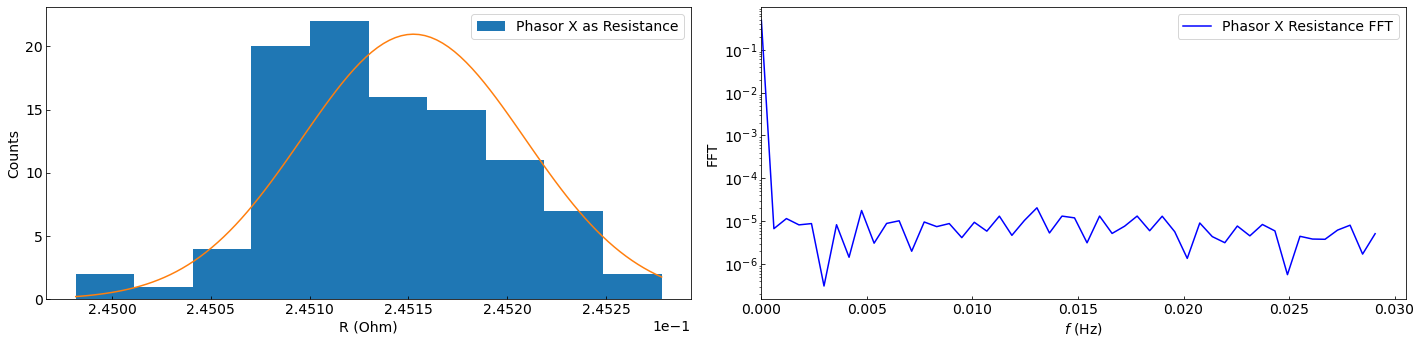

Internal oscillator voltage = 0.1
Total measurement time = 1668.1971583366394 seconds
Average time step = 16.850476346834743 seconds
Total data points = 100
Lockin amplifier range setting = 3e-05
Mean resistance = 0.2451524624518128 Ohm
Mean phasor angle = -1.1990000000000018 degrees
Maximum histogram bin =  0.24510019571181732 Ohm
Max histogram bin - mean resistance =  -5.226673999547682e-05 Ohm
Resistance standard deviation =  5.644556406529092e-05 Ohm
Phasor X mean =  2.480684694862737e-05 V
Phasor X standard deviation =  5.710279644536318e-09 V
Noise mean =  1.7160000000000026e-08 V
Noise (mean) / phasor X standard deviation =  3.005106766779622
Signal (X mean) to noise ratio =  63.201085673365554 dB
Signal (X mean) to standard deviation ratio =  72.75828380180153 dB


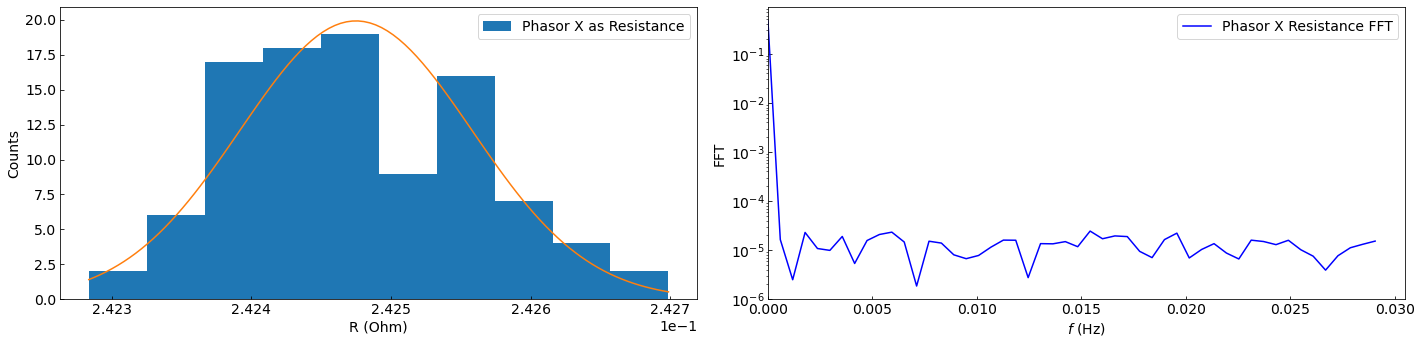

Internal oscillator voltage = 0.5
Total measurement time = 1669.2750084400177 seconds
Average time step = 16.86136372161634 seconds
Total data points = 100
Lockin amplifier range setting = 0.0001
Mean resistance = 0.24247492910507237 Ohm
Mean phasor angle = -1.1840000000000008 degrees
Maximum histogram bin =  0.24244965339755611 Ohm
Max histogram bin - mean resistance =  -2.527570751625907e-05 Ohm
Resistance standard deviation =  8.314080671673098e-05 Ohm
Phasor X mean =  0.00012267987626997829 V
Phasor X standard deviation =  4.205466126065816e-08 V
Noise mean =  9.259999999999976e-08 V
Noise (mean) / phasor X standard deviation =  2.201896228008057
Signal (X mean) to noise ratio =  62.44324685233345 dB
Signal (X mean) to standard deviation ratio =  69.29918380203772 dB


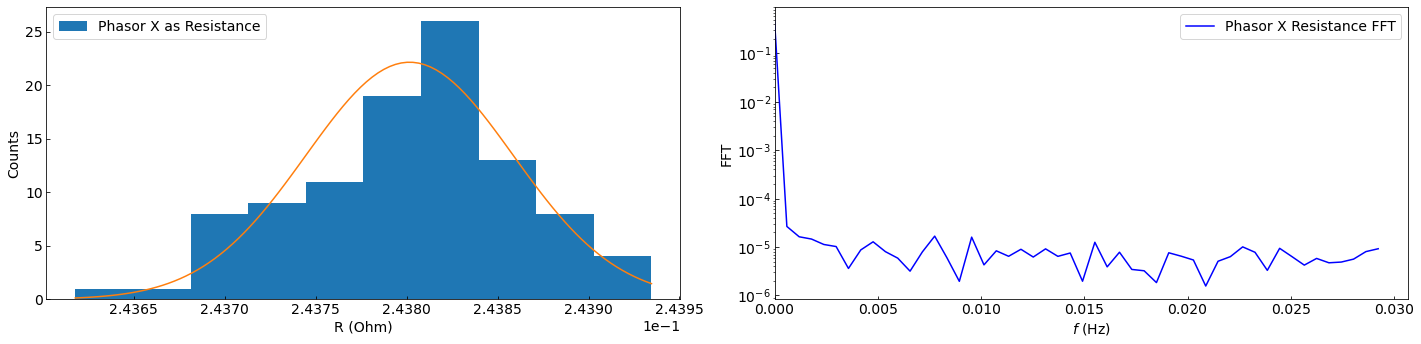

Internal oscillator voltage = 1.0
Total measurement time = 1659.6014988422394 seconds
Average time step = 16.763651503456963 seconds
Total data points = 100
Lockin amplifier range setting = 0.0003
Mean resistance = 0.24380159874300297 Ohm
Mean phasor angle = -1.2320000000000002 degrees
Maximum histogram bin =  0.2438078899617399 Ohm
Max histogram bin - mean resistance =  6.291218736936832e-06 Ohm
Resistance standard deviation =  5.7074660644345676e-05 Ohm
Phasor X mean =  0.00024670187492731484 V
Phasor X standard deviation =  5.773937690716833e-08 V
Noise mean =  1.2329999999999965e-07 V
Noise (mean) / phasor X standard deviation =  2.135457751791083
Signal (X mean) to noise ratio =  66.02418747064806 dB
Signal (X mean) to standard deviation ratio =  72.61400714469205 dB


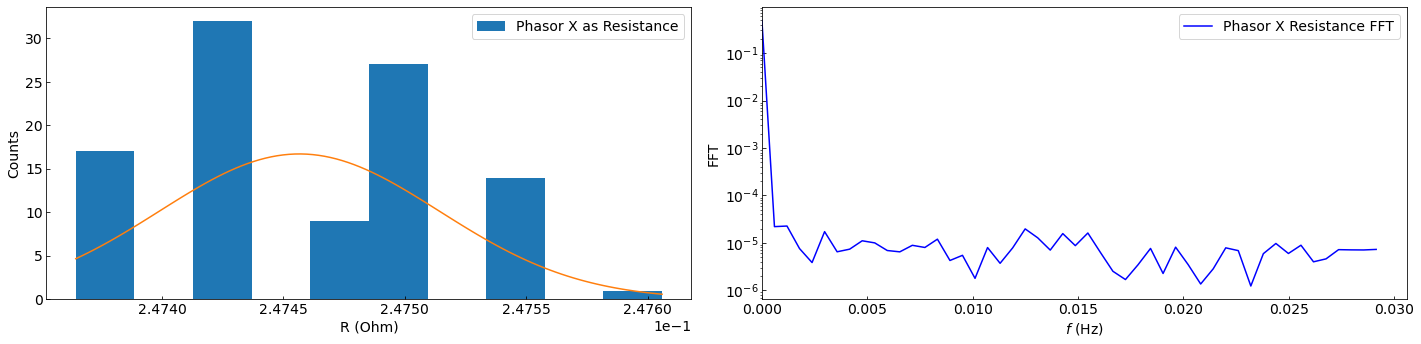

Internal oscillator voltage = 5.0
Total measurement time = 1664.6060647964478 seconds
Average time step = 16.814202674711595 seconds
Total data points = 100
Lockin amplifier range setting = 0.003
Mean resistance = 0.24745655625452634 Ohm
Mean phasor angle = 179.475 degrees
Maximum histogram bin =  0.24741279145082745 Ohm
Max histogram bin - mean resistance =  -4.376480369888691e-05 Ohm
Resistance standard deviation =  5.762270224194623e-05 Ohm
Phasor X mean =  0.0012519969295619493 V
Phasor X standard deviation =  2.9146684352000516e-07 V
Noise mean =  3.183000000000004e-06 V
Noise (mean) / phasor X standard deviation =  10.920624663715945
Signal (X mean) to noise ratio =  51.89533250353559 dB
Signal (X mean) to standard deviation ratio =  72.66028212117708 dB

Analysis: Internal Oscillator Voltage Sweep



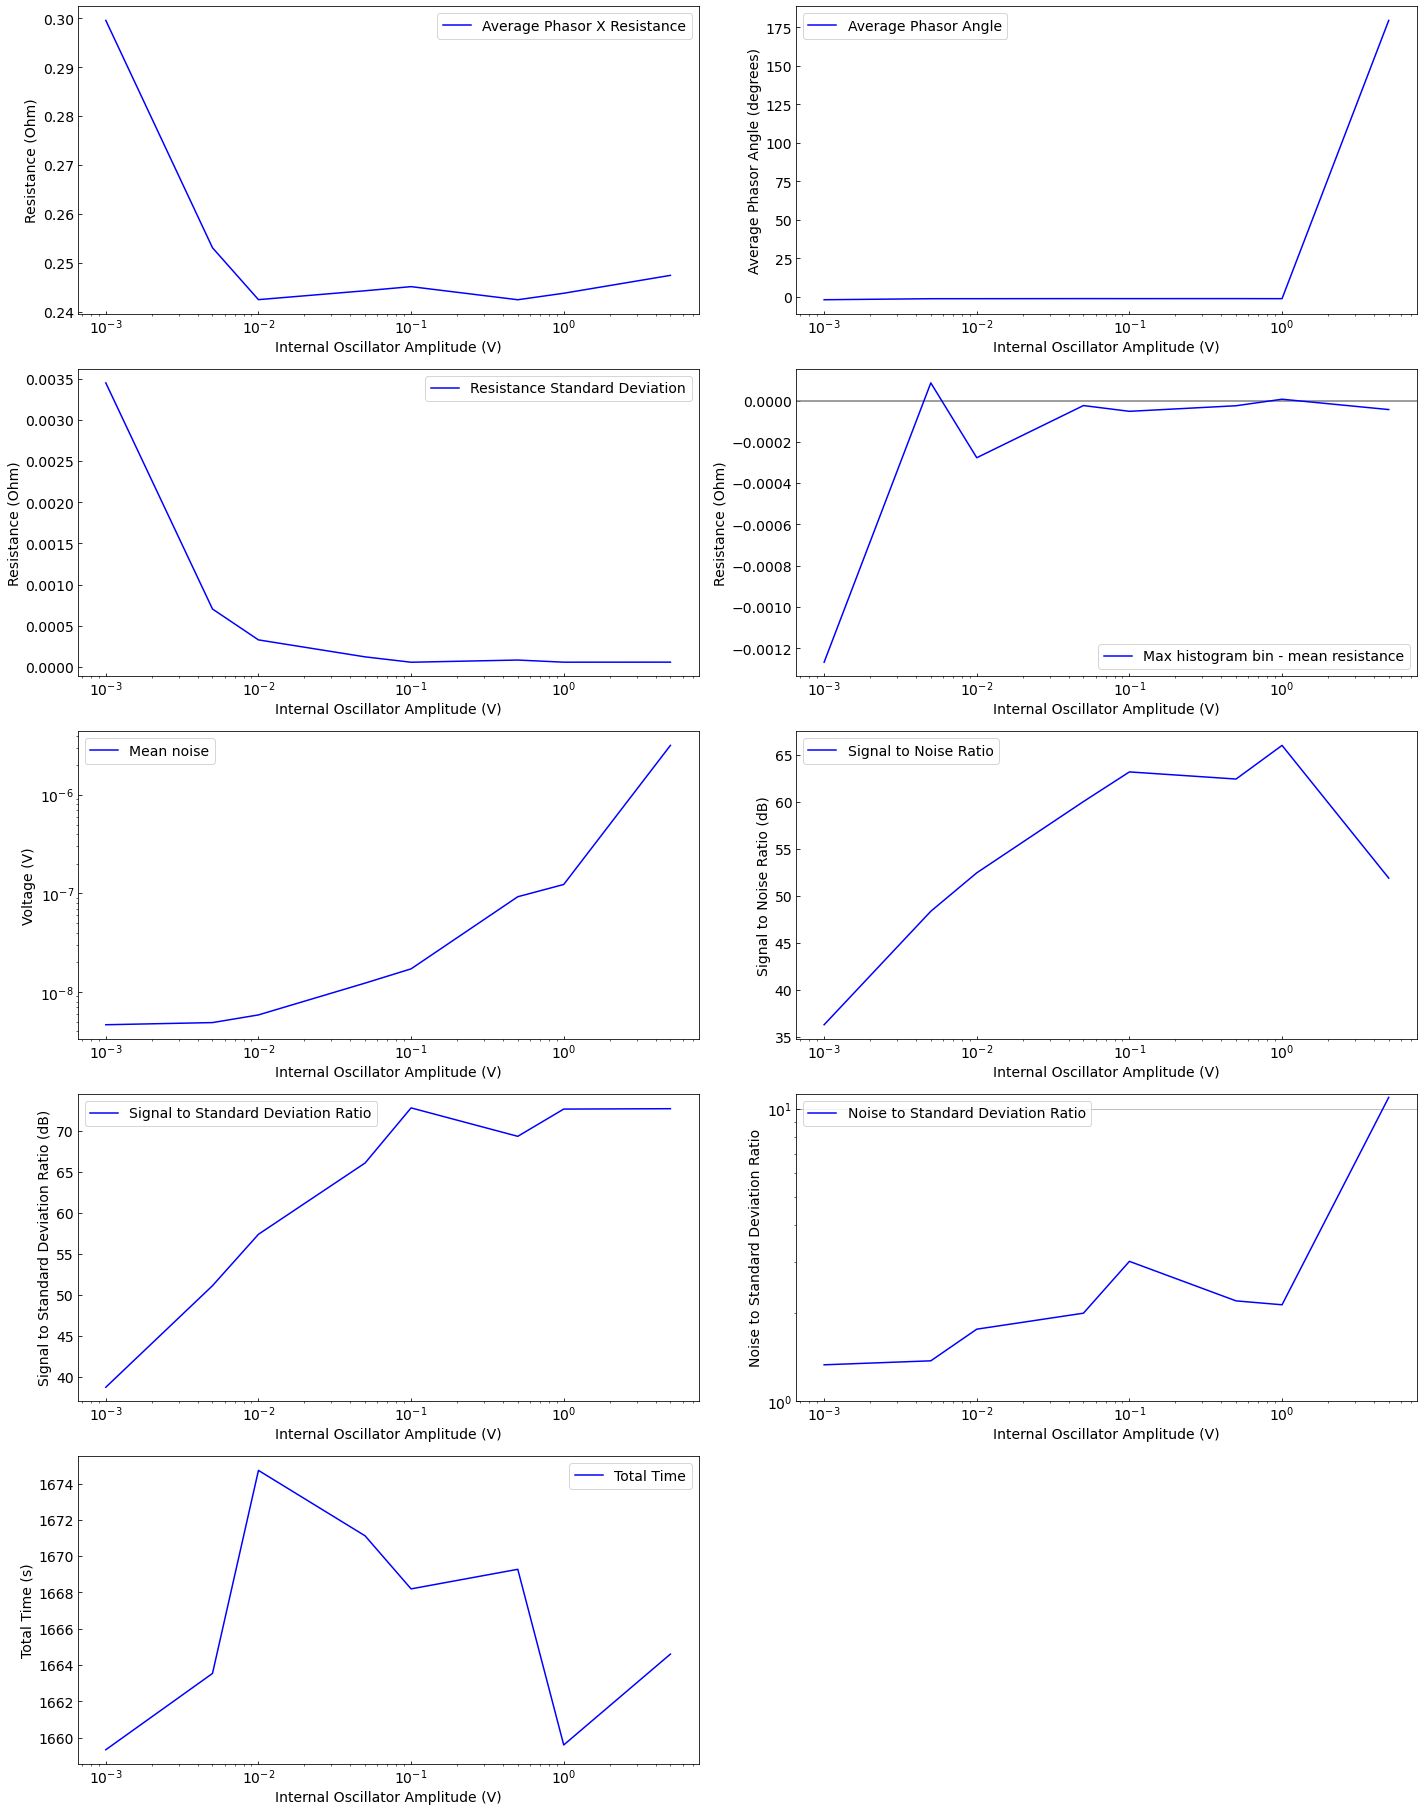

In [18]:
#internal oscillator voltage sweep analysis

#save plot pics
save_yes = True

#plot pic names
plot_pic1a = 'V_sweep_analysis_'
plot_pic2 = 'V_sweep_summary.png'

#lists that will be necessary for analysis of all the voltage sweeps
vAmp = []
Rav = []
Rstr = []
SNR = []
SstrR = []
N2strR = []
tot_t = []
histmeanDiff = []
noiseMean = []
Rphase = []

print('Results: Internal Oscillator Voltage Sweep')

#plot the data, statistics, and frequency analysis for every voltage setting
for q,key in enumerate(df_V.keys()):
    
    #unique plot pic name for every voltage sweep
    plot_pic1b = plot_pic1a + key + '.png'
    
    plt.rcParams.update({'font.size': 14})
    fig= plt.figure(figsize=(20,5))
    gs = gridspec.GridSpec(1,2)
    
    #plot histogram of resistance calculated from phasor real component
    ax1 = plt.subplot(gs[0,0], xlabel='R (Ohm)', ylabel='Counts')
    hist_dat = ax1.hist(df_V[key].R, label='Phasor X as Resistance')  
    ax1.tick_params(direction='in')

    #calculate and plot a fit of the histogram of the resistance
    mean = np.mean(df_V[key].R)
    sigma = np.std(df_V[key].R)
    x_ax = np.linspace(min(df_V[key].R), max(df_V[key].R), 100)
    dx = hist_dat[1][1] - hist_dat[1][0]
    amplitude = (len(df_V[key].R))*dx
    ax1.ticklabel_format(axis='x', style='sci', scilimits=(-1,1000000))
    ax1.plot(x_ax, norm.pdf(x_ax, mean, sigma)*amplitude)
    ax1.legend()
    
    #calculate and plot the fft of the resistance
    df_V[key]['Time_rs'] = np.linspace(df_V[key].Time.iloc[0], 
                                          df_V[key].Time.iloc[-1], 
                                          num=len(df_V[key].Time), endpoint=True)
    lin_model = interp1d(df_V[key].Time, df_V[key].R, kind='linear')
    df_V[key]['R_rs'] = lin_model(df_V[key].Time_rs)

    df_V[key]['fft'] = fft.fft(list(df_V[key].R_rs))

    t_step = np.mean([df_V[key].Time_rs[n] - df_V[key].Time_rs[n-1] 
                      for n,x in enumerate(df_V[key].Time_rs) if n != 0])
    fft_freq_all = fft.fftfreq(len(df_V[key].R), d=t_step)
    fft_freq = [x for n,x in enumerate(fft_freq_all) if x >= 0]

    L = len(df_V[key].fft)
    fft_yaxis = 2.0/(L + 1) * abs(df_V[key].fft[0:(L + 1)//2])
    ax2 = plt.subplot(gs[0,1])
    ax2.plot(fft_freq, fft_yaxis, '-b', label='Phasor X Resistance FFT')
    ax2.set(xlabel='$f$ (Hz)', ylabel='FFT')
    ax2.set_yscale("log")
    ax2.tick_params(direction='in')
    ax2.set_xlim(xmin=0)
    ax2.legend()
    
    plt.tight_layout()
    if save_yes == True:
        plt.savefig(plot_pic1b, dpi=300, bbox_inches = "tight")
    plt.show()
    
    #calculations involving signal, uncertainty, and noise
    sig2noise = 20*np.log10(np.mean(df_V[key].X)/np.mean(df_V[key].Noise))
    sig2str = 20*np.log10(np.mean(df_V[key].X)/np.std(df_V[key].X))
    nois2str = np.mean(df_V[key].Noise)/np.std(df_V[key].X)
    histmean = hist_dat[1][list(hist_dat[0]).index(max(hist_dat[0]))] - mean
    nmean = np.mean(df_V[key].Noise)
    phaMean = np.mean(df_V[key].Phase)
    
    #assemble the calculations for plots
    vAmp.append(df_V[key].V[0])
    Rav.append(mean)
    Rphase.append(phaMean)
    Rstr.append(sigma)
    histmeanDiff.append(histmean)
    noiseMean.append(nmean)
    SNR.append(sig2noise)
    SstrR.append(sig2str)
    N2strR.append(nois2str)
    tot_t.append(list(df_V[key].Time)[-1])
    
    #display the unique settings, data, and calculations for a particular internal oscillator voltage sweep
    print('Internal oscillator voltage =',df_V[key].V[0])
    print('Total measurement time =',list(df_V[key].Time)[-1],'seconds')
    print('Average time step =', t_step, 'seconds')
    print('Total data points =',len(df_V[key].R))
    print('Lockin amplifier range setting =', df_V[key].Range[0])
    print('Mean resistance =', mean, 'Ohm')
    print('Mean phasor angle =', phaMean, 'degrees')
    print('Maximum histogram bin = ', hist_dat[1][list(hist_dat[0]).index(max(hist_dat[0]))], 'Ohm')
    print('Max histogram bin - mean resistance = ', histmean, 'Ohm')
    print('Resistance standard deviation = ', sigma, 'Ohm')
    print('Phasor X mean = ', np.mean(df_V[key].X), 'V')
    print('Phasor X standard deviation = ', np.std(df_V[key].X), 'V')
    print('Noise mean = ', nmean, 'V')
    print('Noise (mean) / phasor X standard deviation = ', nois2str)
    print('Signal (X mean) to noise ratio = ', sig2noise, 'dB')
    print('Signal (X mean) to standard deviation ratio = ', sig2str, 'dB')
    
print()
print('Analysis: Internal Oscillator Voltage Sweep')
print()
    
#plot the calculated values for each voltage sweep as a function of the internal oscillator voltage
plt.rcParams.update({'font.size': 14})
fig= plt.figure(figsize=(20,50))
gs = gridspec.GridSpec(10,2)

#plot average resistance
ax1 = plt.subplot(gs[0,0], xlabel='Internal Oscillator Amplitude (V)', ylabel='Resistance (Ohm)')
ax1.set_xscale("log")
ax1.plot(vAmp, Rav, 'b', label='Average Phasor X Resistance')  
ax1.tick_params(direction='in')
ax1.legend()

#plot average phasor angle
ax2 = plt.subplot(gs[0,1], xlabel='Internal Oscillator Amplitude (V)', ylabel='Average Phasor Angle (degrees)')
ax2.set_xscale("log")
ax2.plot(vAmp, Rphase, 'b', label='Average Phasor Angle')  
ax2.tick_params(direction='in')
ax2.legend()

#plot resistance standard deviation
ax3 = plt.subplot(gs[1,0], xlabel='Internal Oscillator Amplitude (V)', ylabel='Resistance (Ohm)')
ax3.set_xscale("log")
ax3.plot(vAmp, Rstr, 'b', label='Resistance Standard Deviation')  
ax3.tick_params(direction='in')
ax3.legend()

#plot difference between mean and mode
ax4 = plt.subplot(gs[1,1], xlabel='Internal Oscillator Amplitude (V)', ylabel='Resistance (Ohm)')
ax4.set_xscale("log")
ax4.axhline(y=0, c='grey')
ax4.plot(vAmp, histmeanDiff, 'b', label='Max histogram bin - mean resistance')  
ax4.tick_params(direction='in')
ax4.legend()

#plot average noise
ax5 = plt.subplot(gs[2,0], xlabel='Internal Oscillator Amplitude (V)', ylabel='Voltage (V)')
ax5.set_xscale("log")
ax5.set_yscale("log")
ax5.plot(vAmp, noiseMean, 'b', label='Mean noise')  
ax5.tick_params(direction='in')
ax5.legend()

#plot signal (mean X) to noise (mean noise) ratio in decibels
ax6 = plt.subplot(gs[2,1], xlabel='Internal Oscillator Amplitude (V)', ylabel='Signal to Noise Ratio (dB)')
ax6.set_xscale("log")
ax6.plot(vAmp, SNR, 'b', label='Signal to Noise Ratio')  
ax6.tick_params(direction='in')
ax6.legend()

#plot signal (mean X) to standard deviation (X, one entire sweep) ratio in decibels
ax7 = plt.subplot(gs[3,0], xlabel='Internal Oscillator Amplitude (V)', ylabel='Signal to Standard Deviation Ratio (dB)')
ax7.set_xscale("log")
ax7.plot(vAmp, SstrR, 'b', label='Signal to Standard Deviation Ratio')  
ax7.tick_params(direction='in')
ax7.legend()

#plot noise (mean noise) to standard deviation (X, one entire sweep) ratio, not in decibels
ax8 = plt.subplot(gs[3,1], xlabel='Internal Oscillator Amplitude (V)', ylabel='Noise to Standard Deviation Ratio')
ax8.set_xscale("log")
ax8.set_yscale("log")
ax8.grid(axis='y')
ax8.yaxis.set_ticks([1,10])
ax8.set_ylim(ymin=1)
ax8.plot(vAmp, N2strR, 'b', label='Noise to Standard Deviation Ratio')  
ax8.tick_params(direction='in')
ax8.legend()

#plot sweep times
ax9 = plt.subplot(gs[4,0], xlabel='Internal Oscillator Amplitude (V)', ylabel='Total Time (s)')
ax9.set_xscale("log")
ax9.plot(vAmp, tot_t, 'b', label='Total Time')  
ax9.tick_params(direction='in')
ax9.legend()

plt.tight_layout()
if save_yes == True:
    plt.savefig(plot_pic2, dpi=300, bbox_inches = "tight")
plt.show()

<a id="Results-and-Analysis:-Internal-Oscillator-Frequency-Sweep"></a>

## Results and Analysis

<ul><ul>
<li><a href="#Results-and-Analysis:-Internal-Oscillator-Voltage-Sweep">Results and Analysis: Internal Oscillator Voltage Sweep</a></li>
</ul></ul>

>### Results and Analysis: Internal Oscillator Frequency Sweep</a></li>
<ul><ul>
<li><a href="#Results-and-Analysis:-Time-Constant-Sweep">Results and Analysis: Time Constant Sweep</a></li>
<li><a href="#Results-and-Analysis:-Long-Data-Collection">Results and Analysis: Long Data Collection</a></li>
<li><a href="#Results-and-Analysis:-Phasor-Offset-Angle-Sweep">Results and Analysis: Phasor Offset Angle Sweep</a></li>
</ul></ul>

In [ ]:
# #read data files (csv) if needed
# df_F = pd.read_csv('meas_F_test.csv')
# df_F2 = pd.read_csv('meas_F2_test.csv')

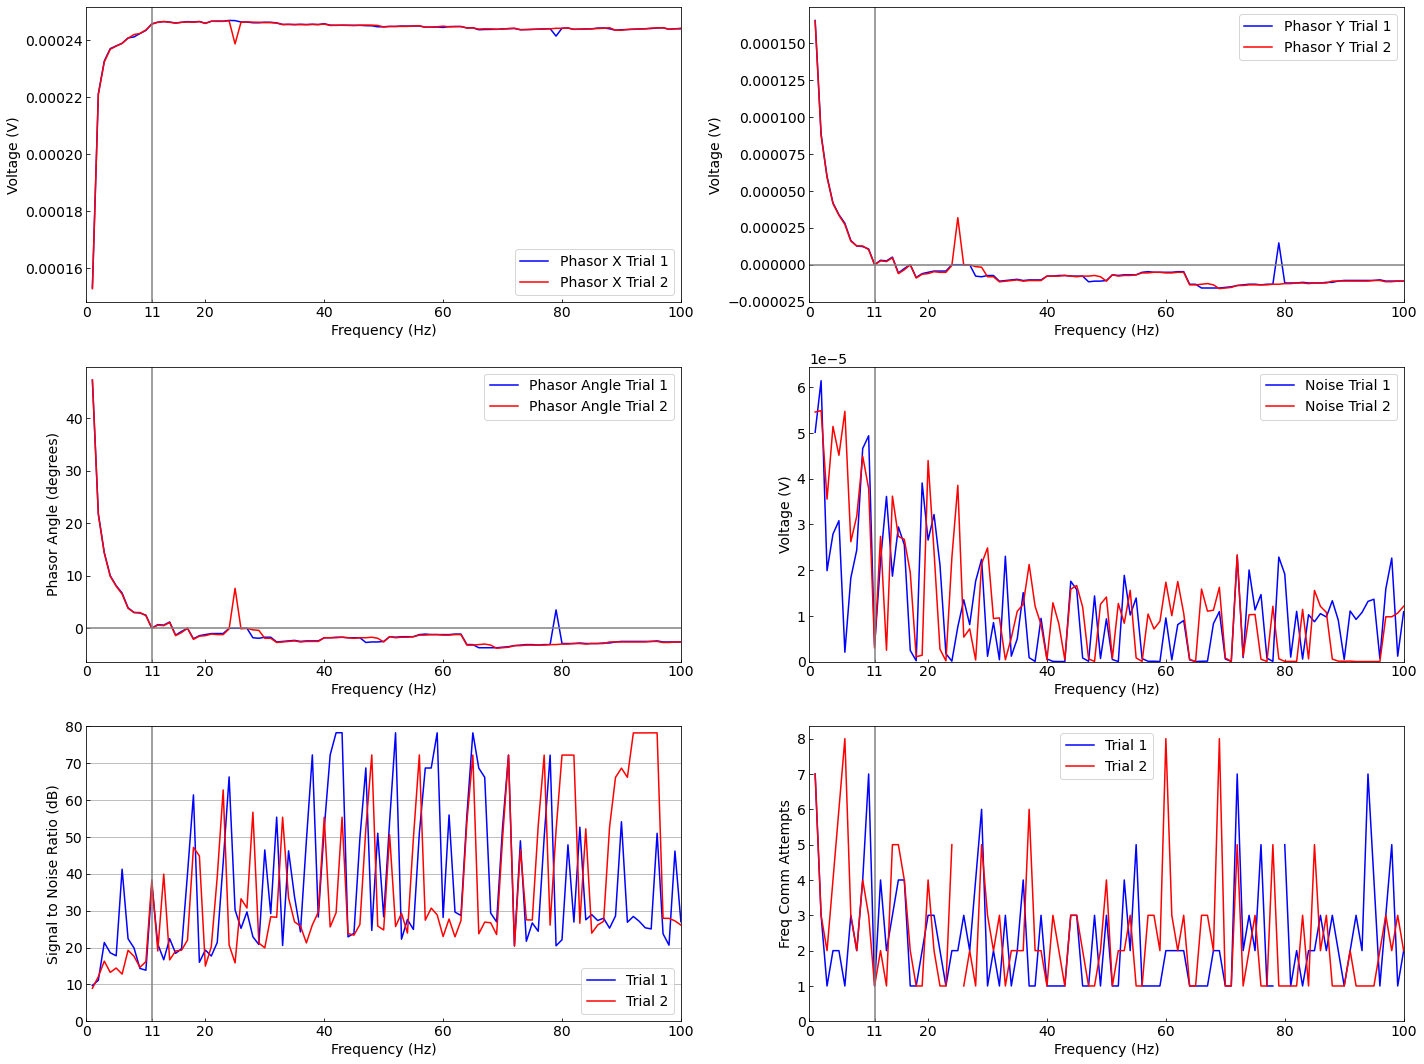

In [21]:
#internal oscillator frequency sweep analysis

#save plot pic
save_yes = True

#plot pic name
plot_pic = 'Freq_sweep_analysis.png'

#plot the data and analysis of the two trials
plt.rcParams.update({'font.size': 14})
fig= plt.figure(figsize=(20,15))
gs = gridspec.GridSpec(3,2)

#plot phasor real component
ax1 = plt.subplot(gs[0,0], xlabel='Frequency (Hz)', ylabel='Voltage (V)')
ax1.plot(df_F.Frequency, df_F.X, 'b', label='Phasor X Trial 1')  
ax1.plot(df_F2.Frequency, df_F2.X, 'r', label='Phasor X Trial 2')  
ax1.tick_params(direction='in')
ax1.xaxis.set_ticks([0,11,20,40,60,80,100])
ax1.axvline(x=11, c='grey')
ax1.set_xlim(xmin=0, xmax=100)
ax1.legend()

#plot phasor imaginary component
ax2 = plt.subplot(gs[0,1], xlabel='Frequency (Hz)', ylabel='Voltage (V)')
ax2.plot(df_F.Frequency, df_F.Y, 'b', label='Phasor Y Trial 1')  
ax2.plot(df_F2.Frequency, df_F2.Y, 'r', label='Phasor Y Trial 2')  
ax2.tick_params(direction='in')
ax2.xaxis.set_ticks([0,11,20,40,60,80,100])
ax2.axvline(x=11, c='grey')
ax2.axhline(y=0, c='grey')
ax2.set_xlim(xmin=0, xmax=100)
ax2.legend()

#plot phasor angle
ax3 = plt.subplot(gs[1,0], xlabel='Frequency (Hz)', ylabel='Phasor Angle (degrees)')
# ax2.set_yscale("log")
ax3.plot(df_F.Frequency, df_F.Phase, 'b', label='Phasor Angle Trial 1')  
ax3.plot(df_F2.Frequency, df_F2.Phase, 'r', label='Phasor Angle Trial 2')  
ax3.tick_params(direction='in')
ax3.xaxis.set_ticks([0,11,20,40,60,80,100])
ax3.axvline(x=11, c='grey')
ax3.axhline(y=0, c='grey')
ax3.set_xlim(xmin=0, xmax=100)
ax3.legend()

#plot lockin amplifier noise report
ax4 = plt.subplot(gs[1,1], xlabel='Frequency (Hz)', ylabel='Voltage (V)')
ax4.plot(df_F.Frequency, df_F.Noise, 'b', label='Noise Trial 1') 
ax4.plot(df_F2.Frequency, df_F2.Noise, 'r', label='Noise Trial 2')  
ax4.tick_params(direction='in')
ax4.xaxis.set_ticks([0,11,20,40,60,80,100])
ax4.axvline(x=11, c='grey')
ax4.set_ylim(ymin=0)
ax4.set_xlim(xmin=0, xmax=100)
ax4.legend()

#calculate and plot signal (X, point by point) to noise (point by point) ratio in decibels
df_F['snr_f'] = 20*np.log10((df_F.X)/df_F.Noise)
df_F2['snr_f'] = 20*np.log10((df_F2.X)/df_F2.Noise)
ax5 = plt.subplot(gs[2,0], xlabel='Frequency (Hz)', ylabel='Signal to Noise Ratio (dB)')
ax5.plot(df_F.Frequency, df_F.snr_f, 'b', label='Trial 1') 
ax5.plot(df_F2.Frequency, df_F2.snr_f, 'r', label='Trial 2')  
ax5.grid(axis='y')
ax5.tick_params(direction='in')
ax5.xaxis.set_ticks([0,11,20,40,60,80,100])
ax5.axvline(x=11, c='grey')
ax5.yaxis.set_ticks(np.arange(0,100,10))
ax5.set_ylim(ymax=80)
ax5.set_xlim(xmin=0, xmax=100)
ax5.legend()

#plot frequency communication attempts
#this is included since the numbers were higher than expected
ax6 = plt.subplot(gs[2,1], xlabel='Frequency (Hz)', ylabel='Freq Comm Attempts')
ax6.plot(df_F.Frequency, df_F.Freq_attempts, 'b', label='Trial 1')  
ax6.plot(df_F2.Frequency, df_F2.Freq_attempts, 'r', label='Trial 2')  
ax6.tick_params(direction='in')
ax6.xaxis.set_ticks([0,11,20,40,60,80,100])
ax6.axvline(x=11, c='grey')
ax6.set_xlim(xmin=0, xmax=100)
ax6.set_ylim(ymin=0)
ax6.legend()

plt.tight_layout()
if save_yes == True:
    plt.savefig(plot_pic, dpi=300, bbox_inches = "tight")
plt.show()

<a id="Results-and-Analysis:-Time-Constant-Sweep"></a>


## Results and Analysis

<ul><ul>
<li><a href="#Results-and-Analysis:-Internal-Oscillator-Voltage-Sweep">Results and Analysis: Internal Oscillator Voltage Sweep</a></li>
<li><a href="#Results-and-Analysis:-Internal-Oscillator-Frequency-Sweep">Results and Analysis: Internal Oscillator Frequency Sweep</a></li>
</ul></ul>

>### Results and Analysis: Time Constant Sweep
<ul><ul>
<li><a href="#Results-and-Analysis:-Long-Data-Collection">Results and Analysis: Long Data Collection</a></li>
<li><a href="#Results-and-Analysis:-Phasor-Offset-Angle-Sweep">Results and Analysis: Phasor Offset Angle Sweep</a></li>
</ul></ul>

In [ ]:
# #read data files (csv) if needed
# df_Tc = {}
# Tc_tuple = (0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30)

# for Tc in Tc_tuple:
#     df_Tc[str(Tc).replace('.', '_')] = pd.read_csv('meas_Tc' + str(Tc).replace('.', '_') + '_test.csv')

In [22]:
#dictionary key names reminder
df_Tc.keys()

dict_keys(['0_001', '0_003', '0_01', '0_03', '0_1', '0_3', '1', '3', '10', '30'])

In [23]:
#some of the values in Tc = 3 sec and most of the values in the Tc = 10,30 sec Noise data are zero
#this section creates small value Noise data to replace zeroes as place holders for plotting

alt_n3 = []
for z in df_Tc['3']['Noise']:
    if z == 0:
        alt_n3.append(1*10**-15)
    else:
        alt_n3.append(z)
df_Tc['3']['Noise_alt'] = alt_n3

alt_n10 = []
for x in df_Tc['10']['Noise']:
    if x == 0:
        alt_n10.append(1*10**-15)
    else:
        alt_n10.append(x)
df_Tc['10']['Noise_alt'] = alt_n10

alt_n30 = []
for y in df_Tc['30']['Noise']:
    if y == 0:
        alt_n30.append(1*10**-15)
    else:
        alt_n30.append(y)
df_Tc['30']['Noise_alt'] = alt_n30

Results: Time Constant Sweep


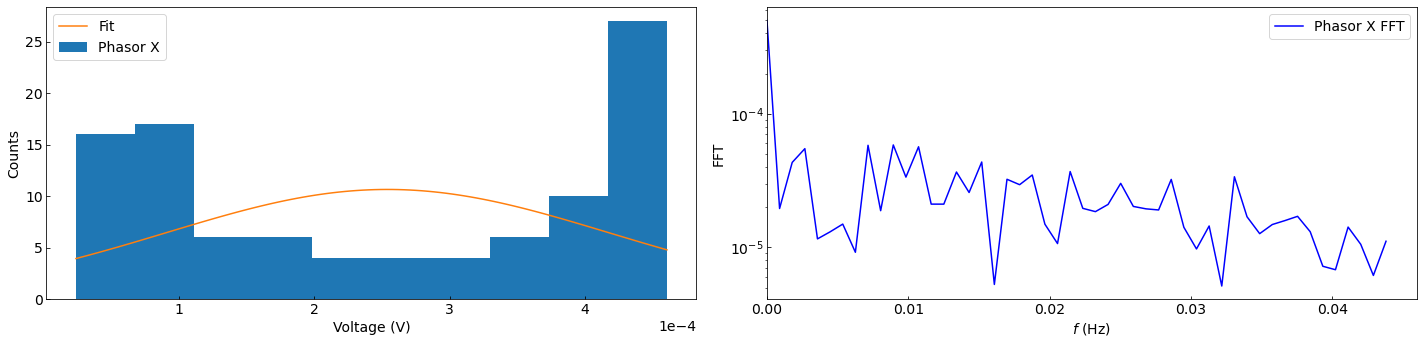

Time constant = 0.001 seconds
Total measurement time = 1107.3575773239136 seconds
Average time step = 11.185430073978925 seconds
Total data points = 100
Lockin amplifier range setting = 0.0003
Mean phasor X = 0.00025399469776966486 V
Mean phasor angle = -6.653000000000002 degrees
Maximum histogram bin =  0.00041672322440166557 V
Max histogram bin - mean phasor X =  0.0001627285266320007 V
Phasor X standard deviation =  0.0001633899887225439 V
Noise mean =  0.0001544232000000001 V
Noise (mean) / phasor X standard deviation =  0.9451203296318815
Signal (X mean) to noise ratio =  4.322242057606242 dB
Signal (X mean) to standard deviation ratio =  3.831984157279416 dB


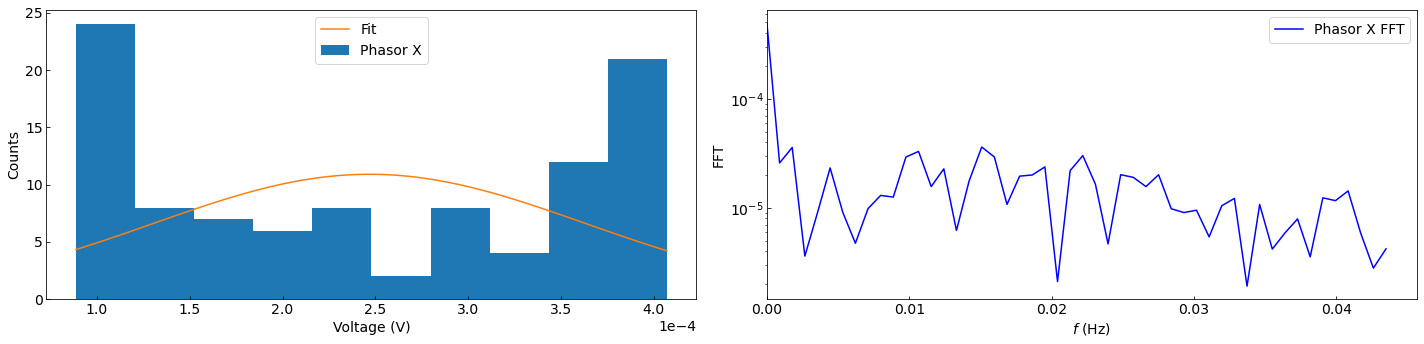

Time constant = 0.003 seconds
Total measurement time = 1115.4692690372467 seconds
Average time step = 11.267366353911584 seconds
Total data points = 100
Lockin amplifier range setting = 0.0003
Mean phasor X = 0.0002467742172708534 V
Mean phasor angle = -0.6659999999999998 degrees
Maximum histogram bin =  8.871784031683689e-05 V
Max histogram bin - mean phasor X =  -0.0001580563769540165 V
Phasor X standard deviation =  0.00011643967123644687 V
Noise mean =  0.00010108440000000004 V
Noise (mean) / phasor X standard deviation =  0.8681268070117973
Signal (X mean) to noise ratio =  7.752312908924691 dB
Signal (X mean) to standard deviation ratio =  6.523976250315123 dB


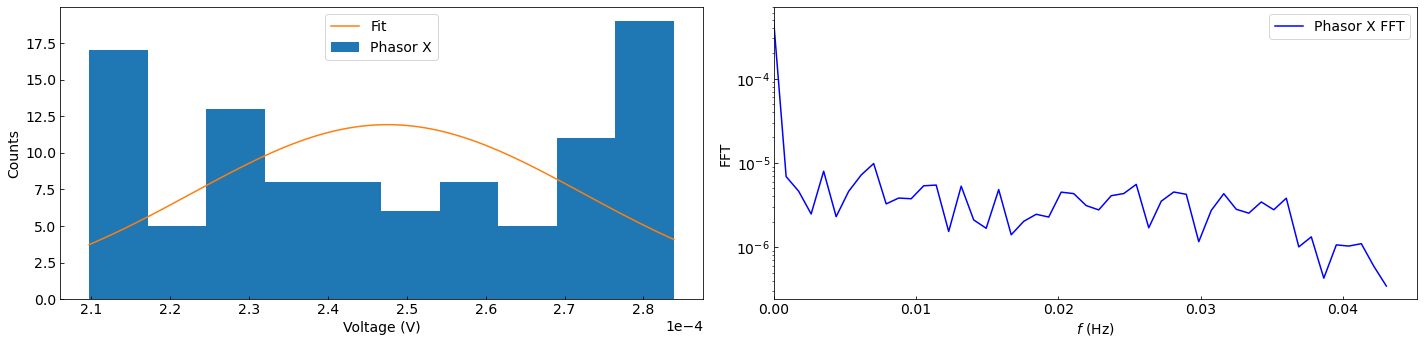

Time constant = 0.01 seconds
Total measurement time = 1127.0184967517853 seconds
Average time step = 11.384025219715003 seconds
Total data points = 100
Lockin amplifier range setting = 0.0003
Mean phasor X = 0.0002475388405304708 V
Mean phasor angle = -2.041 degrees
Maximum histogram bin =  0.0002764465592177912 V
Max histogram bin - mean phasor X =  2.8907718687320376e-05 V
Phasor X standard deviation =  2.4814667026456062e-05 V
Noise mean =  2.3448599999999984e-05 V
Noise (mean) / phasor X standard deviation =  0.9449492098765762
Signal (X mean) to noise ratio =  20.470528682616553 dB
Signal (X mean) to standard deviation ratio =  19.978698007021443 dB


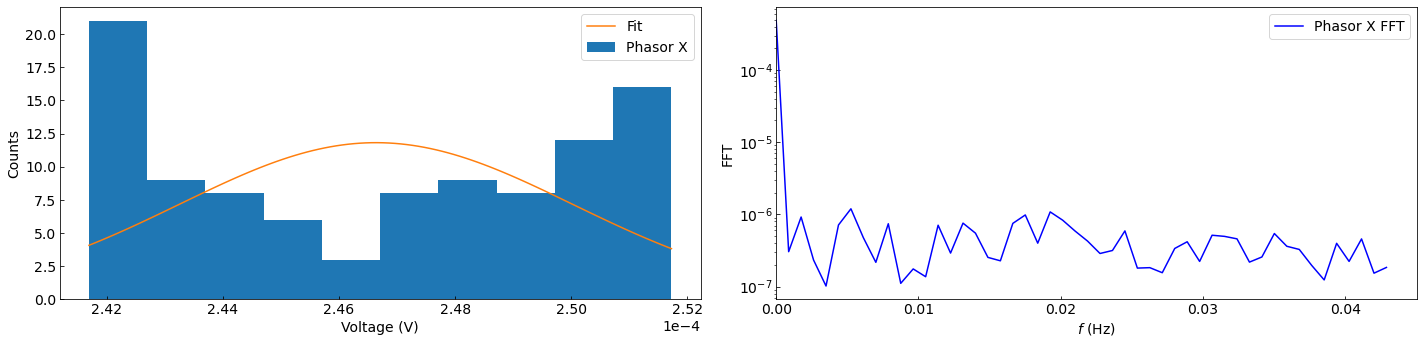

Time constant = 0.03 seconds
Total measurement time = 1131.0003151893616 seconds
Average time step = 11.424245607973349 seconds
Total data points = 100
Lockin amplifier range setting = 0.0003
Mean phasor X = 0.0002466365092823996 V
Mean phasor angle = -1.3719999999999997 degrees
Maximum histogram bin =  0.000241693574176867 V
Max histogram bin - mean phasor X =  -4.942935105532606e-06 V
Phasor X standard deviation =  3.386589992940682e-06 V
Noise mean =  3.059999999999996e-06 V
Noise (mean) / phasor X standard deviation =  0.9035637636615416
Signal (X mean) to noise ratio =  38.12671877170794 dB
Signal (X mean) to standard deviation ratio =  37.24589488649751 dB


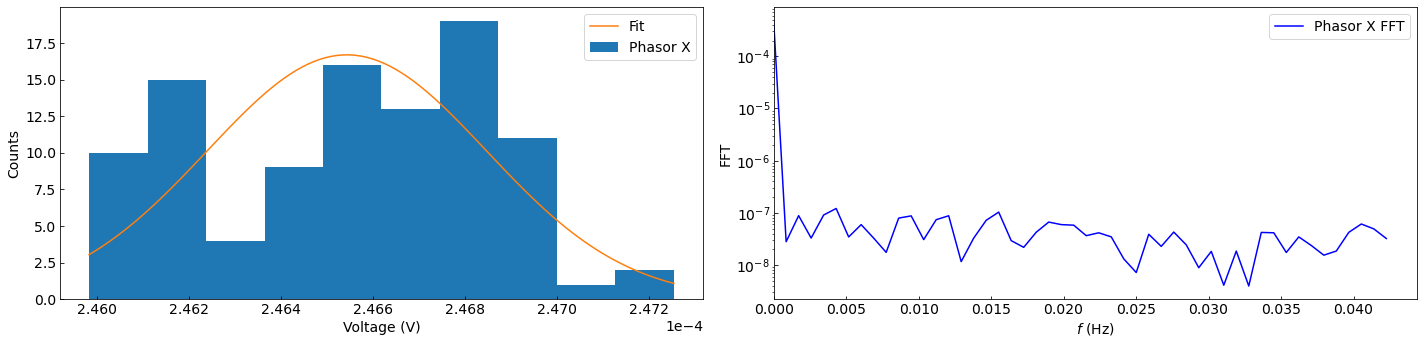

Time constant = 0.1 seconds
Total measurement time = 1147.9978983402252 seconds
Average time step = 11.595938367072982 seconds
Total data points = 100
Lockin amplifier range setting = 0.0003
Mean phasor X = 0.00024654231852601577 V
Mean phasor angle = -1.6609999999999983 degrees
Maximum histogram bin =  0.00024674481156385065 V
Max histogram bin - mean phasor X =  2.024930378348791e-07 V
Phasor X standard deviation =  3.040731775686194e-07 V
Noise mean =  2.7149999999999933e-07 V
Noise (mean) / phasor X standard deviation =  0.8928771757210668
Signal (X mean) to noise ratio =  59.16243283838479 dB
Signal (X mean) to standard deviation ratio =  58.1782672664295 dB


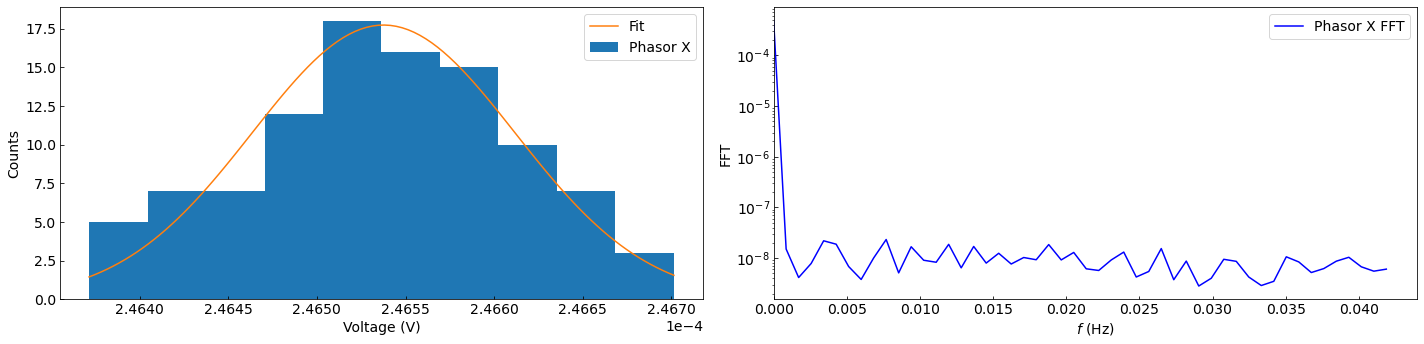

Time constant = 0.3 seconds
Total measurement time = 1158.5114796161652 seconds
Average time step = 11.702136157739043 seconds
Total data points = 100
Lockin amplifier range setting = 0.0003
Mean phasor X = 0.00024653762560538977 V
Mean phasor angle = -1.6589999999999978 degrees
Maximum histogram bin =  0.00024650345622376154 V
Max histogram bin - mean phasor X =  -3.416938162823695e-08 V
Phasor X standard deviation =  7.419579873615825e-08 V
Noise mean =  6.660000000000005e-08 V
Noise (mean) / phasor X standard deviation =  0.8976249482377162
Signal (X mean) to noise ratio =  71.36817959643031 dB
Signal (X mean) to standard deviation ratio =  70.43007789025584 dB


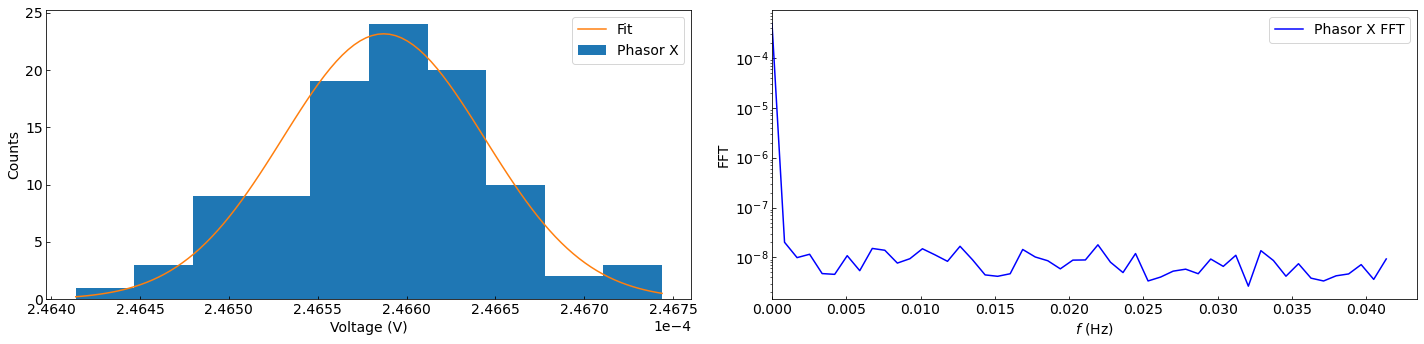

Time constant = 1.0 seconds
Total measurement time = 1173.236665725708 seconds
Average time step = 11.850875411370788 seconds
Total data points = 100
Lockin amplifier range setting = 0.0003
Mean phasor X = 0.0002465870879635591 V
Mean phasor angle = -1.5959999999999972 degrees
Maximum histogram bin =  0.0002465788251275794 V
Max histogram bin - mean phasor X =  -8.26283597972358e-09 V
Phasor X standard deviation =  5.682940366640894e-08 V
Noise mean =  4.0800000000000015e-08 V
Noise (mean) / phasor X standard deviation =  0.7179382039533229
Signal (X mean) to noise ratio =  75.6262033761793 dB
Signal (X mean) to standard deviation ratio =  72.74794466110721 dB


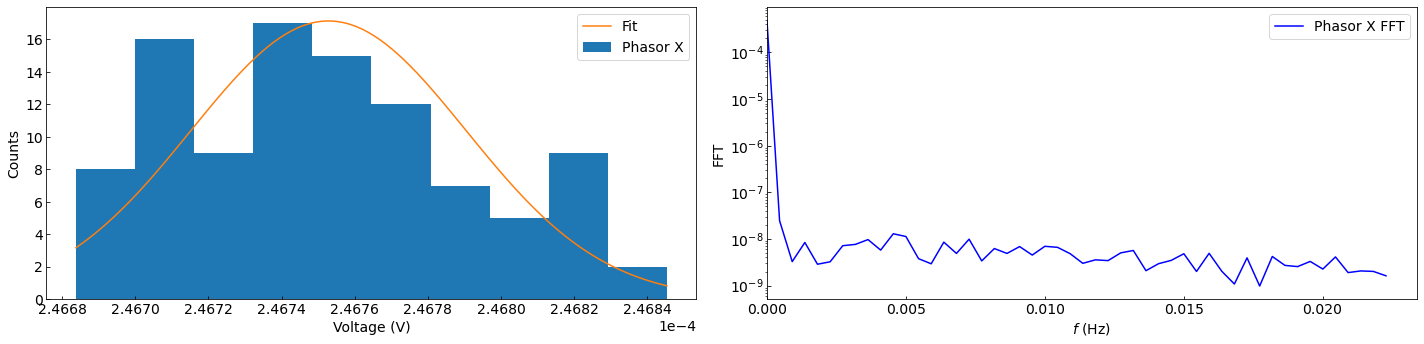

Time constant = 3.0 seconds
Total measurement time = 2177.0451650619507 seconds
Average time step = 21.990355202645965 seconds
Total data points = 100
Lockin amplifier range setting = 0.0003
Mean phasor X = 0.0002467528366141217 V
Mean phasor angle = -1.552999999999997 degrees
Maximum histogram bin =  0.0002467322639096253 V
Max histogram bin - mean phasor X =  -2.0572704496392164e-08 V
Phasor X standard deviation =  3.760790126514487e-08 V
Noise mean =  2.790000000000002e-08 V
Noise (mean) / phasor X standard deviation =  0.7418653809819968
Signal (X mean) to noise ratio =  78.93315899114177 dB
Signal (X mean) to standard deviation ratio =  76.33966111849256 dB


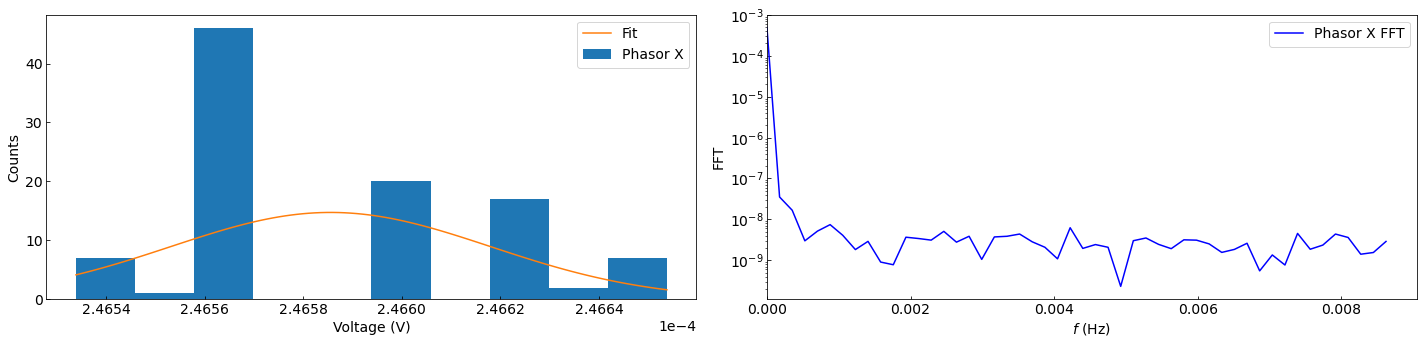

Time constant = 10.0 seconds
Total measurement time = 5625.913395404816 seconds
Average time step = 56.82740803439208 seconds
Total data points = 100
Lockin amplifier range setting = 0.0003
Mean phasor X = 0.0002465855315482544 V
Mean phasor angle = -1.5989999999999973 degrees
Maximum histogram bin =  0.00024655783331516357 V
Max histogram bin - mean phasor X =  -2.7698233090857425e-08 V
Phasor X standard deviation =  3.246711813645971e-08 V
Noise mean =  2.1e-09 V
Noise (mean) / phasor X standard deviation =  0.0646808254176941
Signal (X mean) to noise ratio =  101.39496207267601 dB
Signal (X mean) to standard deviation ratio =  77.6104769887643 dB


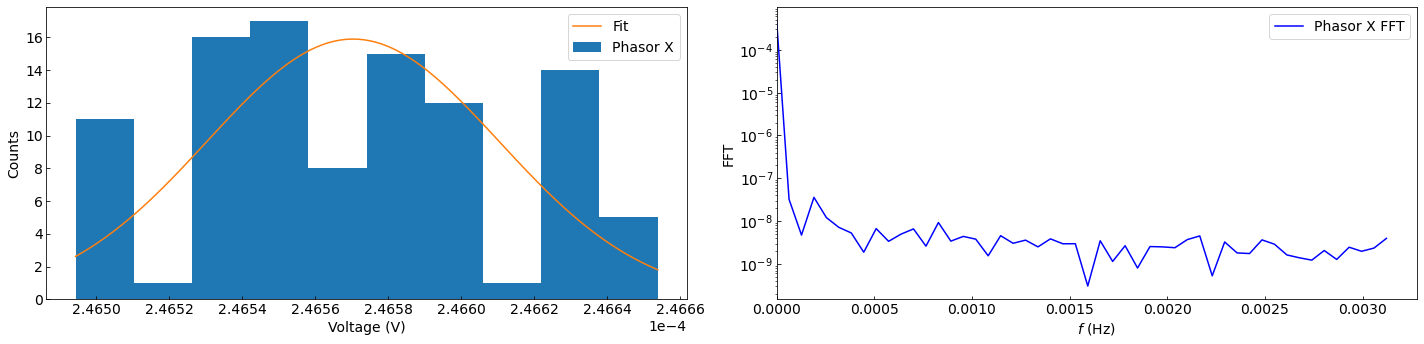

Time constant = 30.0 seconds
Total measurement time = 15537.515293836594 seconds
Average time step = 156.94459892764235 seconds
Total data points = 100
Lockin amplifier range setting = 0.0003
Mean phasor X = 0.00024657037917573247 V
Mean phasor angle = -1.7020000000000013 degrees
Maximum histogram bin =  0.00024654222349626315 V
Max histogram bin - mean phasor X =  -2.8155679469323014e-08 V
Phasor X standard deviation =  4.000581938263764e-08 V
Noise mean =  3e-10 V
Noise (mean) / phasor X standard deviation =  0.007498909024475544
Signal (X mean) to noise ratio =  118.29636430272544 dB
Signal (X mean) to standard deviation ratio =  75.7963546629769 dB

Analysis: Time Constant Sweep



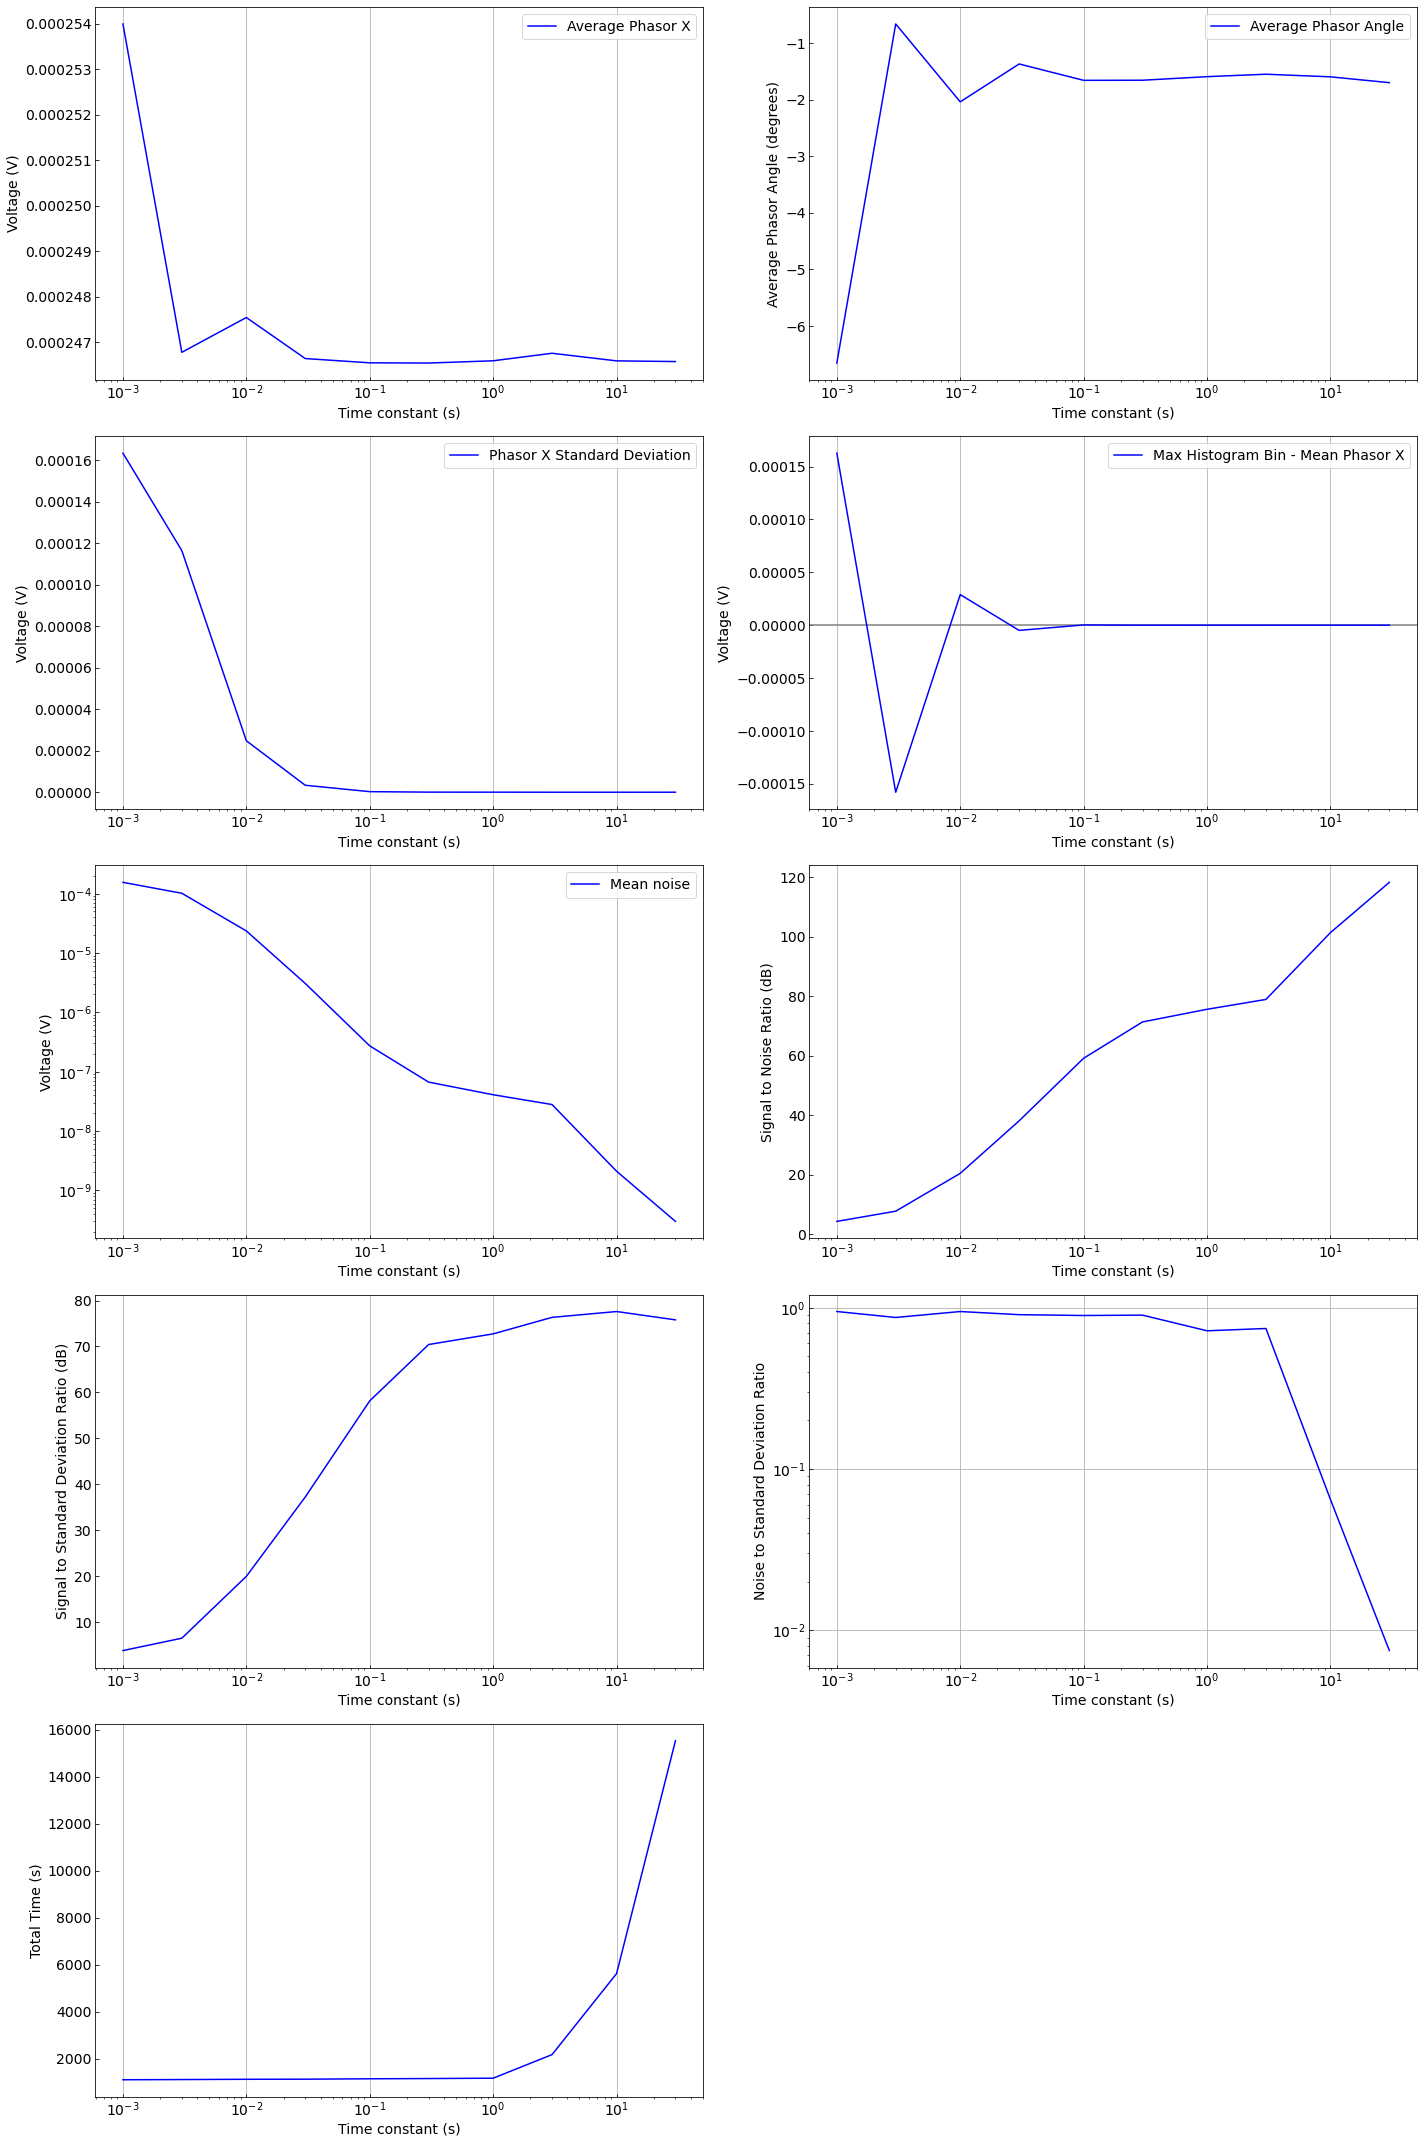

In [24]:
#time constant sweep analysis

#save plot pics
save_yes = True

#plot pic names
plot_pic1a = 'Tc_sweep_analysis_'
plot_pic2 = 'Tc_sweep_summary.png'

#lists that will be necessary for analysis of all the time constant sweeps
Tc_t = []
Xav = []
Xstr = []
SNR = []
SstrR = []
N2strR = []
tot_t = []
histmeanDiff = []
noiseMean = []
Pphase = []

print('Results: Time Constant Sweep')

#plot the data, statistics, and frequency analysis for every time constant setting
for q,key in enumerate(df_Tc.keys()):
    
    #unique plot pic name for every time constant sweep
    plot_pic1b = plot_pic1a + key + '.png'
    
    plt.rcParams.update({'font.size': 14})
    fig= plt.figure(figsize=(20,5))
    gs = gridspec.GridSpec(1,2)
    
    #plot histogram of the phasor real component
    ax1 = plt.subplot(gs[0,0], xlabel='Voltage (V)', ylabel='Counts')
    hist_dat = ax1.hist(df_Tc[key].X, label='Phasor X')  
    ax1.tick_params(direction='in')

    #calculate and plot a fit of the histogram data
    mean = np.mean(df_Tc[key].X)
    sigma = np.std(df_Tc[key].X)
    x = np.linspace(min(df_Tc[key].X), max(df_Tc[key].X), 100)
    dx = hist_dat[1][1] - hist_dat[1][0]
    amplitude = (len(df_Tc[key].X))*dx
    ax1.ticklabel_format(axis='x', style='sci', scilimits=(-1,1000000))
    ax1.plot(x, norm.pdf(x, mean, sigma)*amplitude, label='Fit')
    ax1.legend()

    #calculate and plot the fft of the phasor real component
    df_Tc[key]['Time_rs'] = np.linspace(df_Tc[key].Time.iloc[0], 
                                          df_Tc[key].Time.iloc[-1], 
                                          num=len(df_Tc[key].Time), endpoint=True)
    lin_model = interp1d(df_Tc[key].Time, df_Tc[key].X, kind='linear')
    df_Tc[key]['X_rs'] = lin_model(df_Tc[key].Time_rs)

    df_Tc[key]['fft'] = fft.fft(list(df_Tc[key].X_rs))

    t_step = np.mean([df_Tc[key].Time_rs[n] - df_Tc[key].Time_rs[n-1] 
                      for n,x in enumerate(df_Tc[key].Time_rs) if n != 0])
    fft_freq_all = fft.fftfreq(len(df_Tc[key].X), d=t_step)
    fft_freq = [x for n,x in enumerate(fft_freq_all) if x >= 0]

    L = len(df_Tc[key].fft)
    fft_yaxis = 2.0/(L + 1) * abs(df_Tc[key].fft[0:(L + 1)//2])
    ax2 = plt.subplot(gs[0,1])
    ax2.plot(fft_freq, fft_yaxis, '-b', label='Phasor X FFT')
    ax2.set(xlabel='$f$ (Hz)', ylabel='FFT')
    ax2.set_yscale("log")
    ax2.tick_params(direction='in')
    ax2.set_xlim(xmin=0)
    ax2.legend()
    
    plt.tight_layout()
    if save_yes == True:
        plt.savefig(plot_pic1b, dpi=300, bbox_inches = "tight")
    plt.show()
    
    #switch to the alternate noise data so there is no division by zero
    if key == '3' or key == '10' or key == '30': 
        sig2noise = 20*np.log10(np.mean(df_Tc[key].X)/np.mean(df_Tc[key].Noise_alt))
    else:
        sig2noise = 20*np.log10(np.mean(df_Tc[key].X)/np.mean(df_Tc[key].Noise))
        
    #calculations involving signal, uncertainty, and noise
    sig2str = 20*np.log10(np.mean(df_Tc[key].X)/np.std(df_Tc[key].X))
    nois2str = np.mean(df_Tc[key].Noise)/np.std(df_Tc[key].X)
    histmean = hist_dat[1][list(hist_dat[0]).index(max(hist_dat[0]))] - mean
    nmean = np.mean(df_Tc[key].Noise)
    phaMean = np.mean(df_Tc[key].Phase)
    
    #assemble the calculations for plots
    Tc_t.append(df_Tc[key].Tc[0])
    Xav.append(mean)
    Pphase.append(phaMean)
    Xstr.append(sigma)
    histmeanDiff.append(histmean)
    noiseMean.append(nmean)
    SNR.append(sig2noise)
    SstrR.append(sig2str)
    N2strR.append(nois2str)
    tot_t.append(list(df_Tc[key].Time)[-1])
    
    #display the unique settings, data, and calculations for a particular time constant sweep
    print('Time constant =',df_Tc[key].Tc[0], 'seconds')
    print('Total measurement time =',list(df_Tc[key].Time)[-1],'seconds')
    print('Average time step =', t_step, 'seconds')
    print('Total data points =',len(df_Tc[key].X))
    print('Lockin amplifier range setting =', df_Tc[key].Range[0])
    print('Mean phasor X =', mean, 'V')
    print('Mean phasor angle =', phaMean, 'degrees')
    print('Maximum histogram bin = ', hist_dat[1][list(hist_dat[0]).index(max(hist_dat[0]))], 'V')
    print('Max histogram bin - mean phasor X = ', histmean, 'V')
    print('Phasor X standard deviation = ', sigma, 'V')
    print('Noise mean = ', nmean, 'V')
    print('Noise (mean) / phasor X standard deviation = ', nois2str)
    print('Signal (X mean) to noise ratio = ', sig2noise, 'dB')
    print('Signal (X mean) to standard deviation ratio = ', sig2str, 'dB')
    
print()
print('Analysis: Time Constant Sweep')
print()
    
#plot the calculated values for each time constant sweep as a function of the time constant
plt.rcParams.update({'font.size': 14})
fig= plt.figure(figsize=(20,30))
gs = gridspec.GridSpec(5,2)

#plot average phasor real component
ax1 = plt.subplot(gs[0,0], xlabel='Time constant (s)', ylabel='Voltage (V)')
ax1.set_xscale("log")
ax1.grid(axis='x')
ax1.plot(Tc_t, Xav, 'b', label='Average Phasor X')  
ax1.tick_params(direction='in')
ax1.legend()

#plot average phasor angle
ax2 = plt.subplot(gs[0,1], xlabel='Time constant (s)', ylabel='Average Phasor Angle (degrees)')
ax2.set_xscale("log")
ax2.grid(axis='x')
ax2.plot(Tc_t, Pphase, 'b', label='Average Phasor Angle')  
ax2.tick_params(direction='in')
ax2.legend()

#plot the phasor real component standard deviation
ax3 = plt.subplot(gs[1,0], xlabel='Time constant (s)', ylabel='Voltage (V)')
ax3.set_xscale("log")
ax3.grid(axis='x')
ax3.plot(Tc_t, Xstr, 'b', label='Phasor X Standard Deviation')  
ax3.tick_params(direction='in')
ax3.legend()

#plot the difference between mean and mode
ax4 = plt.subplot(gs[1,1], xlabel='Time constant (s)', ylabel='Voltage (V)')
ax4.set_xscale("log")
ax4.grid(axis='x')
ax4.axhline(y=0, c='grey')
ax4.plot(Tc_t, histmeanDiff, 'b', label='Max Histogram Bin - Mean Phasor X')  
ax4.tick_params(direction='in')
ax4.legend()

#plot average noise
ax5 = plt.subplot(gs[2,0], xlabel='Time constant (s)', ylabel='Voltage (V)')
ax5.set_xscale("log")
ax5.set_yscale("log")
ax5.grid(axis='x')
ax5.plot(Tc_t, noiseMean, 'b', label='Mean noise')  
ax5.tick_params(direction='in')
ax5.legend()

#plot signal (mean X) to noise (mean noise) ratio in decibels
ax6 = plt.subplot(gs[2,1], xlabel='Time constant (s)', ylabel='Signal to Noise Ratio (dB)')
ax6.set_xscale("log")
ax6.grid(axis='x')
ax6.plot(Tc_t, SNR, 'b')  
ax6.tick_params(direction='in')

#plot signal (mean X) to standard deviation (X, one entire sweep) ratio in decibels
ax7 = plt.subplot(gs[3,0], xlabel='Time constant (s)', ylabel='Signal to Standard Deviation Ratio (dB)')
ax7.set_xscale("log")
ax7.grid(axis='x')
ax7.plot(Tc_t, SstrR, 'b')  
ax7.tick_params(direction='in')

#plot noise (mean noise) to standard deviation (X, one entire sweep) ratio, not in decibels
ax8 = plt.subplot(gs[3,1], xlabel='Time constant (s)', ylabel='Noise to Standard Deviation Ratio')
ax8.set_xscale("log")
ax8.set_yscale("log")
ax8.grid(axis='y')
ax8.grid(axis='x')
ax8.plot(Tc_t, N2strR, 'b')  
ax8.tick_params(direction='in')

#plot sweep times
ax9 = plt.subplot(gs[4,0], xlabel='Time constant (s)', ylabel='Total Time (s)')
ax9.set_xscale("log")
ax9.grid(axis='x')
ax9.plot(Tc_t, tot_t, 'b')  
ax9.tick_params(direction='in')

plt.tight_layout()
if save_yes == True:
    plt.savefig(plot_pic2, dpi=300, bbox_inches = "tight")
plt.show()

<a id="Results-and-Analysis:-Long-Data-Collection"></a><!--Notebook author: Drew Rebar-->

## Results and Analysis

<ul><ul>
<li><a href="#Results-and-Analysis:-Internal-Oscillator-Voltage-Sweep">Results and Analysis: Internal Oscillator Voltage Sweep</a></li>
<li><a href="#Results-and-Analysis:-Internal-Oscillator-Frequency-Sweep">Results and Analysis: Internal Oscillator Frequency Sweep</a></li>
<li><a href="#Results-and-Analysis:-Time-Constant-Sweep">Results and Analysis: Time Constant Sweep</a></li>
</ul></ul>

>### Results and Analysis: Long Data Collection
<ul><ul>
<li><a href="#Results-and-Analysis:-Phasor-Offset-Angle-Sweep">Results and Analysis: Phasor Offset Angle Sweep</a></li>
</ul></ul>

In [ ]:
# #read data files (csv) if needed
# df_LT = pd.read_csv('LongTime_test.csv')

Results: Long Data Collection


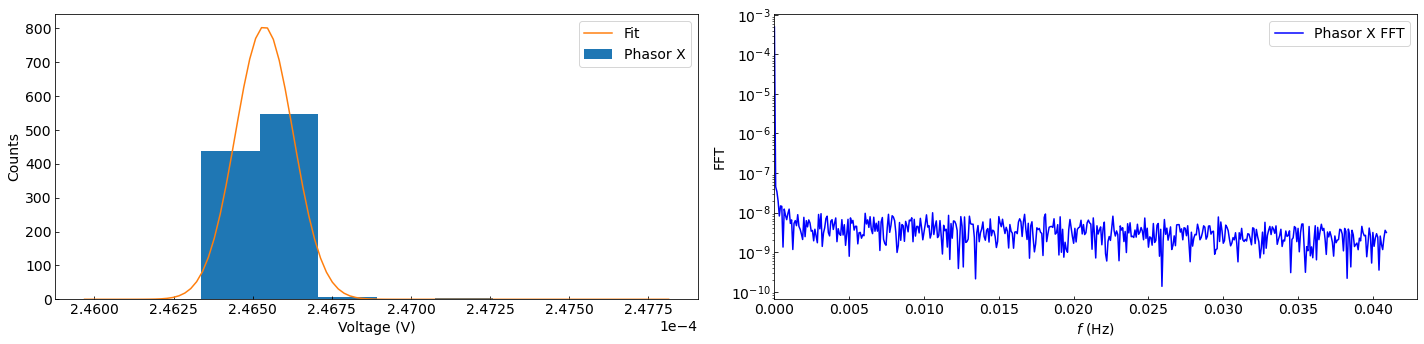

Total measurement time = 12184.890089511871 seconds
Average time step = 12.19708717668856 seconds
Total data points = 1000
Internal oscillator voltage = 1.0
Lockin amplifier range setting = 0.0003
Mean phasor X = 0.00024653666752603553 V
Mean phasor angle = -1.6993000000000125 degrees
Maximum histogram bin =  0.0002465222953302232 V
Max histogram bin - mean resistance =  -1.4372195812314189e-08 V
Phasor X standard deviation =  9.1349344971593e-08 V
Phasor Y standard deviation =  4.779500637505617e-07 V
Phasor Magnitude standard deviation =  8.475517683303664e-08 V
Phasor angle standard deviation =  0.11130817580034318 degrees
Noise mean =  4.110000000000012e-08 V
Noise (mean) / phasor X standard deviation =  0.44992112436910225
Signal (X mean) to noise ratio =  75.56079398767936 dB
Signal (X mean) to standard deviation ratio =  68.62352167413191 dB

Analysis: Long Data Collection



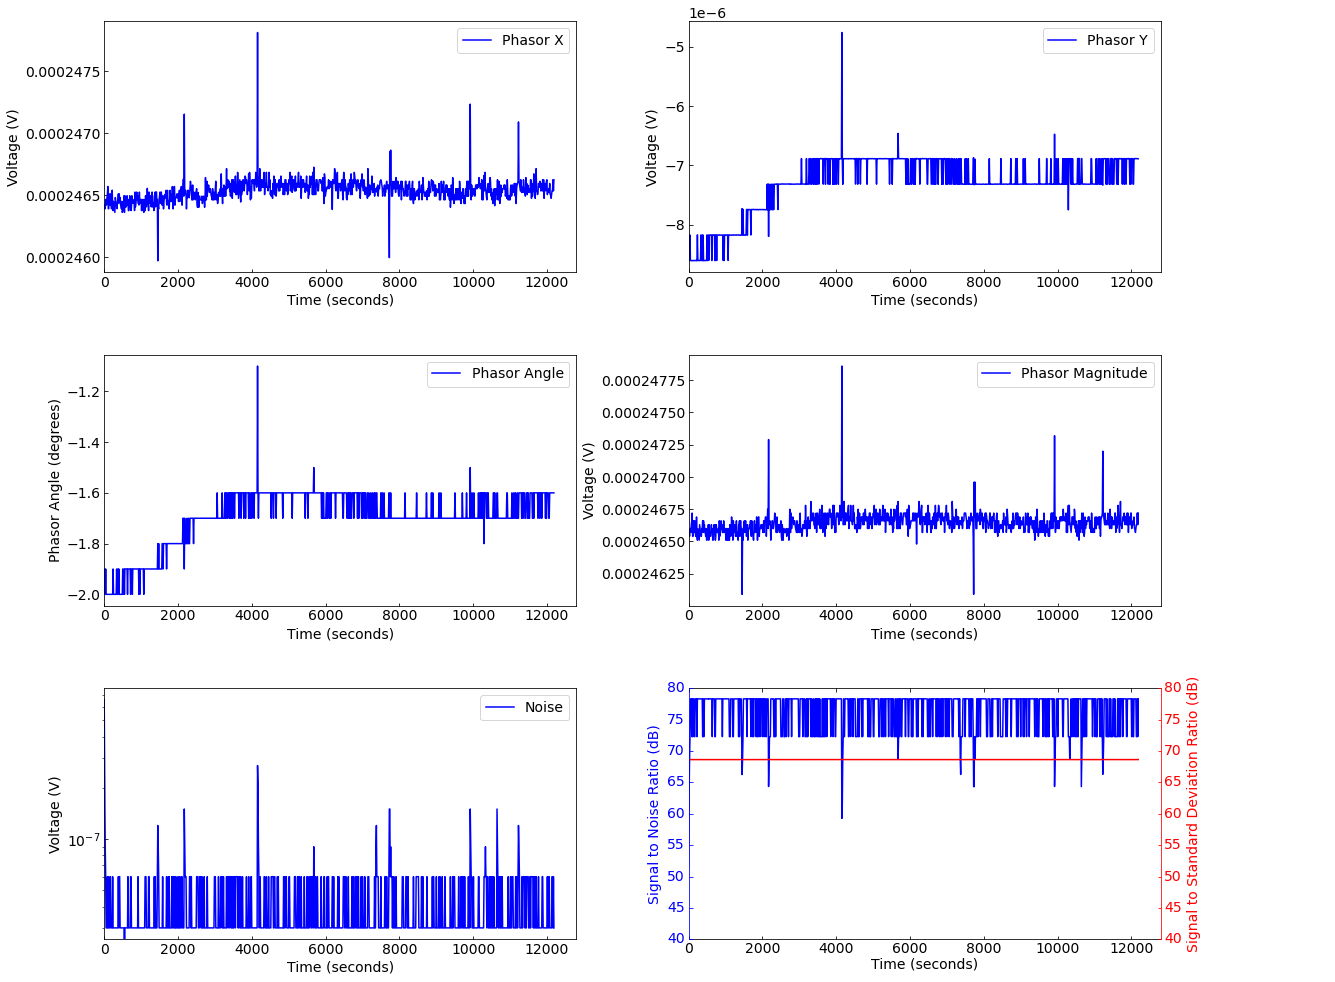

In [25]:
#long data collection analysis

#save plot pics
save_yes = True

#plot pic names
plot_pic1 = 'LongDataColl_analysis_1.png'
plot_pic2 = 'LongDataColl_summary1_1.png'
plot_pic3 = 'LongDataColl_summary2_1.png'

print('Results: Long Data Collection')

#plot the data, statistics, and frequency analysis for the long data collection
plt.rcParams.update({'font.size': 14})
fig= plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(1,2)

#plot histogram of the phasor real component
ax1 = plt.subplot(gs[0,0], xlabel='Voltage (V)', ylabel='Counts')
hist_dat = ax1.hist(df_LT.X, label='Phasor X')  
ax1.tick_params(direction='in')

#calculate and plot a fit of the histogram of the phasor real component
mean = np.mean(df_LT.X)
sigma = np.std(df_LT.X)
x_ax = np.linspace(min(df_LT.X), max(df_LT.X), 100)
dx = hist_dat[1][1] - hist_dat[1][0]
amplitude = (len(df_LT.X))*dx
ax1.ticklabel_format(axis='x', style='sci', scilimits=(-1,1000000))
ax1.plot(x_ax, norm.pdf(x_ax, mean, sigma)*amplitude, label='Fit')
ax1.legend()

#calculate and plot the fft of the phasor real component
df_LT['Time_rs'] = np.linspace(df_LT.Time.iloc[0], 
                               df_LT.Time.iloc[-1], 
                               num=len(df_LT.Time), endpoint=True)
lin_model = interp1d(df_LT.Time, df_LT.X, kind='linear')
df_LT['X_rs'] = lin_model(df_LT.Time_rs)

df_LT['fft'] = fft.fft(list(df_LT.X_rs))

t_step = df_LT.Time_rs[1] - df_LT.Time_rs[0]
fft_freq_all = fft.fftfreq(len(df_LT.X), d=t_step)
fft_freq = [x for x in fft_freq_all if x >= 0]

L = len(df_LT.fft)
fft_yaxis = 2.0/(L + 1) * abs(df_LT.fft[0:(L + 1)//2])
ax2 = plt.subplot(gs[0,1])
ax2.plot(fft_freq, fft_yaxis, '-b', label='Phasor X FFT')
ax2.set(xlabel='$f$ (Hz)', ylabel='FFT')
ax2.tick_params(direction='in')
ax2.set_yscale("log")
ax2.set_xlim(xmin=0)
ax2.legend()

plt.tight_layout()
if save_yes == True:
    plt.savefig(plot_pic1, dpi=300, bbox_inches = "tight")
plt.show()

#calculations involving signal, uncertainty, and noise
sig2noise = 20*np.log10(np.mean(df_LT.X)/np.mean(df_LT.Noise))
sig2str = 20*np.log10(np.mean(df_LT.X)/np.std(df_LT.X))
nois2str = np.mean(df_LT.Noise)/np.std(df_LT.X)
histmean = hist_dat[1][list(hist_dat[0]).index(max(hist_dat[0]))] - mean
nmean = np.mean(df_LT.Noise)
phaMean = np.mean(df_LT.Phase)

#display the unique settings, data, and calculations for the long data collection
print('Total measurement time =',list(df_LT.Time)[-1],'seconds')
print('Average time step =', t_step, 'seconds')
print('Total data points =',len(df_LT.X))
print('Internal oscillator voltage =',df_LT.V[0])
print('Lockin amplifier range setting =', df_LT.Range[0])
print('Mean phasor X =', mean, 'V')
print('Mean phasor angle =', phaMean, 'degrees')
print('Maximum histogram bin = ', hist_dat[1][list(hist_dat[0]).index(max(hist_dat[0]))], 'V')
print('Max histogram bin - mean resistance = ', histmean, 'V')
print('Phasor X standard deviation = ', sigma, 'V')
print('Phasor Y standard deviation = ', np.std(df_LT.Y), 'V')
print('Phasor Magnitude standard deviation = ', np.std(df_LT.Magnitude), 'V')
print('Phasor angle standard deviation = ', np.std(df_LT.Phase), 'degrees')
print('Noise mean = ', nmean, 'V')
print('Noise (mean) / phasor X standard deviation = ', nois2str)
print('Signal (X mean) to noise ratio = ', sig2noise, 'dB')
print('Signal (X mean) to standard deviation ratio = ', sig2str, 'dB')
    
print()
print('Analysis: Long Data Collection')
print()
    
#plot the data and calculated values for the long data collection
plt.rcParams.update({'font.size': 14})
fig= plt.figure(figsize=(20,18))
gs = gridspec.GridSpec(4,2)

#plot phasor real component
ax1 = plt.subplot(gs[0,0], xlabel='Time (seconds)', ylabel='Voltage (V)')
ax1.plot(df_LT.Time, df_LT.X, 'b', label='Phasor X')  
ax1.tick_params(direction='in')
ax1.set_xlim(xmin=0)
ax1.legend()

#plot phasor imaginary component
ax2 = plt.subplot(gs[0,1], xlabel='Time (seconds)', ylabel='Voltage (V)')
ax2.plot(df_LT.Time, df_LT.Y, 'b', label='Phasor Y')  
ax2.tick_params(direction='in')
ax2.set_xlim(xmin=0)
ax2.legend()

#plot phasor angle
ax3 = plt.subplot(gs[1,0], xlabel='Time (seconds)', ylabel='Phasor Angle (degrees)')
ax3.plot(df_LT.Time, df_LT.Phase, 'b', label='Phasor Angle')  
ax3.tick_params(direction='in')
ax3.set_xlim(xmin=0)
ax3.legend()

#plot phasor magnitude
ax4 = plt.subplot(gs[1,1], xlabel='Time (seconds)', ylabel='Voltage (V)')
ax4.plot(df_LT.Time, df_LT.Magnitude, 'b', label='Phasor Magnitude')  
ax4.tick_params(direction='in')
ax4.set_xlim(xmin=0)
ax4.legend()

#plot lockin amplifier noise report
ax5 = plt.subplot(gs[2,0], xlabel='Time (seconds)', ylabel='Voltage (V)')
ax5.set_yscale("log")
ax5.plot(df_LT.Time, df_LT.Noise, 'b', label='Noise')  
ax5.tick_params(direction='in')
ax5.set_xlim(xmin=0)
ax5.legend()

#calculation of signal (phasor X, point by point) to noise (point by point) ratio in decibels
#Note: the print list signal to noise ratio included the average phasor X and average noise
df_LT['sig2noise'] = 20*np.log10(df_LT.X/df_LT.Noise)
#calculation of the signal (phasor X, point by point) to standard deviation (phasor X, entire set) ratio in decibels
df_LT['sig2std'] = 20*np.log10(df_LT.X/np.std(df_LT.X))

#plot signal to noise and signal to standard deviation ratios in decibels
ax6a = host_subplot(gs[2,1], axes_class=AA.Axes)
ax6b = ax6a.twinx()
plt.subplots_adjust(right=0.75)
ax6a.set_xlabel('Time (seconds)')
ax6a.set_ylabel('Signal to Noise Ratio (dB)')
ax6b.set_ylabel('Signal to Standard Deviation Ratio (dB)')
ax6a.set_ylim(40,80)
ax6b.set_ylim(40,80)
yL, = ax6a.plot(df_LT.Time, df_LT.sig2noise, label='Signal to Noise Ratio (dB)', color='b')
yR, = ax6b.plot(df_LT.Time, df_LT.sig2std, label='Signal to Standard Deviation Ratio (dB)', color='r')
ax6b.axis["right"].toggle(all=True)
ax6a.axis["left"].label.set_color(yL.get_color())
ax6a.axis["left"].line.set_color(yL.get_color())
ax6a.axis["left"].major_ticks.set_color(yL.get_color())
ax6a.axis["left"].major_ticklabels.set_color(yL.get_color())
ax6b.axis["right"].label.set_color(yR.get_color())
ax6b.axis["right"].line.set_color(yR.get_color())
ax6b.axis["right"].major_ticks.set_color(yR.get_color())
ax6b.axis["right"].major_ticklabels.set_color(yR.get_color())
ax6a.set_xlim(xmin=0)

plt.tight_layout()
if save_yes == True:
    plt.savefig(plot_pic2, dpi=300, bbox_inches = "tight")
plt.draw()
plt.show()

99.9 % complete


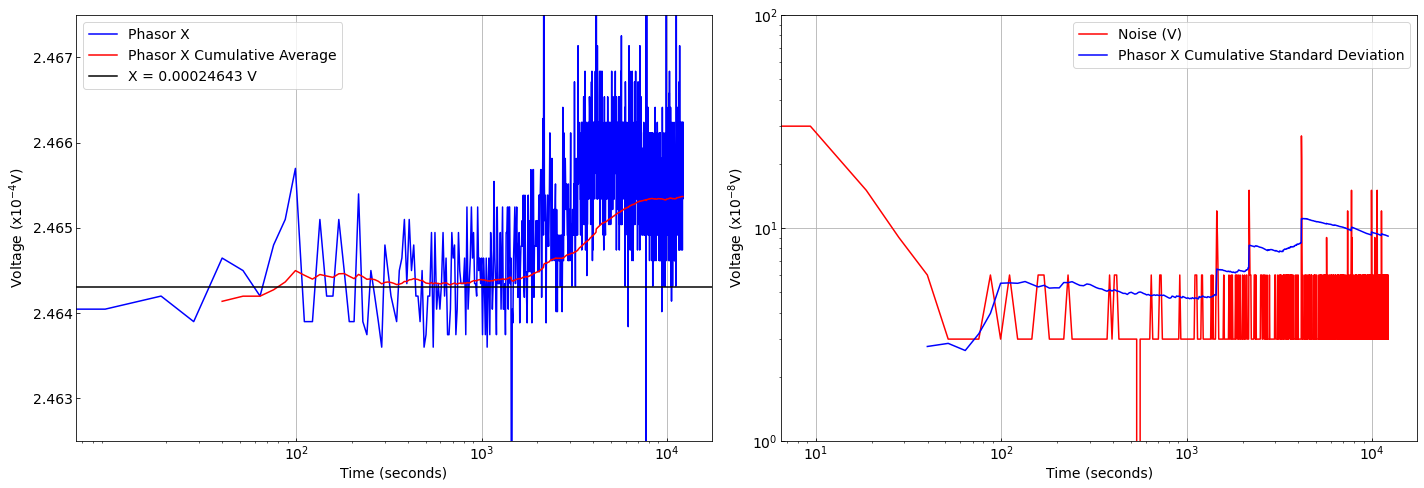

In [31]:
#further analysis of the long data collection

#lists that will be necessary in the analysis
LT_time = []
LT_X = []
LT_Xmean = []
LT_Xstr = []

#necessary value for loop progress
tot = len(df_LT.X)

#calculation of mean and standard deviation as a function of cumulative data points
for n,x in enumerate(df_LT.X):
    LT_X.append(x)
    if n >= 4:
        LT_time.append(df_LT.Time[n])
        LT_Xmean.append(np.mean(LT_X))
        LT_Xstr.append(np.std(LT_X))
        
        clear_output(wait=True)
        #progress indicator
        print(100*n/tot, '% complete')

#plot results of cumulative average and standard deviation calculation
plt.rcParams.update({'font.size': 14})
fig= plt.figure(figsize=(20,7))
gs = gridspec.GridSpec(1,2)

#plot phasor real component with cumulative average
ax1 = plt.subplot(gs[0,0], xlabel='Time (seconds)', ylabel='Voltage (x10$^{-4}$V)')
ax1.plot(df_LT.Time, df_LT.X*10**4, 'b', label='Phasor X')  
ax1.plot(LT_time, [x*10**4 for x in LT_Xmean], 'r', label='Phasor X Cumulative Average')  
ax1.tick_params(direction='in')
ax1.grid(axis='x')
ax1.set_xscale("log")
ax1.set_ylim(ymin=0.00024625*10**4, ymax=0.00024675*10**4)
ax1.xaxis.set_ticks([100,1000,10000])
ax1.axhline(y=0.00024643*10**4, c='black', label='X = 0.00024643 V')
ax1.legend()

#plot lockin amplifier noise report with cumulative phasor X standard deviation
ax2 = plt.subplot(gs[0,1], xlabel='Time (seconds)', ylabel='Voltage (x10$^{-8}$V)')
ax2.plot(df_LT.Time, df_LT.Noise*10**8, 'r', label='Noise (V)')  
ax2.plot(LT_time, [x*10**8 for x in LT_Xstr], 'b', label='Phasor X Cumulative Standard Deviation')  
ax2.tick_params(direction='in')
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.yaxis.set_ticks([1,10,10**2])
ax2.xaxis.set_ticks([10,100,1000,10000])
ax2.grid(axis='x')
ax2.grid(axis='y')
ax2.legend()

plt.tight_layout()
if save_yes == True:
    plt.savefig(plot_pic3, dpi=300, bbox_inches = "tight")
plt.show()

<a id="Results-and-Analysis:-Phasor-Offset-Angle-Sweep"></a>

## Results and Analysis

<ul><ul>
<li><a href="#Results-and-Analysis:-Internal-Oscillator-Voltage-Sweep">Results and Analysis: Internal Oscillator Voltage Sweep</a></li>
<li><a href="#Results-and-Analysis:-Internal-Oscillator-Frequency-Sweep">Results and Analysis: Internal Oscillator Frequency Sweep</a></li>
<li><a href="#Results-and-Analysis:-Time-Constant-Sweep">Results and Analysis: Time Constant Sweep</a></li>
<li><a href="#Results-and-Analysis:-Long-Data-Collection">Results and Analysis: Long Data Collection</a></li>
</ul></ul>

>### Results and Analysis: Phasor Offset Angle Sweep


In [ ]:
# #read data files (csv) if needed
# df_Off = pd.read_csv('Offset_sweep_test.csv')

Results: Phasor Offset Angle Sweep


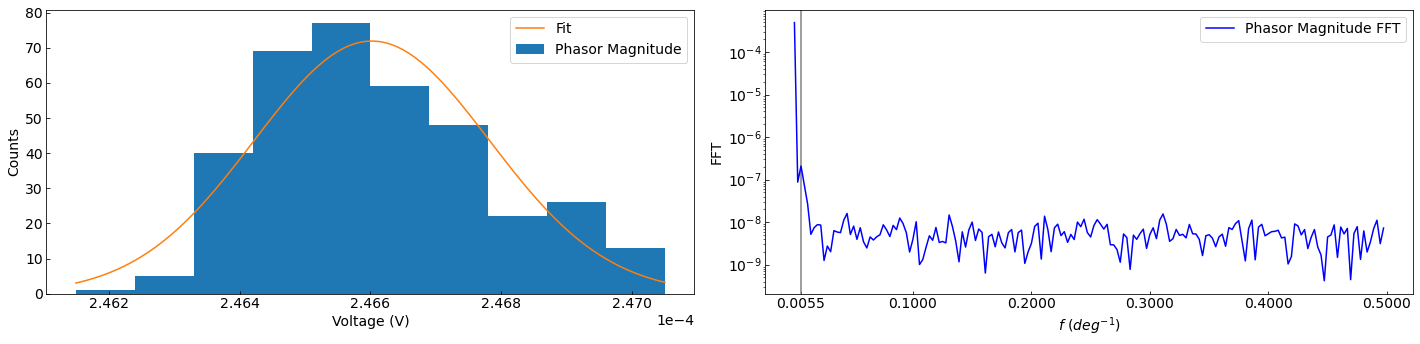

Total measurement time = 15218.841291427612 seconds
Average time step = 42.392315575007274 seconds
Total data points = 360
Mean phasor magnitude = 0.00024660208333333346 V
Maximum histogram bin =  0.00024650999999999997 V
Max histogram bin - mean phasor magnitude =  -9.20833333334912e-08 V
Phasor magnitude standard deviation =  1.7970297638665452e-07 V
Noise mean =  4.474166666666673e-06 V
Noise (mean) / phasor magnitude standard deviation =  24.897565731131333
Signal (magnitude mean) to noise (mean) ratio =  34.82569166695894 dB
Signal (magnitude mean) to standard deviation ratio =  62.74882941914123 dB

Analysis: Phasor Offset Angle Sweep


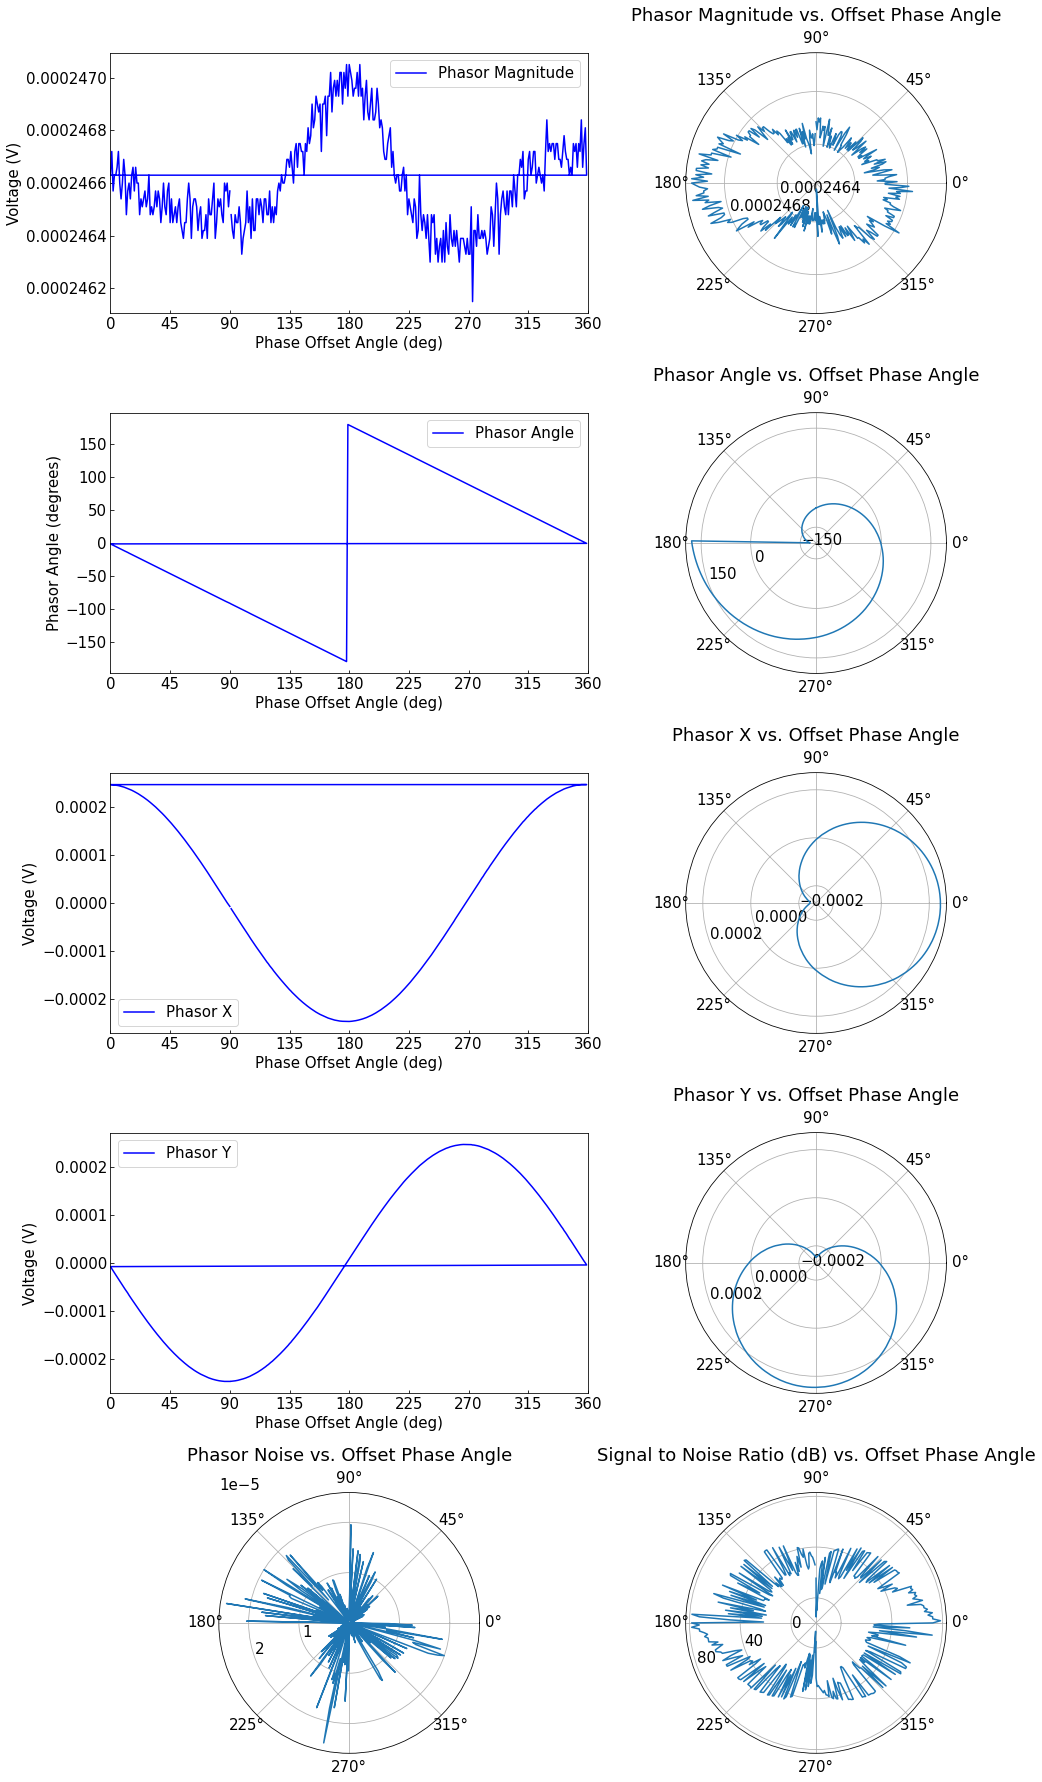

In [34]:
#phasor offset angle sweep analysis

#save plot pics
save_yes = True

#plot pic names
if save_yes == True:
    plot_pic1 = 'Offset_result_1.png'
    plot_pic2 = 'Offset_analysis_1.png'

print('Results: Phasor Offset Angle Sweep')

#plot the statistics and fft (in degrees, not time) for the phasor angle offset sweep
plt.rcParams.update({'font.size': 14})
fig= plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(1,2)

#plot histogram of the phasor magnitude
ax1 = plt.subplot(gs[0,0], xlabel='Voltage (V)', ylabel='Counts')
hist_dat = ax1.hist(df_Off.Magnitude, label='Phasor Magnitude')  
ax1.tick_params(direction='in')

#calculate and plot a fit of the histogram
mean = np.mean(df_Off.Magnitude)
sigma = np.std(df_Off.Magnitude)
x_ax = np.linspace(min(df_Off.Magnitude), max(df_Off.Magnitude), 100)
dx = hist_dat[1][1] - hist_dat[1][0]
amplitude = (len(df_Off.Magnitude))*dx
ax1.ticklabel_format(axis='x', style='sci', scilimits=(-1,1000000))
ax1.plot(x_ax, norm.pdf(x_ax, mean, sigma)*amplitude, label='Fit')
ax1.legend()

df_Off2 = pd.DataFrame(df_Off['Offset'])
df_Off2['Magnitude'] = df_Off['Magnitude']
df_Off2['X'] = df_Off['X']
df_Off2['Y'] = df_Off['Y']
df_Off2['Phase'] = df_Off['Phase']
df_Off2.sort_values(by=['Offset'], ascending=True, inplace=True)

df_Off2['fft'] = fft.fft(list(df_Off2.Magnitude))

t_step = 1
fft_freq_all = fft.fftfreq(len(df_Off2.Magnitude), d=t_step)
fft_freq = [x for n,x in enumerate(fft_freq_all) if x >= 0]

L = len(df_Off2.fft)
fft_yaxis = 2.0/(L + 1) * abs(df_Off2.fft[0:(L + 1)//2])
ax2 = plt.subplot(gs[0,1])
ax2.set_yscale("log")
ax2.xaxis.set_ticks([0.0055,0.1,0.2,0.3,0.4,0.5])
ax2.axvline(x=0.0055, c='grey')
ax2.plot(fft_freq, fft_yaxis, '-b', label='Phasor Magnitude FFT')
ax2.set(xlabel='$f$ ($deg^{-1}$)', ylabel='FFT')
ax2.tick_params(direction='in')
ax2.legend()

plt.tight_layout()
if save_yes == True:
    plt.savefig(plot_pic1, dpi=300, bbox_inches = "tight")
plt.show()

#display the unique settings, data, and calculations for the phasor offset angle sweep
print('Total measurement time =',list(df_Off.Time)[-1],'seconds')
print('Average time step =', np.mean([df_Off.Time[n] - df_Off.Time[n-1] 
                                       for n,x in enumerate(df_Off.Time) if n != 0]), 'seconds')
print('Total data points =',len(df_Off.X))
print('Mean phasor magnitude =', mean, 'V')
print('Maximum histogram bin = ', hist_dat[1][list(hist_dat[0]).index(max(hist_dat[0]))], 'V')
print('Max histogram bin - mean phasor magnitude = ', hist_dat[1][list(hist_dat[0]).index(max(hist_dat[0]))] - mean, 'V')
print('Phasor magnitude standard deviation = ', sigma, 'V')
print('Noise mean = ', np.mean(df_Off.Noise), 'V')
print('Noise (mean) / phasor magnitude standard deviation = ', np.mean(df_Off.Noise)/sigma)
print('Signal (magnitude mean) to noise (mean) ratio = ', 20*np.log10(mean/np.mean(df_Off.Noise)), 'dB')
print('Signal (magnitude mean) to standard deviation ratio = ', 20*np.log10(mean/sigma), 'dB')
print()
print('Analysis: Phasor Offset Angle Sweep')

#plot the data and calculations for the phasor offset angle sweep
plt.rcParams.update({'font.size': 15})
fig= plt.figure(figsize=(15,25))
gs = gridspec.GridSpec(5,2)

#cartesian plot, phasor magnitude
ax1 = plt.subplot(gs[0,0], xlabel='Phase Offset Angle (deg)', ylabel='Voltage (V)')
ax1.plot(df_Off.Offset, df_Off.Magnitude, 'b', label='Phasor Magnitude')  
ax1.xaxis.set_ticks([0,45,90,135,180,225,270,315,360])
ax1.set_xlim(xmin=0, xmax=360)
ax1.tick_params(direction='in')
ax1.legend()

#polar plot, phasor magnitude
ax2 = plt.subplot(gs[0,1],polar=True)
ax2.plot(df_Off.Offset*np.pi/180, df_Off.Magnitude)
ax2.set_rlabel_position(200)  
ax2.grid(True)
ax2.set_title("Phasor Magnitude vs. Offset Phase Angle", va='bottom')
ax2.yaxis.set_major_locator(MaxNLocator(3)) 

#cartesian plot, phasor angle
ax3 = plt.subplot(gs[1,0], xlabel='Phase Offset Angle (deg)', ylabel='Phasor Angle (degrees)')
ax3.plot(df_Off.Offset, df_Off.Phase, 'b', label='Phasor Angle') 
ax3.xaxis.set_ticks([0,45,90,135,180,225,270,315,360])
ax3.set_xlim(xmin=0, xmax=360)
ax3.tick_params(direction='in')
ax3.legend()

#polar plot, phasor angle
ax4 = plt.subplot(gs[1,1],polar=True)
ax4.plot(df_Off.Offset*np.pi/180, df_Off.Phase)
ax4.set_rlabel_position(200)  
ax4.grid(True)
ax4.set_title("Phasor Angle vs. Offset Phase Angle", va='bottom')
ax4.yaxis.set_major_locator(MaxNLocator(3)) 

#cartesian plot, phasor real component
ax5 = plt.subplot(gs[2,0], xlabel='Phase Offset Angle (deg)', ylabel='Voltage (V)')
ax5.plot(df_Off.Offset, df_Off.X, 'b', label='Phasor X') 
ax5.xaxis.set_ticks([0,45,90,135,180,225,270,315,360])
ax5.set_xlim(xmin=0, xmax=360)
ax5.tick_params(direction='in')
ax5.legend()

#polar plot, phasor real component
ax6 = plt.subplot(gs[2,1],polar=True)
ax6.plot(df_Off.Offset*np.pi/180, df_Off.X) 
ax6.set_rlabel_position(200)  
ax6.grid(True)
ax6.set_title("Phasor X vs. Offset Phase Angle", va='bottom')
ax6.yaxis.set_major_locator(MaxNLocator(3)) 

#cartesian plot, phasor imaginary component
ax7 = plt.subplot(gs[3,0], xlabel='Phase Offset Angle (deg)', ylabel='Voltage (V)')
ax7.plot(df_Off.Offset, df_Off.Y, 'b', label='Phasor Y') 
ax7.xaxis.set_ticks([0,45,90,135,180,225,270,315,360])
ax7.set_xlim(xmin=0, xmax=360)
ax7.tick_params(direction='in')
ax7.legend()

#polar plot, phasor imaginary component
ax8 = plt.subplot(gs[3,1],polar=True)
ax8.plot(df_Off.Offset*np.pi/180, df_Off.Y) 
ax8.set_rlabel_position(200)  
ax8.grid(True)
ax8.set_title("Phasor Y vs. Offset Phase Angle", va='bottom')
ax8.yaxis.set_major_locator(MaxNLocator(3)) 

#polar plot, lockin amplifier noise report
ax9 = plt.subplot(gs[4,0],polar=True)
ax9.plot(df_Off.Offset*np.pi/180, df_Off.Noise)
ax9.set_rlabel_position(200)  
ax9.grid(True)
ax9.set_title("Phasor Noise vs. Offset Phase Angle", va='bottom')
ax9.yaxis.set_major_locator(MaxNLocator(3)) 

#calculation of signal (phasor X, point by point) to noise (point by point) ratio in decibels
df_Off['sig2noise'] = 20*np.log10(abs(df_Off.X/df_Off.Noise))
#polar plot, signal to noise ratio
ax10 = plt.subplot(gs[4,1],polar=True)
ax10.plot(df_Off.Offset*np.pi/180, df_Off.sig2noise)
ax10.set_rlabel_position(200)  
ax10.grid(True)
ax10.set_title("Signal to Noise Ratio (dB) vs. Offset Phase Angle", va='bottom')
ax10.yaxis.set_major_locator(MaxNLocator(3)) 

plt.tight_layout()
if save_yes == True:
    plt.savefig(plot_pic2, dpi=300, bbox_inches = "tight")
plt.show()

In [35]:
#Analysis of the phasor angle from the offset angle sweep

print()
print('Data: (Offset angle, phasor angle)',[(x, df_Off.Phase[n]) for n,x in enumerate(df_Off.Offset) if 175 <= x <= 185])
print()
print(f'Offset angle for maximum phasor X value = {df_Off.Offset[np.argmax(df_Off.X)]} degrees')
print()
print(f'Offset angle for maximum phasor Y value = {df_Off.Offset[np.argmax(df_Off.Y)]} degrees')



Data: (Offset angle, phasor angle) [(185.0, 173.2), (184.0, 174.2), (183.0, 175.2), (182.0, 176.2), (181.0, 177.2), (180.0, 178.2), (179.0, 179.0), (178.0, -180.0), (177.0, -179.0), (176.0, -178.0), (175.0, -177.0)]

Offset angle for maximum phasor X value = 358.0 degrees

Offset angle for maximum phasor Y value = 267.0 degrees


#### Phasor angle rough estimations
Phasor angle jump at 180$^{\circ}$: 1.5$^{\circ}$ offset<br>
Phasor X max at 0$^{\circ}$: 2$^{\circ}$ offset<br>
Phasor Y max at 270$^{\circ}$: 3$^{\circ}$ offset<br>

In [37]:
#Numerical analysis of the phasor angle

#Phasor X data
#rotation of cardioid based on points at +/- 45 degrees of the positive x axis
y_diff = []
thetaL = []
for theta in np.arange(0,3,0.001):
    y_diff.append((abs(float(df_Off.loc[df_Off['Offset'] == 45, 'X'])*np.sin((45 + theta)*np.pi/180)) - 
                      abs(float(df_Off.loc[df_Off['Offset'] == 315, 'X'])*np.sin((315 + theta)*np.pi/180)))**2)
    thetaL.append(theta)
X_offset = round(thetaL[y_diff.index(min(y_diff))],3)
print(f'Phasor angle numerical estimate from phasor X data = {X_offset} degrees')

#Phasor Y data
#rotation of cardioid based on points at +/- 45 degrees of the negative y axis
x_diff = []
thetaL = []
for theta in np.arange(0,3,0.001):
    x_diff.append((abs(float(df_Off.loc[df_Off['Offset'] == 225, 'Y'])*np.cos((225 + theta)*np.pi/180)) - 
                      abs(float(df_Off.loc[df_Off['Offset'] == 315, 'Y'])*np.cos((315 + theta)*np.pi/180)))**2)
    thetaL.append(theta)
Y_offset = round(thetaL[x_diff.index(min(x_diff))],3)
print(f'Phasor angle numerical estimate from phasor Y data = {Y_offset} degrees')

print(f'Average phasor angle numerical estimate = {round((X_offset + Y_offset)/2,3)} degrees')

Phasor angle numerical estimate from phasor X data = 1.968 degrees
Phasor angle numerical estimate from phasor Y data = 1.99 degrees
Average phasor angle numerical estimate = 1.979 degrees


<a id="Summary"></a><!--Notebook author: Drew Rebar-->

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Import-Packages">Import Packages</a></li>
<li><a href="#Function-Definitions">Function Definitions</a></li>
<li><a href="#Lockin-amplifier-communication">Lockin Amplifier Communication</a></li>
<li><a href="#Noise-Measurement:-Internal-Oscillator-Voltage-Sweep">Noise Measurement: Internal Oscillator Voltage Sweep</a></li>
<li><a href="#Noise-Measurement:-Internal-Oscillator-Frequency-Sweep">Noise Measurement: Internal Oscillator Frequency Sweep</a></li>
<li><a href="#Noise-Measurement:-Time-Constant-Sweep">Noise Measurement: Time Constant Sweep</a></li>
<li><a href="#Noise-Measurement:-Long-Data-Collection">Noise Measurement: Long Data Collection</a></li>
<li><a href="#Noise-Measurement:-Phasor-Offset-Angle-Sweep">Noise Measurement: Phasor Offset Angle Sweep</a></li>
<li><a href="#Results-and-Analysis">Results and Analysis</a></li>
</ul>

## Summary
<ul>
<li><a href="#Python-and-Package-Versions">Python and Package Versions</a></li>
</ul>

### Questions

1. What is the optimal internal oscillator voltage based on the uncertainty profile?<br>
	>The standard deviation of the measurement and noise profile displayed opposite<br>
	trends with low noise/high standard deviation at the low voltage amplitudes<br>
	and high noise/low standard deviation at the high voltage amplitudes.  The <br>
	mean of the measurement stabilized at 10mV, and the mean and mode converged <br>
    at approximately 50mV.  The signal to noise ratio revealed an optimal range of <br>
	100mv to 1V while the signal to standard deviation ratio leveled off at 100mV <br>
	and remained approximately constant.  The optimal values for the internal oscillator <br>
    voltage amplitude for this measurement of an 0.5 Ohm sample resistor at room <br>
    temperature are 100mV to 1V.  The other settings for this measurement were f=19Hz <br>
    and Tc=1sec.  Note, the 0.5 Ohm sample resistor appears to have been mislabeled and <br>
    is most likely an 0.25 Ohm resistor.<br>

2. What is the optimal internal oscillator frequency based on the noise profile?<br>
	>The real component of the voltage phasor reached a maximum at approximately 11Hz<br>
	and remained fairly constant over the measured range up to 100Hz.  The peaks in<br>
	the noise profile diminished until they stabilized at approximately 40Hz.  Signal to<br>
	noise values accordingly reached their highest points at approximately 40Hz.  The <br>
	optimal values for the internal oscillator frequency for this measurement of an<br>
	0.25 Ohm sample resistor at room temperature are 40Hz to 100Hz (end of the measured<br>
	range).  The other settings for this measurement were V=1V and Tc=1sec.  Note, known <br>
	frequencies with noise such as 60Hz should be avoided.<br>

3. What is the optimal time constant based on the uncertainty profile?<br>
	>The measurement standard deviation and noise registered similar trends with both<br>
	showing a maximum at the lowest time constant and diminishing towards higher time<br>
	constants.  The standard deviation stabilized at approximately 100mV while the<br>
	noise report continued to diminish towards the highest time constant.  At the three<br>
	highest time constants, the lockin amplifier recorded noise values of zero which<br>
	were replaced with arbitrary very small values for the plots.  The signal to noise<br>
	ratio increased with increasing time constant value while the signal to standard <br>
	deviation ratio leveled off at approximately 300ms.  The optimal values of the time<br>
	constant for this measurement of an 0.25 Ohm sample resistor at room temperature are<br>
	300ms to 30s (highest value).  Note, a limiting factor for the high end of the time<br>
	constant range is restriction on measurement time.  <br>

4. How does uncertainty evolve in time with a repeated measurement?<br>
	>The measurement average and standard deviation remained fairly constant till approximately<br>
	1000sec when the mean and standard deviation began to drift to higher values.  Peaks in <br>
	the noise report correlated with sharp increases in the standard deviation.  Note, for a <br>
	measurement on a particular sample, comparison would need to be made between the order of <br>
	magnitude of features of interest and the magnitude of time-dependent lockin amplifier<br>
	drift (mean and standard deviation).  Also, if the high noise report at the beginning of <br>
	the cycle of measurements is undesirable for a particular measurement, one strategy would <br>
    be to collect data and only start recording data once the noise level stabilized.  <br>

5. Can uncertainty be determined by sweeping through a full cycle of the phasor offset angle?<br>
	>The expectation for this measurement was cyclic behavior for the real and imaginary<br>
	components of the voltage phasor with the magnitude remaining constant.  The real <br>
	component behaved as expected with a maximum at approximately 0 degrees and a minimum<br>
	at 180 degrees.  The imaginary component behaved as expected with a small surprise<br>
	that the maximum occurred at 270 degrees and the minimum at 90 degrees.  The phasor<br>
	magnitude did not remain constant as expected.  The phasor magnitude possessed a periodicity<br>
	of approximately 180 degrees with the highest values occurring around 180 degrees (offset angle).  <br>
	Thus, a measurement of the phasor magnitude while sweeping the offset angle would not <br>
	be useful for determining the uncertainty of the measurement.  Note, the results and <br>
	analysis section includes an alternative method for determining the phasor angle to a<br>
	desired precision based on the rotation of the real and imaginary phasor component cardioids.<br>


<a id="Python-and-Package-Versions"></a>

<ul>
<li><a href="#Outline">Outline</a></li>
<li><a href="#Import-Packages">Import Packages</a></li>
<li><a href="#Function-Definitions">Function Definitions</a></li>
<li><a href="#Lockin-amplifier-communication">Lockin Amplifier Communication</a></li>
<li><a href="#Noise-Measurement:-Internal-Oscillator-Voltage-Sweep">Noise Measurement: Internal Oscillator Voltage Sweep</a></li>
<li><a href="#Noise-Measurement:-Internal-Oscillator-Frequency-Sweep">Noise Measurement: Internal Oscillator Frequency Sweep</a></li>
<li><a href="#Noise-Measurement:-Time-Constant-Sweep">Noise Measurement: Time Constant Sweep</a></li>
<li><a href="#Noise-Measurement:-Long-Data-Collection">Noise Measurement: Long Data Collection</a></li>
<li><a href="#Noise-Measurement:-Phasor-Offset-Angle-Sweep">Noise Measurement: Phasor Offset Angle Sweep</a></li>
<li><a href="#Results-and-Analysis">Results and Analysis</a></li>
<li><a href="#Summary">Summary</a></li>
</ul>

## Python and Package Versions



In [38]:
print('python',python_version())
print()
py_session()

python 3.8.5

43 modules found
IPython             	7.19.0                  ipython_genutils    	0.2.0                   prompt_toolkit      	3.0.8
PIL                 	8.0.1                   jedi                	0.17.1                  py_session          	0.1.1
argparse            	1.1                     json                	2.0.9                   pygments            	2.7.2
backcall            	0.2.0                   jupyter_client      	6.1.7                   pyparsing           	2.4.7
bottleneck          	1.3.2                   jupyter_core        	4.6.3                   pytz                	2020.1
cffi                	1.14.3                  kiwisolver          	1.3.0                   pyvisa              	1.11.3
colorama            	0.4.4                   logging             	0.5.1.2                 re                  	2.2.1
csv                 	1.0                     matplotlib          	3.3.2                   scipy               	1.7.0
ctypes              	1.1.0     